# Import Common Package

In [74]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import random

seed = 42
np.random.seed = seed

# Import Dataset

In [75]:
IMG_WIDTH = 384
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [76]:
TRAIN_PATH = "/content/drive/MyDrive/GITHUB BARU/thigh segmentation/dataset/train/"
TEST_PATH = "/content/drive/MyDrive/GITHUB BARU/thigh segmentation/dataset/test/"

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# Resizing Train Images

In [77]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #Fill empty X_train with values from img

    mask = imread(path + '/masks/'+ id_ + '.jpg')[:,:,:1]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_train[n] = mask #Fill empty X_train with values from img

Resizing training images and masks


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


# Resizing Test images

In [78]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

Done!


# Show Random Train Image

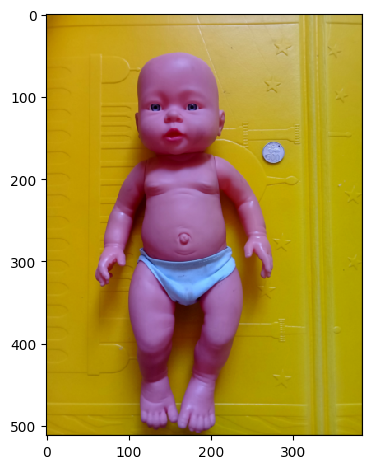

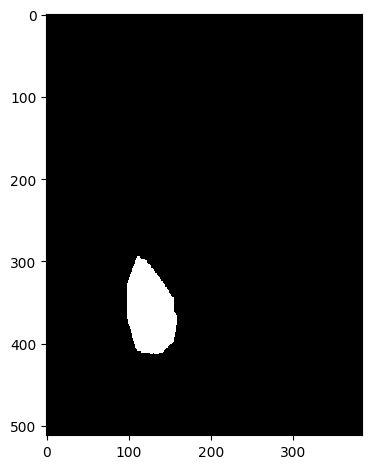

In [79]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

## Build the model

In [80]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

## Contraction path

In [81]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

## Expansive path

In [82]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [83]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.MeanIoU(num_classes=2)])

## Model Checkpoint

In [96]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_head.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_mean_io_u', mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.History()]

## Training

In [97]:
result = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=1000, callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 0.0228 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 181ms/step - loss: 0.0228 - mean_io_u_4: 0.4864 - val_loss: 0.0393 - val_mean_io_u_4: 0.4864
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 0.0182 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 169ms/step - loss: 0.0182 - mean_io_u_4: 0.4864 - val_loss: 0.0430 - val_mean_io_u_4: 0.4864
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 0.0196 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 166ms/step - loss: 0.0196 - mean_io_u_4: 0.4864 - val_loss: 0.0298 - val_mean_io_u_4: 0.4864
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 0.0113 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 133ms/step - loss: 0.0113 - mean_io_u_4: 0.4864 - val_loss: 0.0181 - val_mean_io_u_4: 0.4864
Epoch 5/1000
2/2 [==============================] - ETA: 0s - loss: 0.0096 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 128ms/step - loss: 0.0096 - mean_io_u_4: 0.4864 - val_loss: 0.0226 - val_mean_io_u_4: 0.4864
Epoch 6/1000
2/2 [==============================] - ETA: 0s - loss: 0.0097 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 166ms/step - loss: 0.0097 - mean_io_u_4: 0.4864 - val_loss: 0.0118 - val_mean_io_u_4: 0.4864
Epoch 7/1000
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_io_u_4: 0.4864

2/2 [==============================] - 1s 127ms/step - loss: 0.0084 - mean_io_u_4: 0.4864 - val_loss: 0.0201 - val_mean_io_u_4: 0.4864
Epoch 8/1000
2/2 [==============================] - ETA: 0s - loss: 0.0091 - mean_io_u_4: 0.5101

2/2 [==============================] - 1s 129ms/step - loss: 0.0091 - mean_io_u_4: 0.5101 - val_loss: 0.0133 - val_mean_io_u_4: 0.4864
Epoch 9/1000
2/2 [==============================] - ETA: 0s - loss: 0.0069 - mean_io_u_4: 0.4976

2/2 [==============================] - 1s 180ms/step - loss: 0.0069 - mean_io_u_4: 0.4976 - val_loss: 0.0100 - val_mean_io_u_4: 0.4864
Epoch 10/1000
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_io_u_4: 0.5276

2/2 [==============================] - 1s 187ms/step - loss: 0.0059 - mean_io_u_4: 0.5276 - val_loss: 0.0101 - val_mean_io_u_4: 0.4864
Epoch 11/1000
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_io_u_4: 0.5432

2/2 [==============================] - 1s 147ms/step - loss: 0.0051 - mean_io_u_4: 0.5432 - val_loss: 0.0134 - val_mean_io_u_4: 0.4864
Epoch 12/1000
2/2 [==============================] - ETA: 0s - loss: 0.0073 - mean_io_u_4: 0.5599

2/2 [==============================] - 1s 151ms/step - loss: 0.0073 - mean_io_u_4: 0.5599 - val_loss: 0.0103 - val_mean_io_u_4: 0.4864
Epoch 13/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_4: 0.5089

2/2 [==============================] - 1s 183ms/step - loss: 0.0048 - mean_io_u_4: 0.5089 - val_loss: 0.0114 - val_mean_io_u_4: 0.4864
Epoch 14/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_4: 0.4994

2/2 [==============================] - 1s 125ms/step - loss: 0.0050 - mean_io_u_4: 0.4994 - val_loss: 0.0124 - val_mean_io_u_4: 0.4864
Epoch 15/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_4: 0.5050

2/2 [==============================] - 1s 123ms/step - loss: 0.0053 - mean_io_u_4: 0.5050 - val_loss: 0.0123 - val_mean_io_u_4: 0.4864
Epoch 16/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_4: 0.5263

2/2 [==============================] - 1s 125ms/step - loss: 0.0049 - mean_io_u_4: 0.5263 - val_loss: 0.0112 - val_mean_io_u_4: 0.4864
Epoch 17/1000
2/2 [==============================] - ETA: 0s - loss: 0.0041 - mean_io_u_4: 0.5233

2/2 [==============================] - 1s 136ms/step - loss: 0.0041 - mean_io_u_4: 0.5233 - val_loss: 0.0098 - val_mean_io_u_4: 0.4864
Epoch 18/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_4: 0.5406

2/2 [==============================] - 1s 134ms/step - loss: 0.0036 - mean_io_u_4: 0.5406 - val_loss: 0.0091 - val_mean_io_u_4: 0.4864
Epoch 19/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_4: 0.6056

2/2 [==============================] - 1s 126ms/step - loss: 0.0036 - mean_io_u_4: 0.6056 - val_loss: 0.0088 - val_mean_io_u_4: 0.4942
Epoch 20/1000
2/2 [==============================] - ETA: 0s - loss: 0.0038 - mean_io_u_4: 0.6645

2/2 [==============================] - 1s 128ms/step - loss: 0.0038 - mean_io_u_4: 0.6645 - val_loss: 0.0100 - val_mean_io_u_4: 0.5062
Epoch 21/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_4: 0.6762

2/2 [==============================] - 1s 127ms/step - loss: 0.0036 - mean_io_u_4: 0.6762 - val_loss: 0.0082 - val_mean_io_u_4: 0.4864
Epoch 22/1000
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_io_u_4: 0.6101

2/2 [==============================] - 1s 126ms/step - loss: 0.0044 - mean_io_u_4: 0.6101 - val_loss: 0.0111 - val_mean_io_u_4: 0.4864
Epoch 23/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_4: 0.6467

2/2 [==============================] - 1s 126ms/step - loss: 0.0034 - mean_io_u_4: 0.6467 - val_loss: 0.0090 - val_mean_io_u_4: 0.4864
Epoch 24/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_4: 0.5869

2/2 [==============================] - 1s 127ms/step - loss: 0.0033 - mean_io_u_4: 0.5869 - val_loss: 0.0075 - val_mean_io_u_4: 0.4864
Epoch 25/1000
2/2 [==============================] - ETA: 0s - loss: 0.0038 - mean_io_u_4: 0.5284

2/2 [==============================] - 1s 134ms/step - loss: 0.0038 - mean_io_u_4: 0.5284 - val_loss: 0.0111 - val_mean_io_u_4: 0.4864
Epoch 26/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_4: 0.5869

2/2 [==============================] - 1s 130ms/step - loss: 0.0033 - mean_io_u_4: 0.5869 - val_loss: 0.0105 - val_mean_io_u_4: 0.4864
Epoch 27/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_4: 0.5894

2/2 [==============================] - 1s 272ms/step - loss: 0.0032 - mean_io_u_4: 0.5894 - val_loss: 0.0084 - val_mean_io_u_4: 0.4864
Epoch 28/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_4: 0.5718

2/2 [==============================] - 1s 225ms/step - loss: 0.0031 - mean_io_u_4: 0.5718 - val_loss: 0.0111 - val_mean_io_u_4: 0.4864
Epoch 29/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_4: 0.6144

2/2 [==============================] - 1s 182ms/step - loss: 0.0031 - mean_io_u_4: 0.6144 - val_loss: 0.0086 - val_mean_io_u_4: 0.4864
Epoch 30/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_4: 0.5863

2/2 [==============================] - 1s 154ms/step - loss: 0.0032 - mean_io_u_4: 0.5863 - val_loss: 0.0070 - val_mean_io_u_4: 0.4864
Epoch 31/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_4: 0.5805

2/2 [==============================] - 1s 154ms/step - loss: 0.0031 - mean_io_u_4: 0.5805 - val_loss: 0.0092 - val_mean_io_u_4: 0.4864
Epoch 32/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_4: 0.6236

2/2 [==============================] - 1s 178ms/step - loss: 0.0032 - mean_io_u_4: 0.6236 - val_loss: 0.0075 - val_mean_io_u_4: 0.4864
Epoch 33/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_4: 0.5934

2/2 [==============================] - 1s 190ms/step - loss: 0.0030 - mean_io_u_4: 0.5934 - val_loss: 0.0071 - val_mean_io_u_4: 0.4864
Epoch 34/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_4: 0.6067

2/2 [==============================] - 1s 127ms/step - loss: 0.0029 - mean_io_u_4: 0.6067 - val_loss: 0.0116 - val_mean_io_u_4: 0.4864
Epoch 35/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_4: 0.6581

2/2 [==============================] - 1s 134ms/step - loss: 0.0035 - mean_io_u_4: 0.6581 - val_loss: 0.0061 - val_mean_io_u_4: 0.4864
Epoch 36/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_4: 0.5831

2/2 [==============================] - 1s 131ms/step - loss: 0.0034 - mean_io_u_4: 0.5831 - val_loss: 0.0071 - val_mean_io_u_4: 0.4864
Epoch 37/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_4: 0.5775

2/2 [==============================] - 1s 127ms/step - loss: 0.0034 - mean_io_u_4: 0.5775 - val_loss: 0.0097 - val_mean_io_u_4: 0.4864
Epoch 38/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_4: 0.6357

2/2 [==============================] - 1s 128ms/step - loss: 0.0028 - mean_io_u_4: 0.6357 - val_loss: 0.0075 - val_mean_io_u_4: 0.4864
Epoch 39/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_4: 0.6365

2/2 [==============================] - 1s 129ms/step - loss: 0.0030 - mean_io_u_4: 0.6365 - val_loss: 0.0063 - val_mean_io_u_4: 0.4864
Epoch 40/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_4: 0.6138

2/2 [==============================] - 1s 128ms/step - loss: 0.0031 - mean_io_u_4: 0.6138 - val_loss: 0.0100 - val_mean_io_u_4: 0.4864
Epoch 41/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_4: 0.6238

2/2 [==============================] - 1s 133ms/step - loss: 0.0027 - mean_io_u_4: 0.6238 - val_loss: 0.0121 - val_mean_io_u_4: 0.4864
Epoch 42/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_4: 0.6213

2/2 [==============================] - 1s 129ms/step - loss: 0.0030 - mean_io_u_4: 0.6213 - val_loss: 0.0097 - val_mean_io_u_4: 0.4864
Epoch 43/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_4: 0.5993

2/2 [==============================] - 1s 125ms/step - loss: 0.0031 - mean_io_u_4: 0.5993 - val_loss: 0.0088 - val_mean_io_u_4: 0.4869
Epoch 44/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_4: 0.6576

2/2 [==============================] - 1s 131ms/step - loss: 0.0026 - mean_io_u_4: 0.6576 - val_loss: 0.0086 - val_mean_io_u_4: 0.4887
Epoch 45/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_4: 0.6616

2/2 [==============================] - 1s 168ms/step - loss: 0.0025 - mean_io_u_4: 0.6616 - val_loss: 0.0064 - val_mean_io_u_4: 0.4864
Epoch 46/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_4: 0.6195

2/2 [==============================] - 1s 129ms/step - loss: 0.0029 - mean_io_u_4: 0.6195 - val_loss: 0.0070 - val_mean_io_u_4: 0.4915
Epoch 47/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_4: 0.6703

2/2 [==============================] - 1s 132ms/step - loss: 0.0025 - mean_io_u_4: 0.6703 - val_loss: 0.0103 - val_mean_io_u_4: 0.5221
Epoch 48/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_4: 0.7108

2/2 [==============================] - 1s 128ms/step - loss: 0.0030 - mean_io_u_4: 0.7108 - val_loss: 0.0081 - val_mean_io_u_4: 0.4864
Epoch 49/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_4: 0.6396

2/2 [==============================] - 1s 136ms/step - loss: 0.0027 - mean_io_u_4: 0.6396 - val_loss: 0.0069 - val_mean_io_u_4: 0.4864
Epoch 50/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_4: 0.6523

2/2 [==============================] - 1s 186ms/step - loss: 0.0025 - mean_io_u_4: 0.6523 - val_loss: 0.0092 - val_mean_io_u_4: 0.5164
Epoch 51/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_4: 0.7170

2/2 [==============================] - 1s 183ms/step - loss: 0.0029 - mean_io_u_4: 0.7170 - val_loss: 0.0124 - val_mean_io_u_4: 0.4886
Epoch 52/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.6715

2/2 [==============================] - 1s 146ms/step - loss: 0.0024 - mean_io_u_4: 0.6715 - val_loss: 0.0116 - val_mean_io_u_4: 0.4864
Epoch 53/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_4: 0.6528

2/2 [==============================] - 1s 190ms/step - loss: 0.0025 - mean_io_u_4: 0.6528 - val_loss: 0.0072 - val_mean_io_u_4: 0.5123
Epoch 54/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_4: 0.7007

2/2 [==============================] - 1s 129ms/step - loss: 0.0027 - mean_io_u_4: 0.7007 - val_loss: 0.0068 - val_mean_io_u_4: 0.5003
Epoch 55/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_4: 0.6945

2/2 [==============================] - 1s 127ms/step - loss: 0.0025 - mean_io_u_4: 0.6945 - val_loss: 0.0068 - val_mean_io_u_4: 0.4891
Epoch 56/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.6778

2/2 [==============================] - 1s 128ms/step - loss: 0.0024 - mean_io_u_4: 0.6778 - val_loss: 0.0085 - val_mean_io_u_4: 0.5163
Epoch 57/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.7088

2/2 [==============================] - 1s 168ms/step - loss: 0.0024 - mean_io_u_4: 0.7088 - val_loss: 0.0071 - val_mean_io_u_4: 0.5086
Epoch 58/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7004

2/2 [==============================] - 1s 140ms/step - loss: 0.0023 - mean_io_u_4: 0.7004 - val_loss: 0.0061 - val_mean_io_u_4: 0.4894
Epoch 59/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_4: 0.6765

2/2 [==============================] - 1s 126ms/step - loss: 0.0028 - mean_io_u_4: 0.6765 - val_loss: 0.0092 - val_mean_io_u_4: 0.5196
Epoch 60/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7339

2/2 [==============================] - 1s 130ms/step - loss: 0.0023 - mean_io_u_4: 0.7339 - val_loss: 0.0091 - val_mean_io_u_4: 0.5083
Epoch 61/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7076

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_4: 0.7076 - val_loss: 0.0059 - val_mean_io_u_4: 0.4864
Epoch 62/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_4: 0.6517

2/2 [==============================] - 1s 164ms/step - loss: 0.0028 - mean_io_u_4: 0.6517 - val_loss: 0.0084 - val_mean_io_u_4: 0.4895
Epoch 63/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.7040

2/2 [==============================] - 1s 127ms/step - loss: 0.0024 - mean_io_u_4: 0.7040 - val_loss: 0.0196 - val_mean_io_u_4: 0.5108
Epoch 64/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_4: 0.7297

2/2 [==============================] - 1s 173ms/step - loss: 0.0030 - mean_io_u_4: 0.7297 - val_loss: 0.0131 - val_mean_io_u_4: 0.4864
Epoch 65/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_4: 0.6607

2/2 [==============================] - 1s 131ms/step - loss: 0.0026 - mean_io_u_4: 0.6607 - val_loss: 0.0129 - val_mean_io_u_4: 0.4876
Epoch 66/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.6757

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_4: 0.6757 - val_loss: 0.0158 - val_mean_io_u_4: 0.5256
Epoch 67/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.7323

2/2 [==============================] - 1s 129ms/step - loss: 0.0024 - mean_io_u_4: 0.7323 - val_loss: 0.0071 - val_mean_io_u_4: 0.4995
Epoch 68/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_4: 0.7123

2/2 [==============================] - 1s 131ms/step - loss: 0.0027 - mean_io_u_4: 0.7123 - val_loss: 0.0077 - val_mean_io_u_4: 0.4926
Epoch 69/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7008

2/2 [==============================] - 1s 154ms/step - loss: 0.0022 - mean_io_u_4: 0.7008 - val_loss: 0.0132 - val_mean_io_u_4: 0.5239
Epoch 70/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7338

2/2 [==============================] - 1s 154ms/step - loss: 0.0023 - mean_io_u_4: 0.7338 - val_loss: 0.0101 - val_mean_io_u_4: 0.5368
Epoch 71/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7367

2/2 [==============================] - 1s 158ms/step - loss: 0.0022 - mean_io_u_4: 0.7367 - val_loss: 0.0067 - val_mean_io_u_4: 0.5502
Epoch 72/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7487

2/2 [==============================] - 1s 154ms/step - loss: 0.0023 - mean_io_u_4: 0.7487 - val_loss: 0.0126 - val_mean_io_u_4: 0.5878
Epoch 73/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7896

2/2 [==============================] - 1s 186ms/step - loss: 0.0022 - mean_io_u_4: 0.7896 - val_loss: 0.0112 - val_mean_io_u_4: 0.5678
Epoch 74/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7715

2/2 [==============================] - 1s 126ms/step - loss: 0.0021 - mean_io_u_4: 0.7715 - val_loss: 0.0114 - val_mean_io_u_4: 0.5659
Epoch 75/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7615

2/2 [==============================] - 1s 130ms/step - loss: 0.0021 - mean_io_u_4: 0.7615 - val_loss: 0.0129 - val_mean_io_u_4: 0.5844
Epoch 76/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7737

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_4: 0.7737 - val_loss: 0.0081 - val_mean_io_u_4: 0.5754
Epoch 77/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7685

2/2 [==============================] - 1s 129ms/step - loss: 0.0021 - mean_io_u_4: 0.7685 - val_loss: 0.0098 - val_mean_io_u_4: 0.5917
Epoch 78/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7814

2/2 [==============================] - 1s 135ms/step - loss: 0.0023 - mean_io_u_4: 0.7814 - val_loss: 0.0158 - val_mean_io_u_4: 0.5764
Epoch 79/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7646

2/2 [==============================] - 1s 131ms/step - loss: 0.0019 - mean_io_u_4: 0.7646 - val_loss: 0.0158 - val_mean_io_u_4: 0.5673
Epoch 80/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7610

2/2 [==============================] - 1s 132ms/step - loss: 0.0023 - mean_io_u_4: 0.7610 - val_loss: 0.0141 - val_mean_io_u_4: 0.5861
Epoch 81/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7783

2/2 [==============================] - 1s 128ms/step - loss: 0.0021 - mean_io_u_4: 0.7783 - val_loss: 0.0117 - val_mean_io_u_4: 0.5936
Epoch 82/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7755

2/2 [==============================] - 1s 129ms/step - loss: 0.0022 - mean_io_u_4: 0.7755 - val_loss: 0.0185 - val_mean_io_u_4: 0.5985
Epoch 83/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7854

2/2 [==============================] - 1s 132ms/step - loss: 0.0021 - mean_io_u_4: 0.7854 - val_loss: 0.0172 - val_mean_io_u_4: 0.5844
Epoch 84/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7706

2/2 [==============================] - 1s 131ms/step - loss: 0.0020 - mean_io_u_4: 0.7706 - val_loss: 0.0138 - val_mean_io_u_4: 0.5916
Epoch 85/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7719

2/2 [==============================] - 1s 133ms/step - loss: 0.0022 - mean_io_u_4: 0.7719 - val_loss: 0.0101 - val_mean_io_u_4: 0.5793
Epoch 86/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7712

2/2 [==============================] - 1s 130ms/step - loss: 0.0021 - mean_io_u_4: 0.7712 - val_loss: 0.0155 - val_mean_io_u_4: 0.5892
Epoch 87/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.7893

2/2 [==============================] - 1s 129ms/step - loss: 0.0024 - mean_io_u_4: 0.7893 - val_loss: 0.0162 - val_mean_io_u_4: 0.5895
Epoch 88/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7806

2/2 [==============================] - 1s 171ms/step - loss: 0.0021 - mean_io_u_4: 0.7806 - val_loss: 0.0074 - val_mean_io_u_4: 0.5412
Epoch 89/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_4: 0.7426

2/2 [==============================] - 1s 183ms/step - loss: 0.0023 - mean_io_u_4: 0.7426 - val_loss: 0.0059 - val_mean_io_u_4: 0.5440
Epoch 90/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7528

2/2 [==============================] - 1s 156ms/step - loss: 0.0022 - mean_io_u_4: 0.7528 - val_loss: 0.0112 - val_mean_io_u_4: 0.5864
Epoch 91/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7846

2/2 [==============================] - 1s 185ms/step - loss: 0.0021 - mean_io_u_4: 0.7846 - val_loss: 0.0193 - val_mean_io_u_4: 0.5757
Epoch 92/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7793

2/2 [==============================] - 1s 158ms/step - loss: 0.0021 - mean_io_u_4: 0.7793 - val_loss: 0.0098 - val_mean_io_u_4: 0.5270
Epoch 93/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7426

2/2 [==============================] - 1s 157ms/step - loss: 0.0022 - mean_io_u_4: 0.7426 - val_loss: 0.0081 - val_mean_io_u_4: 0.5390
Epoch 94/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7507

2/2 [==============================] - 1s 135ms/step - loss: 0.0021 - mean_io_u_4: 0.7507 - val_loss: 0.0210 - val_mean_io_u_4: 0.5810
Epoch 95/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7815

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_4: 0.7815 - val_loss: 0.0105 - val_mean_io_u_4: 0.5444
Epoch 96/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7547

2/2 [==============================] - 1s 172ms/step - loss: 0.0020 - mean_io_u_4: 0.7547 - val_loss: 0.0076 - val_mean_io_u_4: 0.5513
Epoch 97/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_4: 0.7645

2/2 [==============================] - 1s 172ms/step - loss: 0.0024 - mean_io_u_4: 0.7645 - val_loss: 0.0187 - val_mean_io_u_4: 0.5979
Epoch 98/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7873

2/2 [==============================] - 1s 170ms/step - loss: 0.0021 - mean_io_u_4: 0.7873 - val_loss: 0.0126 - val_mean_io_u_4: 0.5570
Epoch 99/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7596

2/2 [==============================] - 1s 178ms/step - loss: 0.0021 - mean_io_u_4: 0.7596 - val_loss: 0.0074 - val_mean_io_u_4: 0.5322
Epoch 100/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7398

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_4: 0.7398 - val_loss: 0.0101 - val_mean_io_u_4: 0.5826
Epoch 101/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7802

2/2 [==============================] - 1s 131ms/step - loss: 0.0019 - mean_io_u_4: 0.7802 - val_loss: 0.0156 - val_mean_io_u_4: 0.5992
Epoch 102/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7872

2/2 [==============================] - 1s 128ms/step - loss: 0.0019 - mean_io_u_4: 0.7872 - val_loss: 0.0172 - val_mean_io_u_4: 0.5378
Epoch 103/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_4: 0.7484

2/2 [==============================] - 1s 171ms/step - loss: 0.0026 - mean_io_u_4: 0.7484 - val_loss: 0.0166 - val_mean_io_u_4: 0.5820
Epoch 104/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7854

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_4: 0.7854 - val_loss: 0.0088 - val_mean_io_u_4: 0.6133
Epoch 105/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7952

2/2 [==============================] - 1s 130ms/step - loss: 0.0021 - mean_io_u_4: 0.7952 - val_loss: 0.0066 - val_mean_io_u_4: 0.5603
Epoch 106/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_4: 0.7703

2/2 [==============================] - 1s 130ms/step - loss: 0.0022 - mean_io_u_4: 0.7703 - val_loss: 0.0095 - val_mean_io_u_4: 0.5717
Epoch 107/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7794

2/2 [==============================] - 1s 135ms/step - loss: 0.0021 - mean_io_u_4: 0.7794 - val_loss: 0.0093 - val_mean_io_u_4: 0.5980
Epoch 108/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7872

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_4: 0.7872 - val_loss: 0.0042 - val_mean_io_u_4: 0.5573
Epoch 109/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7556

2/2 [==============================] - 1s 188ms/step - loss: 0.0021 - mean_io_u_4: 0.7556 - val_loss: 0.0074 - val_mean_io_u_4: 0.5833
Epoch 110/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7795

2/2 [==============================] - 1s 194ms/step - loss: 0.0020 - mean_io_u_4: 0.7795 - val_loss: 0.0109 - val_mean_io_u_4: 0.6059
Epoch 111/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7881

2/2 [==============================] - 1s 186ms/step - loss: 0.0020 - mean_io_u_4: 0.7881 - val_loss: 0.0048 - val_mean_io_u_4: 0.5626
Epoch 112/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7594

2/2 [==============================] - 1s 189ms/step - loss: 0.0019 - mean_io_u_4: 0.7594 - val_loss: 0.0047 - val_mean_io_u_4: 0.5792
Epoch 113/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7697

2/2 [==============================] - 1s 202ms/step - loss: 0.0020 - mean_io_u_4: 0.7697 - val_loss: 0.0096 - val_mean_io_u_4: 0.6164
Epoch 114/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7895

2/2 [==============================] - 1s 172ms/step - loss: 0.0020 - mean_io_u_4: 0.7895 - val_loss: 0.0063 - val_mean_io_u_4: 0.5869
Epoch 115/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7695

2/2 [==============================] - 1s 129ms/step - loss: 0.0020 - mean_io_u_4: 0.7695 - val_loss: 0.0053 - val_mean_io_u_4: 0.5911
Epoch 116/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7711

2/2 [==============================] - 1s 132ms/step - loss: 0.0019 - mean_io_u_4: 0.7711 - val_loss: 0.0071 - val_mean_io_u_4: 0.6362
Epoch 117/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7922

2/2 [==============================] - 1s 131ms/step - loss: 0.0020 - mean_io_u_4: 0.7922 - val_loss: 0.0036 - val_mean_io_u_4: 0.5939
Epoch 118/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.7634

2/2 [==============================] - 1s 130ms/step - loss: 0.0020 - mean_io_u_4: 0.7634 - val_loss: 0.0033 - val_mean_io_u_4: 0.6069
Epoch 119/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_4: 0.7748

2/2 [==============================] - 1s 175ms/step - loss: 0.0021 - mean_io_u_4: 0.7748 - val_loss: 0.0090 - val_mean_io_u_4: 0.6929
Epoch 120/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.8097

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_4: 0.8097 - val_loss: 0.0082 - val_mean_io_u_4: 0.6771
Epoch 121/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.7973

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_4: 0.7973 - val_loss: 0.0080 - val_mean_io_u_4: 0.6763
Epoch 122/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.7964

2/2 [==============================] - 1s 136ms/step - loss: 0.0019 - mean_io_u_4: 0.7964 - val_loss: 0.0083 - val_mean_io_u_4: 0.7086
Epoch 123/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8133

2/2 [==============================] - 1s 173ms/step - loss: 0.0017 - mean_io_u_4: 0.8133 - val_loss: 0.0062 - val_mean_io_u_4: 0.7282
Epoch 124/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8194

2/2 [==============================] - 1s 128ms/step - loss: 0.0018 - mean_io_u_4: 0.8194 - val_loss: 0.0080 - val_mean_io_u_4: 0.7430
Epoch 125/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8296

2/2 [==============================] - 1s 178ms/step - loss: 0.0016 - mean_io_u_4: 0.8296 - val_loss: 0.0098 - val_mean_io_u_4: 0.7440
Epoch 126/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8278

2/2 [==============================] - 1s 175ms/step - loss: 0.0017 - mean_io_u_4: 0.8278 - val_loss: 0.0050 - val_mean_io_u_4: 0.7328
Epoch 127/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8199

2/2 [==============================] - 1s 171ms/step - loss: 0.0018 - mean_io_u_4: 0.8199 - val_loss: 0.0042 - val_mean_io_u_4: 0.7569
Epoch 128/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8371

2/2 [==============================] - 1s 175ms/step - loss: 0.0018 - mean_io_u_4: 0.8371 - val_loss: 0.0111 - val_mean_io_u_4: 0.7778
Epoch 129/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8491

2/2 [==============================] - 1s 193ms/step - loss: 0.0018 - mean_io_u_4: 0.8491 - val_loss: 0.0062 - val_mean_io_u_4: 0.7387
Epoch 130/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.8198

2/2 [==============================] - 1s 199ms/step - loss: 0.0019 - mean_io_u_4: 0.8198 - val_loss: 0.0060 - val_mean_io_u_4: 0.7443
Epoch 131/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8285

2/2 [==============================] - 1s 199ms/step - loss: 0.0017 - mean_io_u_4: 0.8285 - val_loss: 0.0062 - val_mean_io_u_4: 0.7717
Epoch 132/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.8421

2/2 [==============================] - 1s 188ms/step - loss: 0.0019 - mean_io_u_4: 0.8421 - val_loss: 0.0061 - val_mean_io_u_4: 0.7638
Epoch 133/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8398

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_4: 0.8398 - val_loss: 0.0060 - val_mean_io_u_4: 0.7378
Epoch 134/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8221

2/2 [==============================] - 1s 132ms/step - loss: 0.0017 - mean_io_u_4: 0.8221 - val_loss: 0.0084 - val_mean_io_u_4: 0.7391
Epoch 135/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8226

2/2 [==============================] - 1s 137ms/step - loss: 0.0017 - mean_io_u_4: 0.8226 - val_loss: 0.0162 - val_mean_io_u_4: 0.7543
Epoch 136/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8330

2/2 [==============================] - 1s 130ms/step - loss: 0.0018 - mean_io_u_4: 0.8330 - val_loss: 0.0061 - val_mean_io_u_4: 0.7288
Epoch 137/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8123

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_4: 0.8123 - val_loss: 0.0061 - val_mean_io_u_4: 0.7345
Epoch 138/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8175

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_4: 0.8175 - val_loss: 0.0134 - val_mean_io_u_4: 0.7608
Epoch 139/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8335

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_4: 0.8335 - val_loss: 0.0114 - val_mean_io_u_4: 0.7584
Epoch 140/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8328

2/2 [==============================] - 1s 135ms/step - loss: 0.0016 - mean_io_u_4: 0.8328 - val_loss: 0.0110 - val_mean_io_u_4: 0.7572
Epoch 141/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8291

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_4: 0.8291 - val_loss: 0.0192 - val_mean_io_u_4: 0.7685
Epoch 142/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8425

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_4: 0.8425 - val_loss: 0.0157 - val_mean_io_u_4: 0.7695
Epoch 143/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8408

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_4: 0.8408 - val_loss: 0.0125 - val_mean_io_u_4: 0.7716
Epoch 144/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8418

2/2 [==============================] - 1s 173ms/step - loss: 0.0016 - mean_io_u_4: 0.8418 - val_loss: 0.0099 - val_mean_io_u_4: 0.7756
Epoch 145/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8430

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_4: 0.8430 - val_loss: 0.0055 - val_mean_io_u_4: 0.7779
Epoch 146/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8436

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_4: 0.8436 - val_loss: 0.0066 - val_mean_io_u_4: 0.7904
Epoch 147/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8522

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_4: 0.8522 - val_loss: 0.0087 - val_mean_io_u_4: 0.7836
Epoch 148/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8473

2/2 [==============================] - 1s 185ms/step - loss: 0.0016 - mean_io_u_4: 0.8473 - val_loss: 0.0060 - val_mean_io_u_4: 0.7732
Epoch 149/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.8402

2/2 [==============================] - 1s 199ms/step - loss: 0.0019 - mean_io_u_4: 0.8402 - val_loss: 0.0075 - val_mean_io_u_4: 0.7990
Epoch 150/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8566

2/2 [==============================] - 1s 156ms/step - loss: 0.0017 - mean_io_u_4: 0.8566 - val_loss: 0.0097 - val_mean_io_u_4: 0.8108
Epoch 151/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8648

2/2 [==============================] - 1s 165ms/step - loss: 0.0017 - mean_io_u_4: 0.8648 - val_loss: 0.0049 - val_mean_io_u_4: 0.7920
Epoch 152/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8478

2/2 [==============================] - 1s 196ms/step - loss: 0.0016 - mean_io_u_4: 0.8478 - val_loss: 0.0075 - val_mean_io_u_4: 0.7961
Epoch 153/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8546

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_4: 0.8546 - val_loss: 0.0057 - val_mean_io_u_4: 0.7924
Epoch 154/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8465

2/2 [==============================] - 1s 135ms/step - loss: 0.0015 - mean_io_u_4: 0.8465 - val_loss: 0.0049 - val_mean_io_u_4: 0.7889
Epoch 155/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8438

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_4: 0.8438 - val_loss: 0.0100 - val_mean_io_u_4: 0.8015
Epoch 156/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8559

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_4: 0.8559 - val_loss: 0.0105 - val_mean_io_u_4: 0.7950
Epoch 157/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8523

2/2 [==============================] - 1s 129ms/step - loss: 0.0016 - mean_io_u_4: 0.8523 - val_loss: 0.0077 - val_mean_io_u_4: 0.7868
Epoch 158/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8444

2/2 [==============================] - 1s 144ms/step - loss: 0.0015 - mean_io_u_4: 0.8444 - val_loss: 0.0077 - val_mean_io_u_4: 0.7936
Epoch 159/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8483

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_4: 0.8483 - val_loss: 0.0122 - val_mean_io_u_4: 0.8060
Epoch 160/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8605

2/2 [==============================] - 1s 139ms/step - loss: 0.0016 - mean_io_u_4: 0.8605 - val_loss: 0.0060 - val_mean_io_u_4: 0.7915
Epoch 161/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8485

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_4: 0.8485 - val_loss: 0.0065 - val_mean_io_u_4: 0.7914
Epoch 162/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8502

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_4: 0.8502 - val_loss: 0.0068 - val_mean_io_u_4: 0.8030
Epoch 163/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8576

2/2 [==============================] - 1s 129ms/step - loss: 0.0015 - mean_io_u_4: 0.8576 - val_loss: 0.0041 - val_mean_io_u_4: 0.8014
Epoch 164/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.8532

2/2 [==============================] - 1s 173ms/step - loss: 0.0019 - mean_io_u_4: 0.8532 - val_loss: 0.0070 - val_mean_io_u_4: 0.7930
Epoch 165/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8497

2/2 [==============================] - 1s 172ms/step - loss: 0.0015 - mean_io_u_4: 0.8497 - val_loss: 0.0077 - val_mean_io_u_4: 0.7722
Epoch 166/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.8362

2/2 [==============================] - 1s 130ms/step - loss: 0.0020 - mean_io_u_4: 0.8362 - val_loss: 0.0039 - val_mean_io_u_4: 0.7686
Epoch 167/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8356

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_4: 0.8356 - val_loss: 0.0039 - val_mean_io_u_4: 0.7915
Epoch 168/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.8523

2/2 [==============================] - 1s 195ms/step - loss: 0.0020 - mean_io_u_4: 0.8523 - val_loss: 0.0029 - val_mean_io_u_4: 0.7750
Epoch 169/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8368

2/2 [==============================] - 1s 178ms/step - loss: 0.0018 - mean_io_u_4: 0.8368 - val_loss: 0.0030 - val_mean_io_u_4: 0.7602
Epoch 170/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8304

2/2 [==============================] - 1s 175ms/step - loss: 0.0017 - mean_io_u_4: 0.8304 - val_loss: 0.0078 - val_mean_io_u_4: 0.7858
Epoch 171/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8504

2/2 [==============================] - 1s 188ms/step - loss: 0.0017 - mean_io_u_4: 0.8504 - val_loss: 0.0050 - val_mean_io_u_4: 0.7720
Epoch 172/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8392

2/2 [==============================] - 1s 129ms/step - loss: 0.0014 - mean_io_u_4: 0.8392 - val_loss: 0.0036 - val_mean_io_u_4: 0.7578
Epoch 173/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8295

2/2 [==============================] - 1s 139ms/step - loss: 0.0016 - mean_io_u_4: 0.8295 - val_loss: 0.0065 - val_mean_io_u_4: 0.7782
Epoch 174/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8450

2/2 [==============================] - 1s 130ms/step - loss: 0.0015 - mean_io_u_4: 0.8450 - val_loss: 0.0064 - val_mean_io_u_4: 0.7765
Epoch 175/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8414

2/2 [==============================] - 1s 168ms/step - loss: 0.0014 - mean_io_u_4: 0.8414 - val_loss: 0.0052 - val_mean_io_u_4: 0.7758
Epoch 176/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8371

2/2 [==============================] - 1s 146ms/step - loss: 0.0016 - mean_io_u_4: 0.8371 - val_loss: 0.0109 - val_mean_io_u_4: 0.7950
Epoch 177/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8491

2/2 [==============================] - 1s 131ms/step - loss: 0.0016 - mean_io_u_4: 0.8491 - val_loss: 0.0084 - val_mean_io_u_4: 0.7905
Epoch 178/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8446

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_4: 0.8446 - val_loss: 0.0055 - val_mean_io_u_4: 0.7860
Epoch 179/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8433

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_4: 0.8433 - val_loss: 0.0048 - val_mean_io_u_4: 0.7994
Epoch 180/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8532

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_4: 0.8532 - val_loss: 0.0038 - val_mean_io_u_4: 0.8092
Epoch 181/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8591

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_4: 0.8591 - val_loss: 0.0059 - val_mean_io_u_4: 0.8133
Epoch 182/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8617

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_4: 0.8617 - val_loss: 0.0074 - val_mean_io_u_4: 0.7933
Epoch 183/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8468

2/2 [==============================] - 1s 130ms/step - loss: 0.0016 - mean_io_u_4: 0.8468 - val_loss: 0.0046 - val_mean_io_u_4: 0.7625
Epoch 184/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_4: 0.8257

2/2 [==============================] - 1s 135ms/step - loss: 0.0019 - mean_io_u_4: 0.8257 - val_loss: 0.0081 - val_mean_io_u_4: 0.7913
Epoch 185/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8493

2/2 [==============================] - 1s 133ms/step - loss: 0.0015 - mean_io_u_4: 0.8493 - val_loss: 0.0196 - val_mean_io_u_4: 0.8153
Epoch 186/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_4: 0.8643

2/2 [==============================] - 1s 172ms/step - loss: 0.0020 - mean_io_u_4: 0.8643 - val_loss: 0.0051 - val_mean_io_u_4: 0.7790
Epoch 187/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8366

2/2 [==============================] - 1s 148ms/step - loss: 0.0015 - mean_io_u_4: 0.8366 - val_loss: 0.0054 - val_mean_io_u_4: 0.7602
Epoch 188/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_4: 0.8272

2/2 [==============================] - 1s 158ms/step - loss: 0.0018 - mean_io_u_4: 0.8272 - val_loss: 0.0113 - val_mean_io_u_4: 0.7836
Epoch 189/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8446

2/2 [==============================] - 1s 183ms/step - loss: 0.0016 - mean_io_u_4: 0.8446 - val_loss: 0.0091 - val_mean_io_u_4: 0.7942
Epoch 190/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8511

2/2 [==============================] - 1s 198ms/step - loss: 0.0016 - mean_io_u_4: 0.8511 - val_loss: 0.0038 - val_mean_io_u_4: 0.7779
Epoch 191/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8365

2/2 [==============================] - 1s 181ms/step - loss: 0.0016 - mean_io_u_4: 0.8365 - val_loss: 0.0069 - val_mean_io_u_4: 0.7822
Epoch 192/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8415

2/2 [==============================] - 1s 172ms/step - loss: 0.0014 - mean_io_u_4: 0.8415 - val_loss: 0.0128 - val_mean_io_u_4: 0.7897
Epoch 193/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8472

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_4: 0.8472 - val_loss: 0.0044 - val_mean_io_u_4: 0.7744
Epoch 194/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8343

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_4: 0.8343 - val_loss: 0.0052 - val_mean_io_u_4: 0.7899
Epoch 195/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8452

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_4: 0.8452 - val_loss: 0.0139 - val_mean_io_u_4: 0.8148
Epoch 196/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8634

2/2 [==============================] - 1s 172ms/step - loss: 0.0015 - mean_io_u_4: 0.8634 - val_loss: 0.0061 - val_mean_io_u_4: 0.8037
Epoch 197/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8531

2/2 [==============================] - 1s 141ms/step - loss: 0.0014 - mean_io_u_4: 0.8531 - val_loss: 0.0047 - val_mean_io_u_4: 0.7974
Epoch 198/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8488

2/2 [==============================] - 1s 175ms/step - loss: 0.0014 - mean_io_u_4: 0.8488 - val_loss: 0.0098 - val_mean_io_u_4: 0.8156
Epoch 199/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8614

2/2 [==============================] - 1s 132ms/step - loss: 0.0015 - mean_io_u_4: 0.8614 - val_loss: 0.0101 - val_mean_io_u_4: 0.8238
Epoch 200/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8671

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_4: 0.8671 - val_loss: 0.0060 - val_mean_io_u_4: 0.8148
Epoch 201/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8613

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_4: 0.8613 - val_loss: 0.0076 - val_mean_io_u_4: 0.8148
Epoch 202/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8640

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_4: 0.8640 - val_loss: 0.0053 - val_mean_io_u_4: 0.8153
Epoch 203/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8623

2/2 [==============================] - 1s 130ms/step - loss: 0.0015 - mean_io_u_4: 0.8623 - val_loss: 0.0042 - val_mean_io_u_4: 0.8232
Epoch 204/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8658

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8658 - val_loss: 0.0056 - val_mean_io_u_4: 0.8330
Epoch 205/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8748

2/2 [==============================] - 1s 132ms/step - loss: 0.0014 - mean_io_u_4: 0.8748 - val_loss: 0.0043 - val_mean_io_u_4: 0.8182
Epoch 206/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8604

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_4: 0.8604 - val_loss: 0.0065 - val_mean_io_u_4: 0.8239
Epoch 207/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8680

2/2 [==============================] - 1s 189ms/step - loss: 0.0014 - mean_io_u_4: 0.8680 - val_loss: 0.0071 - val_mean_io_u_4: 0.8313
Epoch 208/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8719

2/2 [==============================] - 1s 190ms/step - loss: 0.0014 - mean_io_u_4: 0.8719 - val_loss: 0.0040 - val_mean_io_u_4: 0.8224
Epoch 209/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8652

2/2 [==============================] - 1s 189ms/step - loss: 0.0014 - mean_io_u_4: 0.8652 - val_loss: 0.0071 - val_mean_io_u_4: 0.8302
Epoch 210/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8741

2/2 [==============================] - 1s 157ms/step - loss: 0.0014 - mean_io_u_4: 0.8741 - val_loss: 0.0065 - val_mean_io_u_4: 0.8211
Epoch 211/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8651

2/2 [==============================] - 1s 176ms/step - loss: 0.0014 - mean_io_u_4: 0.8651 - val_loss: 0.0041 - val_mean_io_u_4: 0.8110
Epoch 212/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8571

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_4: 0.8571 - val_loss: 0.0121 - val_mean_io_u_4: 0.8325
Epoch 213/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8746

2/2 [==============================] - 1s 135ms/step - loss: 0.0015 - mean_io_u_4: 0.8746 - val_loss: 0.0109 - val_mean_io_u_4: 0.8259
Epoch 214/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8659

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_4: 0.8659 - val_loss: 0.0062 - val_mean_io_u_4: 0.8100
Epoch 215/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8565

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8565 - val_loss: 0.0119 - val_mean_io_u_4: 0.8235
Epoch 216/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8678

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8678 - val_loss: 0.0194 - val_mean_io_u_4: 0.8356
Epoch 217/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8777

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_4: 0.8777 - val_loss: 0.0040 - val_mean_io_u_4: 0.8118
Epoch 218/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8570

2/2 [==============================] - 1s 133ms/step - loss: 0.0015 - mean_io_u_4: 0.8570 - val_loss: 0.0069 - val_mean_io_u_4: 0.8240
Epoch 219/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8687

2/2 [==============================] - 1s 129ms/step - loss: 0.0013 - mean_io_u_4: 0.8687 - val_loss: 0.0149 - val_mean_io_u_4: 0.8336
Epoch 220/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8758

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_4: 0.8758 - val_loss: 0.0038 - val_mean_io_u_4: 0.8048
Epoch 221/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8539

2/2 [==============================] - 1s 140ms/step - loss: 0.0016 - mean_io_u_4: 0.8539 - val_loss: 0.0093 - val_mean_io_u_4: 0.8188
Epoch 222/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8673

2/2 [==============================] - 1s 172ms/step - loss: 0.0014 - mean_io_u_4: 0.8673 - val_loss: 0.0202 - val_mean_io_u_4: 0.8309
Epoch 223/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8733

2/2 [==============================] - 1s 175ms/step - loss: 0.0014 - mean_io_u_4: 0.8733 - val_loss: 0.0048 - val_mean_io_u_4: 0.8063
Epoch 224/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8543

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_4: 0.8543 - val_loss: 0.0067 - val_mean_io_u_4: 0.8121
Epoch 225/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8610

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_4: 0.8610 - val_loss: 0.0100 - val_mean_io_u_4: 0.8308
Epoch 226/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8739

2/2 [==============================] - 1s 147ms/step - loss: 0.0015 - mean_io_u_4: 0.8739 - val_loss: 0.0040 - val_mean_io_u_4: 0.8202
Epoch 227/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8643

2/2 [==============================] - 1s 161ms/step - loss: 0.0014 - mean_io_u_4: 0.8643 - val_loss: 0.0028 - val_mean_io_u_4: 0.8184
Epoch 228/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8653

2/2 [==============================] - 1s 203ms/step - loss: 0.0014 - mean_io_u_4: 0.8653 - val_loss: 0.0041 - val_mean_io_u_4: 0.8280
Epoch 229/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8722

2/2 [==============================] - 1s 197ms/step - loss: 0.0013 - mean_io_u_4: 0.8722 - val_loss: 0.0041 - val_mean_io_u_4: 0.8224
Epoch 230/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8669

2/2 [==============================] - 1s 196ms/step - loss: 0.0013 - mean_io_u_4: 0.8669 - val_loss: 0.0038 - val_mean_io_u_4: 0.8108
Epoch 231/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8574

2/2 [==============================] - 1s 185ms/step - loss: 0.0014 - mean_io_u_4: 0.8574 - val_loss: 0.0041 - val_mean_io_u_4: 0.8183
Epoch 232/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8659

2/2 [==============================] - 1s 130ms/step - loss: 0.0013 - mean_io_u_4: 0.8659 - val_loss: 0.0036 - val_mean_io_u_4: 0.8327
Epoch 233/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8740

2/2 [==============================] - 1s 131ms/step - loss: 0.0013 - mean_io_u_4: 0.8740 - val_loss: 0.0024 - val_mean_io_u_4: 0.8280
Epoch 234/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8689

2/2 [==============================] - 1s 131ms/step - loss: 0.0016 - mean_io_u_4: 0.8689 - val_loss: 0.0036 - val_mean_io_u_4: 0.8346
Epoch 235/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8738

2/2 [==============================] - 1s 132ms/step - loss: 0.0013 - mean_io_u_4: 0.8738 - val_loss: 0.0060 - val_mean_io_u_4: 0.8365
Epoch 236/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8764

2/2 [==============================] - 1s 181ms/step - loss: 0.0013 - mean_io_u_4: 0.8764 - val_loss: 0.0027 - val_mean_io_u_4: 0.8197
Epoch 237/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8636

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8636 - val_loss: 0.0028 - val_mean_io_u_4: 0.8259
Epoch 238/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8680

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_4: 0.8680 - val_loss: 0.0093 - val_mean_io_u_4: 0.8453
Epoch 239/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8837

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_4: 0.8837 - val_loss: 0.0105 - val_mean_io_u_4: 0.8272
Epoch 240/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8684

2/2 [==============================] - 1s 129ms/step - loss: 0.0015 - mean_io_u_4: 0.8684 - val_loss: 0.0049 - val_mean_io_u_4: 0.8060
Epoch 241/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8540

2/2 [==============================] - 1s 133ms/step - loss: 0.0015 - mean_io_u_4: 0.8540 - val_loss: 0.0063 - val_mean_io_u_4: 0.8277
Epoch 242/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8706

2/2 [==============================] - 1s 129ms/step - loss: 0.0015 - mean_io_u_4: 0.8706 - val_loss: 0.0044 - val_mean_io_u_4: 0.8327
Epoch 243/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8738

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_4: 0.8738 - val_loss: 0.0034 - val_mean_io_u_4: 0.8092
Epoch 244/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8575

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_4: 0.8575 - val_loss: 0.0035 - val_mean_io_u_4: 0.8019
Epoch 245/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_4: 0.8503

2/2 [==============================] - 1s 178ms/step - loss: 0.0016 - mean_io_u_4: 0.8503 - val_loss: 0.0033 - val_mean_io_u_4: 0.8159
Epoch 246/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8642

2/2 [==============================] - 1s 161ms/step - loss: 0.0013 - mean_io_u_4: 0.8642 - val_loss: 0.0031 - val_mean_io_u_4: 0.8229
Epoch 247/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8672

2/2 [==============================] - 1s 153ms/step - loss: 0.0015 - mean_io_u_4: 0.8672 - val_loss: 0.0035 - val_mean_io_u_4: 0.8186
Epoch 248/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8630

2/2 [==============================] - 1s 148ms/step - loss: 0.0014 - mean_io_u_4: 0.8630 - val_loss: 0.0034 - val_mean_io_u_4: 0.8095
Epoch 249/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8580

2/2 [==============================] - 1s 198ms/step - loss: 0.0013 - mean_io_u_4: 0.8580 - val_loss: 0.0030 - val_mean_io_u_4: 0.8110
Epoch 250/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8591

2/2 [==============================] - 1s 143ms/step - loss: 0.0013 - mean_io_u_4: 0.8591 - val_loss: 0.0027 - val_mean_io_u_4: 0.8174
Epoch 251/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8640

2/2 [==============================] - 1s 178ms/step - loss: 0.0014 - mean_io_u_4: 0.8640 - val_loss: 0.0031 - val_mean_io_u_4: 0.8280
Epoch 252/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8708

2/2 [==============================] - 1s 131ms/step - loss: 0.0013 - mean_io_u_4: 0.8708 - val_loss: 0.0037 - val_mean_io_u_4: 0.8338
Epoch 253/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8738

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_4: 0.8738 - val_loss: 0.0028 - val_mean_io_u_4: 0.8246
Epoch 254/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8653

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_4: 0.8653 - val_loss: 0.0025 - val_mean_io_u_4: 0.8301
Epoch 255/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8691

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_4: 0.8691 - val_loss: 0.0033 - val_mean_io_u_4: 0.8452
Epoch 256/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8826

2/2 [==============================] - 1s 172ms/step - loss: 0.0013 - mean_io_u_4: 0.8826 - val_loss: 0.0031 - val_mean_io_u_4: 0.8412
Epoch 257/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8771

2/2 [==============================] - 1s 177ms/step - loss: 0.0012 - mean_io_u_4: 0.8771 - val_loss: 0.0032 - val_mean_io_u_4: 0.8347
Epoch 258/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8724

2/2 [==============================] - 1s 177ms/step - loss: 0.0013 - mean_io_u_4: 0.8724 - val_loss: 0.0032 - val_mean_io_u_4: 0.8386
Epoch 259/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8752

2/2 [==============================] - 1s 173ms/step - loss: 0.0012 - mean_io_u_4: 0.8752 - val_loss: 0.0030 - val_mean_io_u_4: 0.8454
Epoch 260/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8785

2/2 [==============================] - 1s 132ms/step - loss: 0.0013 - mean_io_u_4: 0.8785 - val_loss: 0.0025 - val_mean_io_u_4: 0.8446
Epoch 261/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8794

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_4: 0.8794 - val_loss: 0.0032 - val_mean_io_u_4: 0.8486
Epoch 262/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8830

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_4: 0.8830 - val_loss: 0.0040 - val_mean_io_u_4: 0.8507
Epoch 263/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8851

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8851 - val_loss: 0.0026 - val_mean_io_u_4: 0.8392
Epoch 264/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8766

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_4: 0.8766 - val_loss: 0.0026 - val_mean_io_u_4: 0.8400
Epoch 265/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8782

2/2 [==============================] - 1s 193ms/step - loss: 0.0013 - mean_io_u_4: 0.8782 - val_loss: 0.0043 - val_mean_io_u_4: 0.8475
Epoch 266/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8839

2/2 [==============================] - 1s 163ms/step - loss: 0.0013 - mean_io_u_4: 0.8839 - val_loss: 0.0028 - val_mean_io_u_4: 0.8346
Epoch 267/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8707

2/2 [==============================] - 1s 168ms/step - loss: 0.0012 - mean_io_u_4: 0.8707 - val_loss: 0.0032 - val_mean_io_u_4: 0.8335
Epoch 268/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8726

2/2 [==============================] - 1s 165ms/step - loss: 0.0013 - mean_io_u_4: 0.8726 - val_loss: 0.0039 - val_mean_io_u_4: 0.8392
Epoch 269/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8758

2/2 [==============================] - 1s 199ms/step - loss: 0.0013 - mean_io_u_4: 0.8758 - val_loss: 0.0033 - val_mean_io_u_4: 0.8450
Epoch 270/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8820

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_4: 0.8820 - val_loss: 0.0027 - val_mean_io_u_4: 0.8455
Epoch 271/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8818

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_4: 0.8818 - val_loss: 0.0026 - val_mean_io_u_4: 0.8444
Epoch 272/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8818

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8818 - val_loss: 0.0030 - val_mean_io_u_4: 0.8467
Epoch 273/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8826

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_4: 0.8826 - val_loss: 0.0034 - val_mean_io_u_4: 0.8476
Epoch 274/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8840

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_4: 0.8840 - val_loss: 0.0032 - val_mean_io_u_4: 0.8454
Epoch 275/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8813

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8813 - val_loss: 0.0029 - val_mean_io_u_4: 0.8430
Epoch 276/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8792

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8792 - val_loss: 0.0027 - val_mean_io_u_4: 0.8478
Epoch 277/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8818

2/2 [==============================] - 1s 173ms/step - loss: 0.0013 - mean_io_u_4: 0.8818 - val_loss: 0.0042 - val_mean_io_u_4: 0.8604
Epoch 278/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8928

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_4: 0.8928 - val_loss: 0.0026 - val_mean_io_u_4: 0.8520
Epoch 279/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8853

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8853 - val_loss: 0.0032 - val_mean_io_u_4: 0.8578
Epoch 280/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8906

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8906 - val_loss: 0.0032 - val_mean_io_u_4: 0.8599
Epoch 281/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8909

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8909 - val_loss: 0.0022 - val_mean_io_u_4: 0.8503
Epoch 282/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8829

2/2 [==============================] - 1s 261ms/step - loss: 0.0013 - mean_io_u_4: 0.8829 - val_loss: 0.0056 - val_mean_io_u_4: 0.8673
Epoch 283/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8980

2/2 [==============================] - 1s 239ms/step - loss: 0.0015 - mean_io_u_4: 0.8980 - val_loss: 0.0040 - val_mean_io_u_4: 0.8537
Epoch 284/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8862

2/2 [==============================] - 1s 151ms/step - loss: 0.0013 - mean_io_u_4: 0.8862 - val_loss: 0.0029 - val_mean_io_u_4: 0.8434
Epoch 285/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8791

2/2 [==============================] - 1s 157ms/step - loss: 0.0012 - mean_io_u_4: 0.8791 - val_loss: 0.0039 - val_mean_io_u_4: 0.8508
Epoch 286/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8836

2/2 [==============================] - 1s 181ms/step - loss: 0.0012 - mean_io_u_4: 0.8836 - val_loss: 0.0038 - val_mean_io_u_4: 0.8509
Epoch 287/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8843

2/2 [==============================] - 1s 297ms/step - loss: 0.0012 - mean_io_u_4: 0.8843 - val_loss: 0.0034 - val_mean_io_u_4: 0.8433
Epoch 288/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8789

2/2 [==============================] - 1s 290ms/step - loss: 0.0013 - mean_io_u_4: 0.8789 - val_loss: 0.0065 - val_mean_io_u_4: 0.8471
Epoch 289/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8819

2/2 [==============================] - 1s 309ms/step - loss: 0.0012 - mean_io_u_4: 0.8819 - val_loss: 0.0072 - val_mean_io_u_4: 0.8486
Epoch 290/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8830

2/2 [==============================] - 1s 237ms/step - loss: 0.0013 - mean_io_u_4: 0.8830 - val_loss: 0.0040 - val_mean_io_u_4: 0.8469
Epoch 291/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8828

2/2 [==============================] - 1s 250ms/step - loss: 0.0012 - mean_io_u_4: 0.8828 - val_loss: 0.0047 - val_mean_io_u_4: 0.8579
Epoch 292/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8906

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8906 - val_loss: 0.0034 - val_mean_io_u_4: 0.8533
Epoch 293/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8870

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_4: 0.8870 - val_loss: 0.0031 - val_mean_io_u_4: 0.8491
Epoch 294/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8826

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_4: 0.8826 - val_loss: 0.0066 - val_mean_io_u_4: 0.8588
Epoch 295/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8918

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_4: 0.8918 - val_loss: 0.0054 - val_mean_io_u_4: 0.8533
Epoch 296/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8855

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_4: 0.8855 - val_loss: 0.0034 - val_mean_io_u_4: 0.8457
Epoch 297/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8816

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_4: 0.8816 - val_loss: 0.0040 - val_mean_io_u_4: 0.8572
Epoch 298/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8896

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8896 - val_loss: 0.0061 - val_mean_io_u_4: 0.8633
Epoch 299/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8950

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_4: 0.8950 - val_loss: 0.0040 - val_mean_io_u_4: 0.8474
Epoch 300/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8822

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_4: 0.8822 - val_loss: 0.0029 - val_mean_io_u_4: 0.8397
Epoch 301/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8778

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_4: 0.8778 - val_loss: 0.0051 - val_mean_io_u_4: 0.8529
Epoch 302/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8884

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_4: 0.8884 - val_loss: 0.0053 - val_mean_io_u_4: 0.8548
Epoch 303/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8894

2/2 [==============================] - 1s 129ms/step - loss: 0.0012 - mean_io_u_4: 0.8894 - val_loss: 0.0040 - val_mean_io_u_4: 0.8467
Epoch 304/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8832

2/2 [==============================] - 1s 151ms/step - loss: 0.0011 - mean_io_u_4: 0.8832 - val_loss: 0.0060 - val_mean_io_u_4: 0.8504
Epoch 305/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8853

2/2 [==============================] - 1s 162ms/step - loss: 0.0013 - mean_io_u_4: 0.8853 - val_loss: 0.0031 - val_mean_io_u_4: 0.8444
Epoch 306/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8796

2/2 [==============================] - 1s 194ms/step - loss: 0.0012 - mean_io_u_4: 0.8796 - val_loss: 0.0032 - val_mean_io_u_4: 0.8482
Epoch 307/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8851

2/2 [==============================] - 1s 200ms/step - loss: 0.0012 - mean_io_u_4: 0.8851 - val_loss: 0.0058 - val_mean_io_u_4: 0.8588
Epoch 308/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8921

2/2 [==============================] - 1s 159ms/step - loss: 0.0013 - mean_io_u_4: 0.8921 - val_loss: 0.0028 - val_mean_io_u_4: 0.8474
Epoch 309/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8816

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_4: 0.8816 - val_loss: 0.0036 - val_mean_io_u_4: 0.8513
Epoch 310/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8857

2/2 [==============================] - 1s 173ms/step - loss: 0.0012 - mean_io_u_4: 0.8857 - val_loss: 0.0052 - val_mean_io_u_4: 0.8576
Epoch 311/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8899

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_4: 0.8899 - val_loss: 0.0035 - val_mean_io_u_4: 0.8506
Epoch 312/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8835

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_4: 0.8835 - val_loss: 0.0052 - val_mean_io_u_4: 0.8566
Epoch 313/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8902

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_4: 0.8902 - val_loss: 0.0049 - val_mean_io_u_4: 0.8546
Epoch 314/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8885

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8885 - val_loss: 0.0023 - val_mean_io_u_4: 0.8474
Epoch 315/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8831

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_4: 0.8831 - val_loss: 0.0033 - val_mean_io_u_4: 0.8611
Epoch 316/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8925

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_4: 0.8925 - val_loss: 0.0045 - val_mean_io_u_4: 0.8598
Epoch 317/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8931

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8931 - val_loss: 0.0034 - val_mean_io_u_4: 0.8494
Epoch 318/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8830

2/2 [==============================] - 1s 175ms/step - loss: 0.0014 - mean_io_u_4: 0.8830 - val_loss: 0.0036 - val_mean_io_u_4: 0.8569
Epoch 319/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8906

2/2 [==============================] - 1s 176ms/step - loss: 0.0011 - mean_io_u_4: 0.8906 - val_loss: 0.0042 - val_mean_io_u_4: 0.8666
Epoch 320/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8972

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_4: 0.8972 - val_loss: 0.0042 - val_mean_io_u_4: 0.8587
Epoch 321/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8889

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_4: 0.8889 - val_loss: 0.0059 - val_mean_io_u_4: 0.8510
Epoch 322/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8847

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_4: 0.8847 - val_loss: 0.0063 - val_mean_io_u_4: 0.8540
Epoch 323/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8866

2/2 [==============================] - 1s 194ms/step - loss: 0.0012 - mean_io_u_4: 0.8866 - val_loss: 0.0042 - val_mean_io_u_4: 0.8558
Epoch 324/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8866

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_4: 0.8866 - val_loss: 0.0050 - val_mean_io_u_4: 0.8596
Epoch 325/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8900

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_4: 0.8900 - val_loss: 0.0047 - val_mean_io_u_4: 0.8571
Epoch 326/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8877

2/2 [==============================] - 1s 162ms/step - loss: 0.0012 - mean_io_u_4: 0.8877 - val_loss: 0.0045 - val_mean_io_u_4: 0.8589
Epoch 327/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8895

2/2 [==============================] - 1s 197ms/step - loss: 0.0011 - mean_io_u_4: 0.8895 - val_loss: 0.0032 - val_mean_io_u_4: 0.8630
Epoch 328/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8925

2/2 [==============================] - 1s 131ms/step - loss: 0.0013 - mean_io_u_4: 0.8925 - val_loss: 0.0033 - val_mean_io_u_4: 0.8645
Epoch 329/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8929

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_4: 0.8929 - val_loss: 0.0039 - val_mean_io_u_4: 0.8609
Epoch 330/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8893

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_4: 0.8893 - val_loss: 0.0056 - val_mean_io_u_4: 0.8645
Epoch 331/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8943

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_4: 0.8943 - val_loss: 0.0029 - val_mean_io_u_4: 0.8577
Epoch 332/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8881

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8881 - val_loss: 0.0025 - val_mean_io_u_4: 0.8570
Epoch 333/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8886

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_4: 0.8886 - val_loss: 0.0092 - val_mean_io_u_4: 0.8636
Epoch 334/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8939

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_4: 0.8939 - val_loss: 0.0088 - val_mean_io_u_4: 0.8406
Epoch 335/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_4: 0.8746

2/2 [==============================] - 1s 171ms/step - loss: 0.0017 - mean_io_u_4: 0.8746 - val_loss: 0.0033 - val_mean_io_u_4: 0.8264
Epoch 336/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8645

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_4: 0.8645 - val_loss: 0.0053 - val_mean_io_u_4: 0.8532
Epoch 337/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8875

2/2 [==============================] - 1s 173ms/step - loss: 0.0014 - mean_io_u_4: 0.8875 - val_loss: 0.0030 - val_mean_io_u_4: 0.8401
Epoch 338/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8746

2/2 [==============================] - 1s 133ms/step - loss: 0.0013 - mean_io_u_4: 0.8746 - val_loss: 0.0024 - val_mean_io_u_4: 0.8163
Epoch 339/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8571

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_4: 0.8571 - val_loss: 0.0081 - val_mean_io_u_4: 0.8336
Epoch 340/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_4: 0.8733

2/2 [==============================] - 1s 175ms/step - loss: 0.0014 - mean_io_u_4: 0.8733 - val_loss: 0.0068 - val_mean_io_u_4: 0.8323
Epoch 341/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8711

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_4: 0.8711 - val_loss: 0.0027 - val_mean_io_u_4: 0.8191
Epoch 342/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8611

2/2 [==============================] - 1s 191ms/step - loss: 0.0013 - mean_io_u_4: 0.8611 - val_loss: 0.0031 - val_mean_io_u_4: 0.8331
Epoch 343/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8740

2/2 [==============================] - 1s 184ms/step - loss: 0.0011 - mean_io_u_4: 0.8740 - val_loss: 0.0042 - val_mean_io_u_4: 0.8429
Epoch 344/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8809

2/2 [==============================] - 1s 152ms/step - loss: 0.0012 - mean_io_u_4: 0.8809 - val_loss: 0.0024 - val_mean_io_u_4: 0.8290
Epoch 345/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8680

2/2 [==============================] - 1s 159ms/step - loss: 0.0012 - mean_io_u_4: 0.8680 - val_loss: 0.0038 - val_mean_io_u_4: 0.8393
Epoch 346/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8782

2/2 [==============================] - 1s 197ms/step - loss: 0.0012 - mean_io_u_4: 0.8782 - val_loss: 0.0059 - val_mean_io_u_4: 0.8516
Epoch 347/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8879

2/2 [==============================] - 1s 173ms/step - loss: 0.0013 - mean_io_u_4: 0.8879 - val_loss: 0.0028 - val_mean_io_u_4: 0.8440
Epoch 348/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8808

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_4: 0.8808 - val_loss: 0.0030 - val_mean_io_u_4: 0.8528
Epoch 349/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8881

2/2 [==============================] - 1s 183ms/step - loss: 0.0012 - mean_io_u_4: 0.8881 - val_loss: 0.0045 - val_mean_io_u_4: 0.8596
Epoch 350/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8921

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_4: 0.8921 - val_loss: 0.0036 - val_mean_io_u_4: 0.8501
Epoch 351/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8846

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_4: 0.8846 - val_loss: 0.0047 - val_mean_io_u_4: 0.8506
Epoch 352/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8859

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_4: 0.8859 - val_loss: 0.0074 - val_mean_io_u_4: 0.8588
Epoch 353/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8933

2/2 [==============================] - 1s 182ms/step - loss: 0.0012 - mean_io_u_4: 0.8933 - val_loss: 0.0046 - val_mean_io_u_4: 0.8530
Epoch 354/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8878

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_4: 0.8878 - val_loss: 0.0052 - val_mean_io_u_4: 0.8528
Epoch 355/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8873

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_4: 0.8873 - val_loss: 0.0106 - val_mean_io_u_4: 0.8598
Epoch 356/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8940

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.8940 - val_loss: 0.0042 - val_mean_io_u_4: 0.8434
Epoch 357/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8795

2/2 [==============================] - 1s 146ms/step - loss: 0.0012 - mean_io_u_4: 0.8795 - val_loss: 0.0043 - val_mean_io_u_4: 0.8455
Epoch 358/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8831

2/2 [==============================] - 1s 175ms/step - loss: 0.0012 - mean_io_u_4: 0.8831 - val_loss: 0.0090 - val_mean_io_u_4: 0.8606
Epoch 359/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8945

2/2 [==============================] - 1s 176ms/step - loss: 0.0011 - mean_io_u_4: 0.8945 - val_loss: 0.0064 - val_mean_io_u_4: 0.8543
Epoch 360/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8880

2/2 [==============================] - 1s 197ms/step - loss: 0.0010 - mean_io_u_4: 0.8880 - val_loss: 0.0062 - val_mean_io_u_4: 0.8526
Epoch 361/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8874

2/2 [==============================] - 1s 192ms/step - loss: 0.0011 - mean_io_u_4: 0.8874 - val_loss: 0.0055 - val_mean_io_u_4: 0.8533
Epoch 362/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8882

2/2 [==============================] - 1s 192ms/step - loss: 0.0011 - mean_io_u_4: 0.8882 - val_loss: 0.0043 - val_mean_io_u_4: 0.8537
Epoch 363/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8875

2/2 [==============================] - 1s 158ms/step - loss: 0.0011 - mean_io_u_4: 0.8875 - val_loss: 0.0050 - val_mean_io_u_4: 0.8558
Epoch 364/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8915

2/2 [==============================] - 1s 200ms/step - loss: 0.0011 - mean_io_u_4: 0.8915 - val_loss: 0.0062 - val_mean_io_u_4: 0.8578
Epoch 365/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8913

2/2 [==============================] - 1s 205ms/step - loss: 0.0011 - mean_io_u_4: 0.8913 - val_loss: 0.0059 - val_mean_io_u_4: 0.8580
Epoch 366/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8918

2/2 [==============================] - 1s 131ms/step - loss: 0.0010 - mean_io_u_4: 0.8918 - val_loss: 0.0051 - val_mean_io_u_4: 0.8611
Epoch 367/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8930

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_4: 0.8930 - val_loss: 0.0069 - val_mean_io_u_4: 0.8680
Epoch 368/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8991

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.8991 - val_loss: 0.0058 - val_mean_io_u_4: 0.8631
Epoch 369/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8934

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.8934 - val_loss: 0.0064 - val_mean_io_u_4: 0.8662
Epoch 370/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8958

2/2 [==============================] - 1s 151ms/step - loss: 0.0011 - mean_io_u_4: 0.8958 - val_loss: 0.0058 - val_mean_io_u_4: 0.8683
Epoch 371/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8982

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.8982 - val_loss: 0.0041 - val_mean_io_u_4: 0.8671
Epoch 372/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8977

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.8977 - val_loss: 0.0067 - val_mean_io_u_4: 0.8756
Epoch 373/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9047

2/2 [==============================] - 1s 148ms/step - loss: 0.0011 - mean_io_u_4: 0.9047 - val_loss: 0.0040 - val_mean_io_u_4: 0.8693
Epoch 374/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8982

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_4: 0.8982 - val_loss: 0.0031 - val_mean_io_u_4: 0.8694
Epoch 375/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8989

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8989 - val_loss: 0.0070 - val_mean_io_u_4: 0.8777
Epoch 376/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9056

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_4: 0.9056 - val_loss: 0.0062 - val_mean_io_u_4: 0.8685
Epoch 377/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8986

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.8986 - val_loss: 0.0070 - val_mean_io_u_4: 0.8644
Epoch 378/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8942

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_4: 0.8942 - val_loss: 0.0062 - val_mean_io_u_4: 0.8669
Epoch 379/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8972

2/2 [==============================] - 1s 147ms/step - loss: 0.0011 - mean_io_u_4: 0.8972 - val_loss: 0.0065 - val_mean_io_u_4: 0.8686
Epoch 380/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8990

2/2 [==============================] - 1s 195ms/step - loss: 0.0013 - mean_io_u_4: 0.8990 - val_loss: 0.0090 - val_mean_io_u_4: 0.8643
Epoch 381/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8944

2/2 [==============================] - 1s 199ms/step - loss: 0.0011 - mean_io_u_4: 0.8944 - val_loss: 0.0103 - val_mean_io_u_4: 0.8551
Epoch 382/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8875

2/2 [==============================] - 1s 165ms/step - loss: 0.0012 - mean_io_u_4: 0.8875 - val_loss: 0.0079 - val_mean_io_u_4: 0.8526
Epoch 383/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8860

2/2 [==============================] - 1s 162ms/step - loss: 0.0011 - mean_io_u_4: 0.8860 - val_loss: 0.0052 - val_mean_io_u_4: 0.8542
Epoch 384/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8861

2/2 [==============================] - 1s 164ms/step - loss: 0.0011 - mean_io_u_4: 0.8861 - val_loss: 0.0059 - val_mean_io_u_4: 0.8642
Epoch 385/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8937

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_4: 0.8937 - val_loss: 0.0036 - val_mean_io_u_4: 0.8551
Epoch 386/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8855

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_4: 0.8855 - val_loss: 0.0040 - val_mean_io_u_4: 0.8546
Epoch 387/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8870

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.8870 - val_loss: 0.0075 - val_mean_io_u_4: 0.8646
Epoch 388/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8948

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_4: 0.8948 - val_loss: 0.0032 - val_mean_io_u_4: 0.8503
Epoch 389/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8818

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.8818 - val_loss: 0.0032 - val_mean_io_u_4: 0.8536
Epoch 390/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8839

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_4: 0.8839 - val_loss: 0.0128 - val_mean_io_u_4: 0.8727
Epoch 391/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.9002

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_4: 0.9002 - val_loss: 0.0058 - val_mean_io_u_4: 0.8563
Epoch 392/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8887

2/2 [==============================] - 1s 172ms/step - loss: 0.0011 - mean_io_u_4: 0.8887 - val_loss: 0.0030 - val_mean_io_u_4: 0.8394
Epoch 393/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_4: 0.8750

2/2 [==============================] - 1s 134ms/step - loss: 0.0015 - mean_io_u_4: 0.8750 - val_loss: 0.0066 - val_mean_io_u_4: 0.8595
Epoch 394/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8928

2/2 [==============================] - 1s 185ms/step - loss: 0.0011 - mean_io_u_4: 0.8928 - val_loss: 0.0123 - val_mean_io_u_4: 0.8719
Epoch 395/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.9010

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_4: 0.9010 - val_loss: 0.0039 - val_mean_io_u_4: 0.8502
Epoch 396/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8833

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_4: 0.8833 - val_loss: 0.0048 - val_mean_io_u_4: 0.8462
Epoch 397/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8812

2/2 [==============================] - 1s 175ms/step - loss: 0.0012 - mean_io_u_4: 0.8812 - val_loss: 0.0125 - val_mean_io_u_4: 0.8581
Epoch 398/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8916

2/2 [==============================] - 1s 131ms/step - loss: 0.0012 - mean_io_u_4: 0.8916 - val_loss: 0.0061 - val_mean_io_u_4: 0.8491
Epoch 399/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8839

2/2 [==============================] - 1s 154ms/step - loss: 0.0011 - mean_io_u_4: 0.8839 - val_loss: 0.0037 - val_mean_io_u_4: 0.8457
Epoch 400/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8818

2/2 [==============================] - 1s 190ms/step - loss: 0.0013 - mean_io_u_4: 0.8818 - val_loss: 0.0145 - val_mean_io_u_4: 0.8665
Epoch 401/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8987

2/2 [==============================] - 1s 189ms/step - loss: 0.0012 - mean_io_u_4: 0.8987 - val_loss: 0.0106 - val_mean_io_u_4: 0.8563
Epoch 402/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8893

2/2 [==============================] - 1s 156ms/step - loss: 0.0011 - mean_io_u_4: 0.8893 - val_loss: 0.0053 - val_mean_io_u_4: 0.8434
Epoch 403/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8795

2/2 [==============================] - 1s 188ms/step - loss: 0.0012 - mean_io_u_4: 0.8795 - val_loss: 0.0100 - val_mean_io_u_4: 0.8591
Epoch 404/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8932

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_4: 0.8932 - val_loss: 0.0096 - val_mean_io_u_4: 0.8638
Epoch 405/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8951

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_4: 0.8951 - val_loss: 0.0038 - val_mean_io_u_4: 0.8486
Epoch 406/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8839

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_4: 0.8839 - val_loss: 0.0048 - val_mean_io_u_4: 0.8517
Epoch 407/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8879

2/2 [==============================] - 1s 179ms/step - loss: 0.0011 - mean_io_u_4: 0.8879 - val_loss: 0.0163 - val_mean_io_u_4: 0.8704
Epoch 408/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9028

2/2 [==============================] - 1s 182ms/step - loss: 0.0012 - mean_io_u_4: 0.9028 - val_loss: 0.0080 - val_mean_io_u_4: 0.8597
Epoch 409/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8927

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_4: 0.8927 - val_loss: 0.0037 - val_mean_io_u_4: 0.8496
Epoch 410/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8850

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_4: 0.8850 - val_loss: 0.0099 - val_mean_io_u_4: 0.8688
Epoch 411/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8995

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_4: 0.8995 - val_loss: 0.0110 - val_mean_io_u_4: 0.8703
Epoch 412/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8998

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.8998 - val_loss: 0.0061 - val_mean_io_u_4: 0.8607
Epoch 413/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8910

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_4: 0.8910 - val_loss: 0.0140 - val_mean_io_u_4: 0.8724
Epoch 414/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9020

2/2 [==============================] - 1s 180ms/step - loss: 0.0010 - mean_io_u_4: 0.9020 - val_loss: 0.0136 - val_mean_io_u_4: 0.8748
Epoch 415/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9035

2/2 [==============================] - 1s 139ms/step - loss: 0.0010 - mean_io_u_4: 0.9035 - val_loss: 0.0054 - val_mean_io_u_4: 0.8658
Epoch 416/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8947

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_4: 0.8947 - val_loss: 0.0064 - val_mean_io_u_4: 0.8719
Epoch 417/1000
2/2 [==============================] - ETA: 0s - loss: 9.9978e-04 - mean_io_u_4: 0.9007

2/2 [==============================] - 1s 142ms/step - loss: 9.9978e-04 - mean_io_u_4: 0.9007 - val_loss: 0.0085 - val_mean_io_u_4: 0.8790
Epoch 418/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9077

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_4: 0.9077 - val_loss: 0.0047 - val_mean_io_u_4: 0.8713
Epoch 419/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8999

2/2 [==============================] - 1s 199ms/step - loss: 0.0010 - mean_io_u_4: 0.8999 - val_loss: 0.0054 - val_mean_io_u_4: 0.8720
Epoch 420/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9019

2/2 [==============================] - 1s 201ms/step - loss: 0.0010 - mean_io_u_4: 0.9019 - val_loss: 0.0090 - val_mean_io_u_4: 0.8782
Epoch 421/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9080

2/2 [==============================] - 1s 161ms/step - loss: 0.0010 - mean_io_u_4: 0.9080 - val_loss: 0.0050 - val_mean_io_u_4: 0.8709
Epoch 422/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9009    

2/2 [==============================] - 1s 159ms/step - loss: 0.0010 - mean_io_u_4: 0.9009 - val_loss: 0.0053 - val_mean_io_u_4: 0.8705
Epoch 423/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9002    

2/2 [==============================] - 1s 132ms/step - loss: 0.0010 - mean_io_u_4: 0.9002 - val_loss: 0.0091 - val_mean_io_u_4: 0.8755
Epoch 424/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9049

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_4: 0.9049 - val_loss: 0.0045 - val_mean_io_u_4: 0.8665
Epoch 425/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8947

2/2 [==============================] - 1s 175ms/step - loss: 0.0011 - mean_io_u_4: 0.8947 - val_loss: 0.0035 - val_mean_io_u_4: 0.8689
Epoch 426/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8989

2/2 [==============================] - 1s 175ms/step - loss: 0.0011 - mean_io_u_4: 0.8989 - val_loss: 0.0045 - val_mean_io_u_4: 0.8728
Epoch 427/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.9025

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_4: 0.9025 - val_loss: 0.0057 - val_mean_io_u_4: 0.8668
Epoch 428/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8967

2/2 [==============================] - 1s 135ms/step - loss: 0.0010 - mean_io_u_4: 0.8967 - val_loss: 0.0077 - val_mean_io_u_4: 0.8639
Epoch 429/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8949

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_4: 0.8949 - val_loss: 0.0066 - val_mean_io_u_4: 0.8628
Epoch 430/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8929

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.8929 - val_loss: 0.0062 - val_mean_io_u_4: 0.8670
Epoch 431/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8951

2/2 [==============================] - 1s 176ms/step - loss: 0.0011 - mean_io_u_4: 0.8951 - val_loss: 0.0078 - val_mean_io_u_4: 0.8686
Epoch 432/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8980

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_4: 0.8980 - val_loss: 0.0073 - val_mean_io_u_4: 0.8623
Epoch 433/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8928

2/2 [==============================] - 1s 133ms/step - loss: 0.0010 - mean_io_u_4: 0.8928 - val_loss: 0.0088 - val_mean_io_u_4: 0.8659
Epoch 434/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8954

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_4: 0.8954 - val_loss: 0.0104 - val_mean_io_u_4: 0.8735
Epoch 435/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9024

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.9024 - val_loss: 0.0051 - val_mean_io_u_4: 0.8712
Epoch 436/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8984

2/2 [==============================] - 1s 134ms/step - loss: 0.0011 - mean_io_u_4: 0.8984 - val_loss: 0.0044 - val_mean_io_u_4: 0.8745
Epoch 437/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9023

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.9023 - val_loss: 0.0062 - val_mean_io_u_4: 0.8797
Epoch 438/1000
2/2 [==============================] - ETA: 0s - loss: 9.9889e-04 - mean_io_u_4: 0.9068

2/2 [==============================] - 1s 203ms/step - loss: 9.9889e-04 - mean_io_u_4: 0.9068 - val_loss: 0.0064 - val_mean_io_u_4: 0.8792
Epoch 439/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9067    

2/2 [==============================] - 1s 194ms/step - loss: 0.0010 - mean_io_u_4: 0.9067 - val_loss: 0.0057 - val_mean_io_u_4: 0.8795
Epoch 440/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9076

2/2 [==============================] - 1s 157ms/step - loss: 0.0011 - mean_io_u_4: 0.9076 - val_loss: 0.0044 - val_mean_io_u_4: 0.8784
Epoch 441/1000
2/2 [==============================] - ETA: 0s - loss: 9.7889e-04 - mean_io_u_4: 0.9051

2/2 [==============================] - 1s 188ms/step - loss: 9.7889e-04 - mean_io_u_4: 0.9051 - val_loss: 0.0069 - val_mean_io_u_4: 0.8862
Epoch 442/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9112

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.9112 - val_loss: 0.0076 - val_mean_io_u_4: 0.8835
Epoch 443/1000
2/2 [==============================] - ETA: 0s - loss: 9.8893e-04 - mean_io_u_4: 0.9086

2/2 [==============================] - 1s 175ms/step - loss: 9.8893e-04 - mean_io_u_4: 0.9086 - val_loss: 0.0068 - val_mean_io_u_4: 0.8769
Epoch 444/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9035

2/2 [==============================] - 1s 179ms/step - loss: 0.0010 - mean_io_u_4: 0.9035 - val_loss: 0.0079 - val_mean_io_u_4: 0.8804
Epoch 445/1000
2/2 [==============================] - ETA: 0s - loss: 9.9353e-04 - mean_io_u_4: 0.9074

2/2 [==============================] - 1s 180ms/step - loss: 9.9353e-04 - mean_io_u_4: 0.9074 - val_loss: 0.0072 - val_mean_io_u_4: 0.8830
Epoch 446/1000
2/2 [==============================] - ETA: 0s - loss: 9.1641e-04 - mean_io_u_4: 0.9091

2/2 [==============================] - 1s 189ms/step - loss: 9.1641e-04 - mean_io_u_4: 0.9091 - val_loss: 0.0044 - val_mean_io_u_4: 0.8786
Epoch 447/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9056

2/2 [==============================] - 1s 135ms/step - loss: 0.0010 - mean_io_u_4: 0.9056 - val_loss: 0.0052 - val_mean_io_u_4: 0.8853
Epoch 448/1000
2/2 [==============================] - ETA: 0s - loss: 9.5274e-04 - mean_io_u_4: 0.9099

2/2 [==============================] - 1s 136ms/step - loss: 9.5274e-04 - mean_io_u_4: 0.9099 - val_loss: 0.0076 - val_mean_io_u_4: 0.8929
Epoch 449/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9171

2/2 [==============================] - 1s 132ms/step - loss: 0.0011 - mean_io_u_4: 0.9171 - val_loss: 0.0048 - val_mean_io_u_4: 0.8830
Epoch 450/1000
2/2 [==============================] - ETA: 0s - loss: 9.8583e-04 - mean_io_u_4: 0.9106

2/2 [==============================] - 1s 134ms/step - loss: 9.8583e-04 - mean_io_u_4: 0.9106 - val_loss: 0.0039 - val_mean_io_u_4: 0.8775
Epoch 451/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9046

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_4: 0.9046 - val_loss: 0.0059 - val_mean_io_u_4: 0.8840
Epoch 452/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9105

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_4: 0.9105 - val_loss: 0.0043 - val_mean_io_u_4: 0.8809
Epoch 453/1000
2/2 [==============================] - ETA: 0s - loss: 9.5995e-04 - mean_io_u_4: 0.9075

2/2 [==============================] - 1s 135ms/step - loss: 9.5995e-04 - mean_io_u_4: 0.9075 - val_loss: 0.0038 - val_mean_io_u_4: 0.8812
Epoch 454/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9077

2/2 [==============================] - 1s 131ms/step - loss: 0.0010 - mean_io_u_4: 0.9077 - val_loss: 0.0068 - val_mean_io_u_4: 0.8897
Epoch 455/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9127    

2/2 [==============================] - 1s 187ms/step - loss: 0.0010 - mean_io_u_4: 0.9127 - val_loss: 0.0049 - val_mean_io_u_4: 0.8792
Epoch 456/1000
2/2 [==============================] - ETA: 0s - loss: 9.7359e-04 - mean_io_u_4: 0.9054

2/2 [==============================] - 1s 137ms/step - loss: 9.7359e-04 - mean_io_u_4: 0.9054 - val_loss: 0.0064 - val_mean_io_u_4: 0.8792
Epoch 457/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9055    

2/2 [==============================] - 1s 196ms/step - loss: 0.0010 - mean_io_u_4: 0.9055 - val_loss: 0.0075 - val_mean_io_u_4: 0.8790
Epoch 458/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9043    

2/2 [==============================] - 1s 173ms/step - loss: 0.0010 - mean_io_u_4: 0.9043 - val_loss: 0.0102 - val_mean_io_u_4: 0.8813
Epoch 459/1000
2/2 [==============================] - ETA: 0s - loss: 9.7792e-04 - mean_io_u_4: 0.9083

2/2 [==============================] - 1s 195ms/step - loss: 9.7792e-04 - mean_io_u_4: 0.9083 - val_loss: 0.0106 - val_mean_io_u_4: 0.8798
Epoch 460/1000
2/2 [==============================] - ETA: 0s - loss: 9.7304e-04 - mean_io_u_4: 0.9049

2/2 [==============================] - 1s 207ms/step - loss: 9.7304e-04 - mean_io_u_4: 0.9049 - val_loss: 0.0067 - val_mean_io_u_4: 0.8739
Epoch 461/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8989

2/2 [==============================] - 1s 174ms/step - loss: 0.0011 - mean_io_u_4: 0.8989 - val_loss: 0.0082 - val_mean_io_u_4: 0.8816
Epoch 462/1000
2/2 [==============================] - ETA: 0s - loss: 9.8469e-04 - mean_io_u_4: 0.9075

2/2 [==============================] - 1s 135ms/step - loss: 9.8469e-04 - mean_io_u_4: 0.9075 - val_loss: 0.0087 - val_mean_io_u_4: 0.8870
Epoch 463/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9083

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_4: 0.9083 - val_loss: 0.0102 - val_mean_io_u_4: 0.8843
Epoch 464/1000
2/2 [==============================] - ETA: 0s - loss: 9.8451e-04 - mean_io_u_4: 0.9072

2/2 [==============================] - 1s 137ms/step - loss: 9.8451e-04 - mean_io_u_4: 0.9072 - val_loss: 0.0089 - val_mean_io_u_4: 0.8776
Epoch 465/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9018

2/2 [==============================] - 1s 135ms/step - loss: 0.0010 - mean_io_u_4: 0.9018 - val_loss: 0.0120 - val_mean_io_u_4: 0.8816
Epoch 466/1000
2/2 [==============================] - ETA: 0s - loss: 9.5763e-04 - mean_io_u_4: 0.9051

2/2 [==============================] - 1s 179ms/step - loss: 9.5763e-04 - mean_io_u_4: 0.9051 - val_loss: 0.0157 - val_mean_io_u_4: 0.8883
Epoch 467/1000
2/2 [==============================] - ETA: 0s - loss: 9.4402e-04 - mean_io_u_4: 0.9114

2/2 [==============================] - 1s 173ms/step - loss: 9.4402e-04 - mean_io_u_4: 0.9114 - val_loss: 0.0094 - val_mean_io_u_4: 0.8842
Epoch 468/1000
2/2 [==============================] - ETA: 0s - loss: 9.7654e-04 - mean_io_u_4: 0.9058

2/2 [==============================] - 1s 137ms/step - loss: 9.7654e-04 - mean_io_u_4: 0.9058 - val_loss: 0.0086 - val_mean_io_u_4: 0.8850
Epoch 469/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9079

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_4: 0.9079 - val_loss: 0.0178 - val_mean_io_u_4: 0.8942
Epoch 470/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9170

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_4: 0.9170 - val_loss: 0.0110 - val_mean_io_u_4: 0.8918
Epoch 471/1000
2/2 [==============================] - ETA: 0s - loss: 9.8257e-04 - mean_io_u_4: 0.9123

2/2 [==============================] - 1s 139ms/step - loss: 9.8257e-04 - mean_io_u_4: 0.9123 - val_loss: 0.0128 - val_mean_io_u_4: 0.8940
Epoch 472/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9161    

2/2 [==============================] - 1s 181ms/step - loss: 0.0010 - mean_io_u_4: 0.9161 - val_loss: 0.0140 - val_mean_io_u_4: 0.8912
Epoch 473/1000
2/2 [==============================] - ETA: 0s - loss: 8.8433e-04 - mean_io_u_4: 0.9127

2/2 [==============================] - 1s 140ms/step - loss: 8.8433e-04 - mean_io_u_4: 0.9127 - val_loss: 0.0085 - val_mean_io_u_4: 0.8803
Epoch 474/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9068

2/2 [==============================] - 1s 149ms/step - loss: 0.0010 - mean_io_u_4: 0.9068 - val_loss: 0.0110 - val_mean_io_u_4: 0.8867
Epoch 475/1000
2/2 [==============================] - ETA: 0s - loss: 9.3959e-04 - mean_io_u_4: 0.9122

2/2 [==============================] - 1s 190ms/step - loss: 9.3959e-04 - mean_io_u_4: 0.9122 - val_loss: 0.0095 - val_mean_io_u_4: 0.8828
Epoch 476/1000
2/2 [==============================] - ETA: 0s - loss: 9.8162e-04 - mean_io_u_4: 0.9070

2/2 [==============================] - 1s 196ms/step - loss: 9.8162e-04 - mean_io_u_4: 0.9070 - val_loss: 0.0114 - val_mean_io_u_4: 0.8803
Epoch 477/1000
2/2 [==============================] - ETA: 0s - loss: 9.4141e-04 - mean_io_u_4: 0.9075

2/2 [==============================] - 1s 167ms/step - loss: 9.4141e-04 - mean_io_u_4: 0.9075 - val_loss: 0.0153 - val_mean_io_u_4: 0.8808
Epoch 478/1000
2/2 [==============================] - ETA: 0s - loss: 9.3039e-04 - mean_io_u_4: 0.9078

2/2 [==============================] - 1s 172ms/step - loss: 9.3039e-04 - mean_io_u_4: 0.9078 - val_loss: 0.0134 - val_mean_io_u_4: 0.8790
Epoch 479/1000
2/2 [==============================] - ETA: 0s - loss: 9.6227e-04 - mean_io_u_4: 0.9064

2/2 [==============================] - 1s 163ms/step - loss: 9.6227e-04 - mean_io_u_4: 0.9064 - val_loss: 0.0114 - val_mean_io_u_4: 0.8810
Epoch 480/1000
2/2 [==============================] - ETA: 0s - loss: 9.9859e-04 - mean_io_u_4: 0.9090

2/2 [==============================] - 1s 139ms/step - loss: 9.9859e-04 - mean_io_u_4: 0.9090 - val_loss: 0.0091 - val_mean_io_u_4: 0.8817
Epoch 481/1000
2/2 [==============================] - ETA: 0s - loss: 9.9873e-04 - mean_io_u_4: 0.9077

2/2 [==============================] - 1s 138ms/step - loss: 9.9873e-04 - mean_io_u_4: 0.9077 - val_loss: 0.0138 - val_mean_io_u_4: 0.8908
Epoch 482/1000
2/2 [==============================] - ETA: 0s - loss: 9.6889e-04 - mean_io_u_4: 0.9142

2/2 [==============================] - 1s 182ms/step - loss: 9.6889e-04 - mean_io_u_4: 0.9142 - val_loss: 0.0128 - val_mean_io_u_4: 0.8875
Epoch 483/1000
2/2 [==============================] - ETA: 0s - loss: 9.6738e-04 - mean_io_u_4: 0.9114

2/2 [==============================] - 1s 173ms/step - loss: 9.6738e-04 - mean_io_u_4: 0.9114 - val_loss: 0.0072 - val_mean_io_u_4: 0.8794
Epoch 484/1000
2/2 [==============================] - ETA: 0s - loss: 9.8281e-04 - mean_io_u_4: 0.9052

2/2 [==============================] - 1s 140ms/step - loss: 9.8281e-04 - mean_io_u_4: 0.9052 - val_loss: 0.0106 - val_mean_io_u_4: 0.8895
Epoch 485/1000
2/2 [==============================] - ETA: 0s - loss: 9.9939e-04 - mean_io_u_4: 0.9138

2/2 [==============================] - 1s 136ms/step - loss: 9.9939e-04 - mean_io_u_4: 0.9138 - val_loss: 0.0110 - val_mean_io_u_4: 0.8906
Epoch 486/1000
2/2 [==============================] - ETA: 0s - loss: 9.8238e-04 - mean_io_u_4: 0.9128

2/2 [==============================] - 1s 139ms/step - loss: 9.8238e-04 - mean_io_u_4: 0.9128 - val_loss: 0.0101 - val_mean_io_u_4: 0.8847
Epoch 487/1000
2/2 [==============================] - ETA: 0s - loss: 9.8925e-04 - mean_io_u_4: 0.9097

2/2 [==============================] - 1s 150ms/step - loss: 9.8925e-04 - mean_io_u_4: 0.9097 - val_loss: 0.0139 - val_mean_io_u_4: 0.8882
Epoch 488/1000
2/2 [==============================] - ETA: 0s - loss: 9.5240e-04 - mean_io_u_4: 0.9116

2/2 [==============================] - 1s 140ms/step - loss: 9.5240e-04 - mean_io_u_4: 0.9116 - val_loss: 0.0175 - val_mean_io_u_4: 0.8901
Epoch 489/1000
2/2 [==============================] - ETA: 0s - loss: 9.3700e-04 - mean_io_u_4: 0.9150

2/2 [==============================] - 1s 137ms/step - loss: 9.3700e-04 - mean_io_u_4: 0.9150 - val_loss: 0.0112 - val_mean_io_u_4: 0.8867
Epoch 490/1000
2/2 [==============================] - ETA: 0s - loss: 8.9340e-04 - mean_io_u_4: 0.9097

2/2 [==============================] - 1s 196ms/step - loss: 8.9340e-04 - mean_io_u_4: 0.9097 - val_loss: 0.0099 - val_mean_io_u_4: 0.8887
Epoch 491/1000
2/2 [==============================] - ETA: 0s - loss: 9.7533e-04 - mean_io_u_4: 0.9110

2/2 [==============================] - 1s 137ms/step - loss: 9.7533e-04 - mean_io_u_4: 0.9110 - val_loss: 0.0130 - val_mean_io_u_4: 0.8950
Epoch 492/1000
2/2 [==============================] - ETA: 0s - loss: 9.8937e-04 - mean_io_u_4: 0.9173

2/2 [==============================] - 1s 138ms/step - loss: 9.8937e-04 - mean_io_u_4: 0.9173 - val_loss: 0.0103 - val_mean_io_u_4: 0.8921
Epoch 493/1000
2/2 [==============================] - ETA: 0s - loss: 9.1205e-04 - mean_io_u_4: 0.9134

2/2 [==============================] - 1s 137ms/step - loss: 9.1205e-04 - mean_io_u_4: 0.9134 - val_loss: 0.0128 - val_mean_io_u_4: 0.8927
Epoch 494/1000
2/2 [==============================] - ETA: 0s - loss: 9.1456e-04 - mean_io_u_4: 0.9157

2/2 [==============================] - 1s 191ms/step - loss: 9.1456e-04 - mean_io_u_4: 0.9157 - val_loss: 0.0120 - val_mean_io_u_4: 0.8898
Epoch 495/1000
2/2 [==============================] - ETA: 0s - loss: 8.9452e-04 - mean_io_u_4: 0.9122

2/2 [==============================] - 1s 210ms/step - loss: 8.9452e-04 - mean_io_u_4: 0.9122 - val_loss: 0.0157 - val_mean_io_u_4: 0.8932
Epoch 496/1000
2/2 [==============================] - ETA: 0s - loss: 9.1172e-04 - mean_io_u_4: 0.9170

2/2 [==============================] - 1s 168ms/step - loss: 9.1172e-04 - mean_io_u_4: 0.9170 - val_loss: 0.0156 - val_mean_io_u_4: 0.8939
Epoch 497/1000
2/2 [==============================] - ETA: 0s - loss: 9.2468e-04 - mean_io_u_4: 0.9176

2/2 [==============================] - 1s 202ms/step - loss: 9.2468e-04 - mean_io_u_4: 0.9176 - val_loss: 0.0117 - val_mean_io_u_4: 0.8920
Epoch 498/1000
2/2 [==============================] - ETA: 0s - loss: 9.5769e-04 - mean_io_u_4: 0.9144

2/2 [==============================] - 1s 173ms/step - loss: 9.5769e-04 - mean_io_u_4: 0.9144 - val_loss: 0.0182 - val_mean_io_u_4: 0.8955
Epoch 499/1000
2/2 [==============================] - ETA: 0s - loss: 9.4916e-04 - mean_io_u_4: 0.9191

2/2 [==============================] - 1s 140ms/step - loss: 9.4916e-04 - mean_io_u_4: 0.9191 - val_loss: 0.0138 - val_mean_io_u_4: 0.8926
Epoch 500/1000
2/2 [==============================] - ETA: 0s - loss: 9.0089e-04 - mean_io_u_4: 0.9159

2/2 [==============================] - 1s 138ms/step - loss: 9.0089e-04 - mean_io_u_4: 0.9159 - val_loss: 0.0143 - val_mean_io_u_4: 0.8913
Epoch 501/1000
2/2 [==============================] - ETA: 0s - loss: 9.6558e-04 - mean_io_u_4: 0.9145

2/2 [==============================] - 1s 176ms/step - loss: 9.6558e-04 - mean_io_u_4: 0.9145 - val_loss: 0.0329 - val_mean_io_u_4: 0.8950
Epoch 502/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9231

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_4: 0.9231 - val_loss: 0.0194 - val_mean_io_u_4: 0.8893
Epoch 503/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9126

2/2 [==============================] - 1s 175ms/step - loss: 0.0011 - mean_io_u_4: 0.9126 - val_loss: 0.0131 - val_mean_io_u_4: 0.8872
Epoch 504/1000
2/2 [==============================] - ETA: 0s - loss: 9.6397e-04 - mean_io_u_4: 0.9105

2/2 [==============================] - 1s 178ms/step - loss: 9.6397e-04 - mean_io_u_4: 0.9105 - val_loss: 0.0178 - val_mean_io_u_4: 0.8940
Epoch 505/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9181

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_4: 0.9181 - val_loss: 0.0077 - val_mean_io_u_4: 0.8818
Epoch 506/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9046

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_4: 0.9046 - val_loss: 0.0125 - val_mean_io_u_4: 0.8826
Epoch 507/1000
2/2 [==============================] - ETA: 0s - loss: 9.1297e-04 - mean_io_u_4: 0.9077

2/2 [==============================] - 1s 140ms/step - loss: 9.1297e-04 - mean_io_u_4: 0.9077 - val_loss: 0.0276 - val_mean_io_u_4: 0.8861
Epoch 508/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9129

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_4: 0.9129 - val_loss: 0.0081 - val_mean_io_u_4: 0.8701
Epoch 509/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8963

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_4: 0.8963 - val_loss: 0.0110 - val_mean_io_u_4: 0.8796
Epoch 510/1000
2/2 [==============================] - ETA: 0s - loss: 9.6407e-04 - mean_io_u_4: 0.9064

2/2 [==============================] - 1s 177ms/step - loss: 9.6407e-04 - mean_io_u_4: 0.9064 - val_loss: 0.0227 - val_mean_io_u_4: 0.8884
Epoch 511/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9151

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_4: 0.9151 - val_loss: 0.0054 - val_mean_io_u_4: 0.8635
Epoch 512/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.8887

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_4: 0.8887 - val_loss: 0.0064 - val_mean_io_u_4: 0.8603
Epoch 513/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.8910

2/2 [==============================] - 1s 180ms/step - loss: 0.0011 - mean_io_u_4: 0.8910 - val_loss: 0.0209 - val_mean_io_u_4: 0.8784
Epoch 514/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_4: 0.9061

2/2 [==============================] - 1s 174ms/step - loss: 0.0012 - mean_io_u_4: 0.9061 - val_loss: 0.0084 - val_mean_io_u_4: 0.8700
Epoch 515/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8967

2/2 [==============================] - 1s 158ms/step - loss: 0.0010 - mean_io_u_4: 0.8967 - val_loss: 0.0031 - val_mean_io_u_4: 0.8569
Epoch 516/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_4: 0.8868

2/2 [==============================] - 1s 195ms/step - loss: 0.0013 - mean_io_u_4: 0.8868 - val_loss: 0.0074 - val_mean_io_u_4: 0.8733
Epoch 517/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9029

2/2 [==============================] - 1s 186ms/step - loss: 0.0011 - mean_io_u_4: 0.9029 - val_loss: 0.0106 - val_mean_io_u_4: 0.8763
Epoch 518/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9042

2/2 [==============================] - 1s 175ms/step - loss: 0.0010 - mean_io_u_4: 0.9042 - val_loss: 0.0054 - val_mean_io_u_4: 0.8650
Epoch 519/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.8932

2/2 [==============================] - 1s 174ms/step - loss: 0.0010 - mean_io_u_4: 0.8932 - val_loss: 0.0075 - val_mean_io_u_4: 0.8720
Epoch 520/1000
2/2 [==============================] - ETA: 0s - loss: 9.8846e-04 - mean_io_u_4: 0.9010

2/2 [==============================] - 1s 134ms/step - loss: 9.8846e-04 - mean_io_u_4: 0.9010 - val_loss: 0.0153 - val_mean_io_u_4: 0.8863
Epoch 521/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9102

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_4: 0.9102 - val_loss: 0.0103 - val_mean_io_u_4: 0.8788
Epoch 522/1000
2/2 [==============================] - ETA: 0s - loss: 9.9357e-04 - mean_io_u_4: 0.9048

2/2 [==============================] - 1s 144ms/step - loss: 9.9357e-04 - mean_io_u_4: 0.9048 - val_loss: 0.0090 - val_mean_io_u_4: 0.8757
Epoch 523/1000
2/2 [==============================] - ETA: 0s - loss: 9.3146e-04 - mean_io_u_4: 0.9027

2/2 [==============================] - 1s 135ms/step - loss: 9.3146e-04 - mean_io_u_4: 0.9027 - val_loss: 0.0159 - val_mean_io_u_4: 0.8852
Epoch 524/1000
2/2 [==============================] - ETA: 0s - loss: 9.4031e-04 - mean_io_u_4: 0.9093

2/2 [==============================] - 1s 140ms/step - loss: 9.4031e-04 - mean_io_u_4: 0.9093 - val_loss: 0.0149 - val_mean_io_u_4: 0.8866
Epoch 525/1000
2/2 [==============================] - ETA: 0s - loss: 9.7000e-04 - mean_io_u_4: 0.9100

2/2 [==============================] - 1s 178ms/step - loss: 9.7000e-04 - mean_io_u_4: 0.9100 - val_loss: 0.0081 - val_mean_io_u_4: 0.8808
Epoch 526/1000
2/2 [==============================] - ETA: 0s - loss: 9.7200e-04 - mean_io_u_4: 0.9062

2/2 [==============================] - 1s 137ms/step - loss: 9.7200e-04 - mean_io_u_4: 0.9062 - val_loss: 0.0103 - val_mean_io_u_4: 0.8876
Epoch 527/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9114

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_4: 0.9114 - val_loss: 0.0182 - val_mean_io_u_4: 0.8923
Epoch 528/1000
2/2 [==============================] - ETA: 0s - loss: 9.7432e-04 - mean_io_u_4: 0.9175

2/2 [==============================] - 1s 137ms/step - loss: 9.7432e-04 - mean_io_u_4: 0.9175 - val_loss: 0.0115 - val_mean_io_u_4: 0.8834
Epoch 529/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9079

2/2 [==============================] - 1s 178ms/step - loss: 0.0011 - mean_io_u_4: 0.9079 - val_loss: 0.0088 - val_mean_io_u_4: 0.8811
Epoch 530/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9070

2/2 [==============================] - 1s 182ms/step - loss: 0.0010 - mean_io_u_4: 0.9070 - val_loss: 0.0101 - val_mean_io_u_4: 0.8883
Epoch 531/1000
2/2 [==============================] - ETA: 0s - loss: 9.0431e-04 - mean_io_u_4: 0.9115

2/2 [==============================] - 1s 138ms/step - loss: 9.0431e-04 - mean_io_u_4: 0.9115 - val_loss: 0.0143 - val_mean_io_u_4: 0.8918
Epoch 532/1000
2/2 [==============================] - ETA: 0s - loss: 9.5258e-04 - mean_io_u_4: 0.9158

2/2 [==============================] - 1s 193ms/step - loss: 9.5258e-04 - mean_io_u_4: 0.9158 - val_loss: 0.0134 - val_mean_io_u_4: 0.8887
Epoch 533/1000
2/2 [==============================] - ETA: 0s - loss: 9.0453e-04 - mean_io_u_4: 0.9112

2/2 [==============================] - 1s 206ms/step - loss: 9.0453e-04 - mean_io_u_4: 0.9112 - val_loss: 0.0112 - val_mean_io_u_4: 0.8868
Epoch 534/1000
2/2 [==============================] - ETA: 0s - loss: 8.9724e-04 - mean_io_u_4: 0.9095

2/2 [==============================] - 1s 165ms/step - loss: 8.9724e-04 - mean_io_u_4: 0.9095 - val_loss: 0.0161 - val_mean_io_u_4: 0.8927
Epoch 535/1000
2/2 [==============================] - ETA: 0s - loss: 9.5608e-04 - mean_io_u_4: 0.9156

2/2 [==============================] - 1s 188ms/step - loss: 9.5608e-04 - mean_io_u_4: 0.9156 - val_loss: 0.0145 - val_mean_io_u_4: 0.8929
Epoch 536/1000
2/2 [==============================] - ETA: 0s - loss: 9.0056e-04 - mean_io_u_4: 0.9147

2/2 [==============================] - 1s 190ms/step - loss: 9.0056e-04 - mean_io_u_4: 0.9147 - val_loss: 0.0115 - val_mean_io_u_4: 0.8885
Epoch 537/1000
2/2 [==============================] - ETA: 0s - loss: 8.9534e-04 - mean_io_u_4: 0.9115

2/2 [==============================] - 1s 177ms/step - loss: 8.9534e-04 - mean_io_u_4: 0.9115 - val_loss: 0.0192 - val_mean_io_u_4: 0.8922
Epoch 538/1000
2/2 [==============================] - ETA: 0s - loss: 9.1598e-04 - mean_io_u_4: 0.9158

2/2 [==============================] - 1s 142ms/step - loss: 9.1598e-04 - mean_io_u_4: 0.9158 - val_loss: 0.0212 - val_mean_io_u_4: 0.8930
Epoch 539/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9167

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_4: 0.9167 - val_loss: 0.0164 - val_mean_io_u_4: 0.8914
Epoch 540/1000
2/2 [==============================] - ETA: 0s - loss: 9.2233e-04 - mean_io_u_4: 0.9150

2/2 [==============================] - 1s 183ms/step - loss: 9.2233e-04 - mean_io_u_4: 0.9150 - val_loss: 0.0114 - val_mean_io_u_4: 0.8913
Epoch 541/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9144

2/2 [==============================] - 1s 139ms/step - loss: 0.0010 - mean_io_u_4: 0.9144 - val_loss: 0.0104 - val_mean_io_u_4: 0.8910
Epoch 542/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9136

2/2 [==============================] - 1s 148ms/step - loss: 0.0010 - mean_io_u_4: 0.9136 - val_loss: 0.0190 - val_mean_io_u_4: 0.8928
Epoch 543/1000
2/2 [==============================] - ETA: 0s - loss: 8.9778e-04 - mean_io_u_4: 0.9172

2/2 [==============================] - 1s 138ms/step - loss: 8.9778e-04 - mean_io_u_4: 0.9172 - val_loss: 0.0144 - val_mean_io_u_4: 0.8879
Epoch 544/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9104

2/2 [==============================] - 1s 139ms/step - loss: 0.0010 - mean_io_u_4: 0.9104 - val_loss: 0.0153 - val_mean_io_u_4: 0.8906
Epoch 545/1000
2/2 [==============================] - ETA: 0s - loss: 9.2679e-04 - mean_io_u_4: 0.9136

2/2 [==============================] - 1s 184ms/step - loss: 9.2679e-04 - mean_io_u_4: 0.9136 - val_loss: 0.0152 - val_mean_io_u_4: 0.8941
Epoch 546/1000
2/2 [==============================] - ETA: 0s - loss: 9.1926e-04 - mean_io_u_4: 0.9161

2/2 [==============================] - 1s 137ms/step - loss: 9.1926e-04 - mean_io_u_4: 0.9161 - val_loss: 0.0089 - val_mean_io_u_4: 0.8898
Epoch 547/1000
2/2 [==============================] - ETA: 0s - loss: 9.7436e-04 - mean_io_u_4: 0.9124

2/2 [==============================] - 1s 177ms/step - loss: 9.7436e-04 - mean_io_u_4: 0.9124 - val_loss: 0.0094 - val_mean_io_u_4: 0.8898
Epoch 548/1000
2/2 [==============================] - ETA: 0s - loss: 8.8325e-04 - mean_io_u_4: 0.9126

2/2 [==============================] - 1s 140ms/step - loss: 8.8325e-04 - mean_io_u_4: 0.9126 - val_loss: 0.0149 - val_mean_io_u_4: 0.8950
Epoch 549/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9189

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_4: 0.9189 - val_loss: 0.0095 - val_mean_io_u_4: 0.8890
Epoch 550/1000
2/2 [==============================] - ETA: 0s - loss: 9.2563e-04 - mean_io_u_4: 0.9112

2/2 [==============================] - 1s 135ms/step - loss: 9.2563e-04 - mean_io_u_4: 0.9112 - val_loss: 0.0080 - val_mean_io_u_4: 0.8836
Epoch 551/1000
2/2 [==============================] - ETA: 0s - loss: 9.3049e-04 - mean_io_u_4: 0.9092

2/2 [==============================] - 1s 196ms/step - loss: 9.3049e-04 - mean_io_u_4: 0.9092 - val_loss: 0.0163 - val_mean_io_u_4: 0.8921
Epoch 552/1000
2/2 [==============================] - ETA: 0s - loss: 9.7344e-04 - mean_io_u_4: 0.9167

2/2 [==============================] - 1s 177ms/step - loss: 9.7344e-04 - mean_io_u_4: 0.9167 - val_loss: 0.0154 - val_mean_io_u_4: 0.8907
Epoch 553/1000
2/2 [==============================] - ETA: 0s - loss: 9.1429e-04 - mean_io_u_4: 0.9142

2/2 [==============================] - 1s 195ms/step - loss: 9.1429e-04 - mean_io_u_4: 0.9142 - val_loss: 0.0114 - val_mean_io_u_4: 0.8864
Epoch 554/1000
2/2 [==============================] - ETA: 0s - loss: 9.0876e-04 - mean_io_u_4: 0.9109

2/2 [==============================] - 1s 209ms/step - loss: 9.0876e-04 - mean_io_u_4: 0.9109 - val_loss: 0.0124 - val_mean_io_u_4: 0.8859
Epoch 555/1000
2/2 [==============================] - ETA: 0s - loss: 9.8602e-04 - mean_io_u_4: 0.9108

2/2 [==============================] - 1s 174ms/step - loss: 9.8602e-04 - mean_io_u_4: 0.9108 - val_loss: 0.0132 - val_mean_io_u_4: 0.8890
Epoch 556/1000
2/2 [==============================] - ETA: 0s - loss: 9.0120e-04 - mean_io_u_4: 0.9131

2/2 [==============================] - 1s 134ms/step - loss: 9.0120e-04 - mean_io_u_4: 0.9131 - val_loss: 0.0141 - val_mean_io_u_4: 0.8941
Epoch 557/1000
2/2 [==============================] - ETA: 0s - loss: 9.2387e-04 - mean_io_u_4: 0.9177

2/2 [==============================] - 1s 136ms/step - loss: 9.2387e-04 - mean_io_u_4: 0.9177 - val_loss: 0.0101 - val_mean_io_u_4: 0.8919
Epoch 558/1000
2/2 [==============================] - ETA: 0s - loss: 9.1320e-04 - mean_io_u_4: 0.9142

2/2 [==============================] - 1s 189ms/step - loss: 9.1320e-04 - mean_io_u_4: 0.9142 - val_loss: 0.0100 - val_mean_io_u_4: 0.8897
Epoch 559/1000
2/2 [==============================] - ETA: 0s - loss: 9.1721e-04 - mean_io_u_4: 0.9122

2/2 [==============================] - 1s 139ms/step - loss: 9.1721e-04 - mean_io_u_4: 0.9122 - val_loss: 0.0146 - val_mean_io_u_4: 0.8919
Epoch 560/1000
2/2 [==============================] - ETA: 0s - loss: 8.8258e-04 - mean_io_u_4: 0.9158

2/2 [==============================] - 1s 137ms/step - loss: 8.8258e-04 - mean_io_u_4: 0.9158 - val_loss: 0.0126 - val_mean_io_u_4: 0.8854
Epoch 561/1000
2/2 [==============================] - ETA: 0s - loss: 9.0299e-04 - mean_io_u_4: 0.9114

2/2 [==============================] - 1s 176ms/step - loss: 9.0299e-04 - mean_io_u_4: 0.9114 - val_loss: 0.0139 - val_mean_io_u_4: 0.8854
Epoch 562/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9113

2/2 [==============================] - 1s 176ms/step - loss: 0.0010 - mean_io_u_4: 0.9113 - val_loss: 0.0233 - val_mean_io_u_4: 0.8928
Epoch 563/1000
2/2 [==============================] - ETA: 0s - loss: 9.1404e-04 - mean_io_u_4: 0.9205

2/2 [==============================] - 1s 135ms/step - loss: 9.1404e-04 - mean_io_u_4: 0.9205 - val_loss: 0.0130 - val_mean_io_u_4: 0.8914
Epoch 564/1000
2/2 [==============================] - ETA: 0s - loss: 8.7481e-04 - mean_io_u_4: 0.9147

2/2 [==============================] - 1s 137ms/step - loss: 8.7481e-04 - mean_io_u_4: 0.9147 - val_loss: 0.0079 - val_mean_io_u_4: 0.8884
Epoch 565/1000
2/2 [==============================] - ETA: 0s - loss: 9.4099e-04 - mean_io_u_4: 0.9113

2/2 [==============================] - 1s 137ms/step - loss: 9.4099e-04 - mean_io_u_4: 0.9113 - val_loss: 0.0139 - val_mean_io_u_4: 0.8961
Epoch 566/1000
2/2 [==============================] - ETA: 0s - loss: 8.9072e-04 - mean_io_u_4: 0.9194

2/2 [==============================] - 1s 136ms/step - loss: 8.9072e-04 - mean_io_u_4: 0.9194 - val_loss: 0.0136 - val_mean_io_u_4: 0.8958
Epoch 567/1000
2/2 [==============================] - ETA: 0s - loss: 9.2196e-04 - mean_io_u_4: 0.9187

2/2 [==============================] - 1s 132ms/step - loss: 9.2196e-04 - mean_io_u_4: 0.9187 - val_loss: 0.0105 - val_mean_io_u_4: 0.8925
Epoch 568/1000
2/2 [==============================] - ETA: 0s - loss: 9.0550e-04 - mean_io_u_4: 0.9156

2/2 [==============================] - 1s 138ms/step - loss: 9.0550e-04 - mean_io_u_4: 0.9156 - val_loss: 0.0115 - val_mean_io_u_4: 0.8934
Epoch 569/1000
2/2 [==============================] - ETA: 0s - loss: 9.0542e-04 - mean_io_u_4: 0.9166

2/2 [==============================] - 1s 133ms/step - loss: 9.0542e-04 - mean_io_u_4: 0.9166 - val_loss: 0.0121 - val_mean_io_u_4: 0.8927
Epoch 570/1000
2/2 [==============================] - ETA: 0s - loss: 8.6112e-04 - mean_io_u_4: 0.9153

2/2 [==============================] - 1s 181ms/step - loss: 8.6112e-04 - mean_io_u_4: 0.9153 - val_loss: 0.0150 - val_mean_io_u_4: 0.8926
Epoch 571/1000
2/2 [==============================] - ETA: 0s - loss: 8.9446e-04 - mean_io_u_4: 0.9150

2/2 [==============================] - 1s 195ms/step - loss: 8.9446e-04 - mean_io_u_4: 0.9150 - val_loss: 0.0200 - val_mean_io_u_4: 0.8945
Epoch 572/1000
2/2 [==============================] - ETA: 0s - loss: 8.9709e-04 - mean_io_u_4: 0.9206

2/2 [==============================] - 1s 161ms/step - loss: 8.9709e-04 - mean_io_u_4: 0.9206 - val_loss: 0.0202 - val_mean_io_u_4: 0.8940
Epoch 573/1000
2/2 [==============================] - ETA: 0s - loss: 8.5655e-04 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 176ms/step - loss: 8.5655e-04 - mean_io_u_4: 0.9193 - val_loss: 0.0222 - val_mean_io_u_4: 0.8939
Epoch 574/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9196

2/2 [==============================] - 1s 177ms/step - loss: 0.0010 - mean_io_u_4: 0.9196 - val_loss: 0.0136 - val_mean_io_u_4: 0.8913
Epoch 575/1000
2/2 [==============================] - ETA: 0s - loss: 9.0509e-04 - mean_io_u_4: 0.9146

2/2 [==============================] - 1s 139ms/step - loss: 9.0509e-04 - mean_io_u_4: 0.9146 - val_loss: 0.0118 - val_mean_io_u_4: 0.8927
Epoch 576/1000
2/2 [==============================] - ETA: 0s - loss: 9.1328e-04 - mean_io_u_4: 0.9166

2/2 [==============================] - 1s 183ms/step - loss: 9.1328e-04 - mean_io_u_4: 0.9166 - val_loss: 0.0173 - val_mean_io_u_4: 0.8961
Epoch 577/1000
2/2 [==============================] - ETA: 0s - loss: 9.4986e-04 - mean_io_u_4: 0.9207

2/2 [==============================] - 1s 146ms/step - loss: 9.4986e-04 - mean_io_u_4: 0.9207 - val_loss: 0.0156 - val_mean_io_u_4: 0.8940
Epoch 578/1000
2/2 [==============================] - ETA: 0s - loss: 9.1866e-04 - mean_io_u_4: 0.9179

2/2 [==============================] - 1s 135ms/step - loss: 9.1866e-04 - mean_io_u_4: 0.9179 - val_loss: 0.0123 - val_mean_io_u_4: 0.8926
Epoch 579/1000
2/2 [==============================] - ETA: 0s - loss: 9.4567e-04 - mean_io_u_4: 0.9138

2/2 [==============================] - 1s 144ms/step - loss: 9.4567e-04 - mean_io_u_4: 0.9138 - val_loss: 0.0128 - val_mean_io_u_4: 0.8965
Epoch 580/1000
2/2 [==============================] - ETA: 0s - loss: 8.7803e-04 - mean_io_u_4: 0.9189

2/2 [==============================] - 1s 148ms/step - loss: 8.7803e-04 - mean_io_u_4: 0.9189 - val_loss: 0.0104 - val_mean_io_u_4: 0.8974
Epoch 581/1000
2/2 [==============================] - ETA: 0s - loss: 9.5431e-04 - mean_io_u_4: 0.9188

2/2 [==============================] - 1s 136ms/step - loss: 9.5431e-04 - mean_io_u_4: 0.9188 - val_loss: 0.0116 - val_mean_io_u_4: 0.8963
Epoch 582/1000
2/2 [==============================] - ETA: 0s - loss: 8.9202e-04 - mean_io_u_4: 0.9176

2/2 [==============================] - 1s 179ms/step - loss: 8.9202e-04 - mean_io_u_4: 0.9176 - val_loss: 0.0158 - val_mean_io_u_4: 0.8953
Epoch 583/1000
2/2 [==============================] - ETA: 0s - loss: 9.3373e-04 - mean_io_u_4: 0.9176

2/2 [==============================] - 1s 140ms/step - loss: 9.3373e-04 - mean_io_u_4: 0.9176 - val_loss: 0.0133 - val_mean_io_u_4: 0.8923
Epoch 584/1000
2/2 [==============================] - ETA: 0s - loss: 8.6295e-04 - mean_io_u_4: 0.9141

2/2 [==============================] - 1s 141ms/step - loss: 8.6295e-04 - mean_io_u_4: 0.9141 - val_loss: 0.0132 - val_mean_io_u_4: 0.8936
Epoch 585/1000
2/2 [==============================] - ETA: 0s - loss: 8.5538e-04 - mean_io_u_4: 0.9158

2/2 [==============================] - 1s 134ms/step - loss: 8.5538e-04 - mean_io_u_4: 0.9158 - val_loss: 0.0130 - val_mean_io_u_4: 0.8943
Epoch 586/1000
2/2 [==============================] - ETA: 0s - loss: 8.7681e-04 - mean_io_u_4: 0.9164

2/2 [==============================] - 1s 135ms/step - loss: 8.7681e-04 - mean_io_u_4: 0.9164 - val_loss: 0.0099 - val_mean_io_u_4: 0.8925
Epoch 587/1000
2/2 [==============================] - ETA: 0s - loss: 8.6864e-04 - mean_io_u_4: 0.9129

2/2 [==============================] - 1s 143ms/step - loss: 8.6864e-04 - mean_io_u_4: 0.9129 - val_loss: 0.0170 - val_mean_io_u_4: 0.8972
Epoch 588/1000
2/2 [==============================] - ETA: 0s - loss: 9.8583e-04 - mean_io_u_4: 0.9212

2/2 [==============================] - 1s 139ms/step - loss: 9.8583e-04 - mean_io_u_4: 0.9212 - val_loss: 0.0168 - val_mean_io_u_4: 0.8960
Epoch 589/1000
2/2 [==============================] - ETA: 0s - loss: 8.3285e-04 - mean_io_u_4: 0.9192

2/2 [==============================] - 1s 187ms/step - loss: 8.3285e-04 - mean_io_u_4: 0.9192 - val_loss: 0.0114 - val_mean_io_u_4: 0.8922
Epoch 590/1000
2/2 [==============================] - ETA: 0s - loss: 9.6175e-04 - mean_io_u_4: 0.9143

2/2 [==============================] - 1s 198ms/step - loss: 9.6175e-04 - mean_io_u_4: 0.9143 - val_loss: 0.0175 - val_mean_io_u_4: 0.8956
Epoch 591/1000
2/2 [==============================] - ETA: 0s - loss: 8.9815e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 193ms/step - loss: 8.9815e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0187 - val_mean_io_u_4: 0.8948
Epoch 592/1000
2/2 [==============================] - ETA: 0s - loss: 9.2894e-04 - mean_io_u_4: 0.9186

2/2 [==============================] - 1s 193ms/step - loss: 9.2894e-04 - mean_io_u_4: 0.9186 - val_loss: 0.0121 - val_mean_io_u_4: 0.8910
Epoch 593/1000
2/2 [==============================] - ETA: 0s - loss: 9.6194e-04 - mean_io_u_4: 0.9131

2/2 [==============================] - 1s 160ms/step - loss: 9.6194e-04 - mean_io_u_4: 0.9131 - val_loss: 0.0147 - val_mean_io_u_4: 0.8964
Epoch 594/1000
2/2 [==============================] - ETA: 0s - loss: 9.0204e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 140ms/step - loss: 9.0204e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0105 - val_mean_io_u_4: 0.8937
Epoch 595/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9162

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_4: 0.9162 - val_loss: 0.0124 - val_mean_io_u_4: 0.8931
Epoch 596/1000
2/2 [==============================] - ETA: 0s - loss: 8.8914e-04 - mean_io_u_4: 0.9155

2/2 [==============================] - 1s 179ms/step - loss: 8.8914e-04 - mean_io_u_4: 0.9155 - val_loss: 0.0167 - val_mean_io_u_4: 0.8949
Epoch 597/1000
2/2 [==============================] - ETA: 0s - loss: 8.6658e-04 - mean_io_u_4: 0.9176

2/2 [==============================] - 1s 139ms/step - loss: 8.6658e-04 - mean_io_u_4: 0.9176 - val_loss: 0.0131 - val_mean_io_u_4: 0.8933
Epoch 598/1000
2/2 [==============================] - ETA: 0s - loss: 8.7235e-04 - mean_io_u_4: 0.9155

2/2 [==============================] - 1s 174ms/step - loss: 8.7235e-04 - mean_io_u_4: 0.9155 - val_loss: 0.0119 - val_mean_io_u_4: 0.8935
Epoch 599/1000
2/2 [==============================] - ETA: 0s - loss: 8.7165e-04 - mean_io_u_4: 0.9154

2/2 [==============================] - 1s 140ms/step - loss: 8.7165e-04 - mean_io_u_4: 0.9154 - val_loss: 0.0146 - val_mean_io_u_4: 0.8958
Epoch 600/1000
2/2 [==============================] - ETA: 0s - loss: 9.0186e-04 - mean_io_u_4: 0.9180

2/2 [==============================] - 1s 149ms/step - loss: 9.0186e-04 - mean_io_u_4: 0.9180 - val_loss: 0.0174 - val_mean_io_u_4: 0.8959
Epoch 601/1000
2/2 [==============================] - ETA: 0s - loss: 8.5621e-04 - mean_io_u_4: 0.9185

2/2 [==============================] - 1s 140ms/step - loss: 8.5621e-04 - mean_io_u_4: 0.9185 - val_loss: 0.0160 - val_mean_io_u_4: 0.8944
Epoch 602/1000
2/2 [==============================] - ETA: 0s - loss: 8.6631e-04 - mean_io_u_4: 0.9164

2/2 [==============================] - 1s 183ms/step - loss: 8.6631e-04 - mean_io_u_4: 0.9164 - val_loss: 0.0160 - val_mean_io_u_4: 0.8951
Epoch 603/1000
2/2 [==============================] - ETA: 0s - loss: 8.5895e-04 - mean_io_u_4: 0.9183

2/2 [==============================] - 1s 143ms/step - loss: 8.5895e-04 - mean_io_u_4: 0.9183 - val_loss: 0.0193 - val_mean_io_u_4: 0.8971
Epoch 604/1000
2/2 [==============================] - ETA: 0s - loss: 8.5417e-04 - mean_io_u_4: 0.9207

2/2 [==============================] - 1s 177ms/step - loss: 8.5417e-04 - mean_io_u_4: 0.9207 - val_loss: 0.0163 - val_mean_io_u_4: 0.8981
Epoch 605/1000
2/2 [==============================] - ETA: 0s - loss: 8.4565e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 135ms/step - loss: 8.4565e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0154 - val_mean_io_u_4: 0.8992
Epoch 606/1000
2/2 [==============================] - ETA: 0s - loss: 8.8878e-04 - mean_io_u_4: 0.9203

2/2 [==============================] - 1s 179ms/step - loss: 8.8878e-04 - mean_io_u_4: 0.9203 - val_loss: 0.0156 - val_mean_io_u_4: 0.8990
Epoch 607/1000
2/2 [==============================] - ETA: 0s - loss: 8.4056e-04 - mean_io_u_4: 0.9210

2/2 [==============================] - 1s 177ms/step - loss: 8.4056e-04 - mean_io_u_4: 0.9210 - val_loss: 0.0141 - val_mean_io_u_4: 0.8971
Epoch 608/1000
2/2 [==============================] - ETA: 0s - loss: 8.5350e-04 - mean_io_u_4: 0.9180

2/2 [==============================] - 1s 152ms/step - loss: 8.5350e-04 - mean_io_u_4: 0.9180 - val_loss: 0.0156 - val_mean_io_u_4: 0.8966
Epoch 609/1000
2/2 [==============================] - ETA: 0s - loss: 8.1437e-04 - mean_io_u_4: 0.9194

2/2 [==============================] - 1s 164ms/step - loss: 8.1437e-04 - mean_io_u_4: 0.9194 - val_loss: 0.0214 - val_mean_io_u_4: 0.8985
Epoch 610/1000
2/2 [==============================] - ETA: 0s - loss: 8.8491e-04 - mean_io_u_4: 0.9229

2/2 [==============================] - 1s 175ms/step - loss: 8.8491e-04 - mean_io_u_4: 0.9229 - val_loss: 0.0147 - val_mean_io_u_4: 0.8945
Epoch 611/1000
2/2 [==============================] - ETA: 0s - loss: 9.1012e-04 - mean_io_u_4: 0.9154

2/2 [==============================] - 1s 211ms/step - loss: 9.1012e-04 - mean_io_u_4: 0.9154 - val_loss: 0.0128 - val_mean_io_u_4: 0.8952
Epoch 612/1000
2/2 [==============================] - ETA: 0s - loss: 8.4874e-04 - mean_io_u_4: 0.9160

2/2 [==============================] - 1s 191ms/step - loss: 8.4874e-04 - mean_io_u_4: 0.9160 - val_loss: 0.0210 - val_mean_io_u_4: 0.9006
Epoch 613/1000
2/2 [==============================] - ETA: 0s - loss: 8.8666e-04 - mean_io_u_4: 0.9240

2/2 [==============================] - 1s 136ms/step - loss: 8.8666e-04 - mean_io_u_4: 0.9240 - val_loss: 0.0209 - val_mean_io_u_4: 0.8997
Epoch 614/1000
2/2 [==============================] - ETA: 0s - loss: 8.3357e-04 - mean_io_u_4: 0.9226

2/2 [==============================] - 1s 183ms/step - loss: 8.3357e-04 - mean_io_u_4: 0.9226 - val_loss: 0.0167 - val_mean_io_u_4: 0.8968
Epoch 615/1000
2/2 [==============================] - ETA: 0s - loss: 8.5519e-04 - mean_io_u_4: 0.9178

2/2 [==============================] - 1s 141ms/step - loss: 8.5519e-04 - mean_io_u_4: 0.9178 - val_loss: 0.0234 - val_mean_io_u_4: 0.8980
Epoch 616/1000
2/2 [==============================] - ETA: 0s - loss: 8.6109e-04 - mean_io_u_4: 0.9226

2/2 [==============================] - 1s 182ms/step - loss: 8.6109e-04 - mean_io_u_4: 0.9226 - val_loss: 0.0201 - val_mean_io_u_4: 0.8989
Epoch 617/1000
2/2 [==============================] - ETA: 0s - loss: 8.1323e-04 - mean_io_u_4: 0.9229

2/2 [==============================] - 1s 143ms/step - loss: 8.1323e-04 - mean_io_u_4: 0.9229 - val_loss: 0.0164 - val_mean_io_u_4: 0.8996
Epoch 618/1000
2/2 [==============================] - ETA: 0s - loss: 9.5883e-04 - mean_io_u_4: 0.9209

2/2 [==============================] - 1s 142ms/step - loss: 9.5883e-04 - mean_io_u_4: 0.9209 - val_loss: 0.0343 - val_mean_io_u_4: 0.8998
Epoch 619/1000
2/2 [==============================] - ETA: 0s - loss: 8.6181e-04 - mean_io_u_4: 0.9289

2/2 [==============================] - 1s 137ms/step - loss: 8.6181e-04 - mean_io_u_4: 0.9289 - val_loss: 0.0322 - val_mean_io_u_4: 0.8948
Epoch 620/1000
2/2 [==============================] - ETA: 0s - loss: 8.7472e-04 - mean_io_u_4: 0.9221

2/2 [==============================] - 1s 134ms/step - loss: 8.7472e-04 - mean_io_u_4: 0.9221 - val_loss: 0.0246 - val_mean_io_u_4: 0.8921
Epoch 621/1000
2/2 [==============================] - ETA: 0s - loss: 9.6634e-04 - mean_io_u_4: 0.9172

2/2 [==============================] - 1s 177ms/step - loss: 9.6634e-04 - mean_io_u_4: 0.9172 - val_loss: 0.0290 - val_mean_io_u_4: 0.8958
Epoch 622/1000
2/2 [==============================] - ETA: 0s - loss: 8.5863e-04 - mean_io_u_4: 0.9233

2/2 [==============================] - 1s 183ms/step - loss: 8.5863e-04 - mean_io_u_4: 0.9233 - val_loss: 0.0306 - val_mean_io_u_4: 0.8964
Epoch 623/1000
2/2 [==============================] - ETA: 0s - loss: 9.8004e-04 - mean_io_u_4: 0.9235

2/2 [==============================] - 1s 132ms/step - loss: 9.8004e-04 - mean_io_u_4: 0.9235 - val_loss: 0.0369 - val_mean_io_u_4: 0.8931
Epoch 624/1000
2/2 [==============================] - ETA: 0s - loss: 8.5104e-04 - mean_io_u_4: 0.9235

2/2 [==============================] - 1s 140ms/step - loss: 8.5104e-04 - mean_io_u_4: 0.9235 - val_loss: 0.0460 - val_mean_io_u_4: 0.8891
Epoch 625/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9225

2/2 [==============================] - 1s 145ms/step - loss: 0.0011 - mean_io_u_4: 0.9225 - val_loss: 0.0285 - val_mean_io_u_4: 0.8886
Epoch 626/1000
2/2 [==============================] - ETA: 0s - loss: 8.8077e-04 - mean_io_u_4: 0.9144

2/2 [==============================] - 1s 136ms/step - loss: 8.8077e-04 - mean_io_u_4: 0.9144 - val_loss: 0.0278 - val_mean_io_u_4: 0.8923
Epoch 627/1000
2/2 [==============================] - ETA: 0s - loss: 9.8202e-04 - mean_io_u_4: 0.9187

2/2 [==============================] - 1s 198ms/step - loss: 9.8202e-04 - mean_io_u_4: 0.9187 - val_loss: 0.0421 - val_mean_io_u_4: 0.8919
Epoch 628/1000
2/2 [==============================] - ETA: 0s - loss: 9.9546e-04 - mean_io_u_4: 0.9237

2/2 [==============================] - 1s 201ms/step - loss: 9.9546e-04 - mean_io_u_4: 0.9237 - val_loss: 0.0298 - val_mean_io_u_4: 0.8877
Epoch 629/1000
2/2 [==============================] - ETA: 0s - loss: 8.5826e-04 - mean_io_u_4: 0.9141

2/2 [==============================] - 1s 163ms/step - loss: 8.5826e-04 - mean_io_u_4: 0.9141 - val_loss: 0.0243 - val_mean_io_u_4: 0.8852
Epoch 630/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9098

2/2 [==============================] - 1s 203ms/step - loss: 0.0010 - mean_io_u_4: 0.9098 - val_loss: 0.0307 - val_mean_io_u_4: 0.8888
Epoch 631/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9158

2/2 [==============================] - 1s 188ms/step - loss: 0.0010 - mean_io_u_4: 0.9158 - val_loss: 0.0214 - val_mean_io_u_4: 0.8894
Epoch 632/1000
2/2 [==============================] - ETA: 0s - loss: 8.7019e-04 - mean_io_u_4: 0.9115

2/2 [==============================] - 1s 178ms/step - loss: 8.7019e-04 - mean_io_u_4: 0.9115 - val_loss: 0.0172 - val_mean_io_u_4: 0.8880
Epoch 633/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_4: 0.9111

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_4: 0.9111 - val_loss: 0.0376 - val_mean_io_u_4: 0.8897
Epoch 634/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_4: 0.9193 - val_loss: 0.0344 - val_mean_io_u_4: 0.8856
Epoch 635/1000
2/2 [==============================] - ETA: 0s - loss: 9.3899e-04 - mean_io_u_4: 0.9125

2/2 [==============================] - 1s 135ms/step - loss: 9.3899e-04 - mean_io_u_4: 0.9125 - val_loss: 0.0236 - val_mean_io_u_4: 0.8806
Epoch 636/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9048

2/2 [==============================] - 1s 180ms/step - loss: 0.0010 - mean_io_u_4: 0.9048 - val_loss: 0.0391 - val_mean_io_u_4: 0.8855
Epoch 637/1000
2/2 [==============================] - ETA: 0s - loss: 8.6666e-04 - mean_io_u_4: 0.9152

2/2 [==============================] - 1s 136ms/step - loss: 8.6666e-04 - mean_io_u_4: 0.9152 - val_loss: 0.0411 - val_mean_io_u_4: 0.8887
Epoch 638/1000
2/2 [==============================] - ETA: 0s - loss: 9.8812e-04 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 136ms/step - loss: 9.8812e-04 - mean_io_u_4: 0.9193 - val_loss: 0.0201 - val_mean_io_u_4: 0.8884
Epoch 639/1000
2/2 [==============================] - ETA: 0s - loss: 9.8551e-04 - mean_io_u_4: 0.9097

2/2 [==============================] - 1s 181ms/step - loss: 9.8551e-04 - mean_io_u_4: 0.9097 - val_loss: 0.0284 - val_mean_io_u_4: 0.8898
Epoch 640/1000
2/2 [==============================] - ETA: 0s - loss: 8.3089e-04 - mean_io_u_4: 0.9156

2/2 [==============================] - 1s 138ms/step - loss: 8.3089e-04 - mean_io_u_4: 0.9156 - val_loss: 0.0346 - val_mean_io_u_4: 0.8910
Epoch 641/1000
2/2 [==============================] - ETA: 0s - loss: 9.1510e-04 - mean_io_u_4: 0.9178

2/2 [==============================] - 1s 137ms/step - loss: 9.1510e-04 - mean_io_u_4: 0.9178 - val_loss: 0.0216 - val_mean_io_u_4: 0.8930
Epoch 642/1000
2/2 [==============================] - ETA: 0s - loss: 8.6799e-04 - mean_io_u_4: 0.9143

2/2 [==============================] - 1s 183ms/step - loss: 8.6799e-04 - mean_io_u_4: 0.9143 - val_loss: 0.0186 - val_mean_io_u_4: 0.8961
Epoch 643/1000
2/2 [==============================] - ETA: 0s - loss: 8.7271e-04 - mean_io_u_4: 0.9167

2/2 [==============================] - 1s 136ms/step - loss: 8.7271e-04 - mean_io_u_4: 0.9167 - val_loss: 0.0241 - val_mean_io_u_4: 0.8973
Epoch 644/1000
2/2 [==============================] - ETA: 0s - loss: 8.5873e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 143ms/step - loss: 8.5873e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0344 - val_mean_io_u_4: 0.8950
Epoch 645/1000
2/2 [==============================] - ETA: 0s - loss: 9.9780e-04 - mean_io_u_4: 0.9199

2/2 [==============================] - 1s 183ms/step - loss: 9.9780e-04 - mean_io_u_4: 0.9199 - val_loss: 0.0148 - val_mean_io_u_4: 0.8978
Epoch 646/1000
2/2 [==============================] - ETA: 0s - loss: 9.4287e-04 - mean_io_u_4: 0.9169

2/2 [==============================] - 1s 177ms/step - loss: 9.4287e-04 - mean_io_u_4: 0.9169 - val_loss: 0.0155 - val_mean_io_u_4: 0.9010
Epoch 647/1000
2/2 [==============================] - ETA: 0s - loss: 9.0079e-04 - mean_io_u_4: 0.9207

2/2 [==============================] - 1s 195ms/step - loss: 9.0079e-04 - mean_io_u_4: 0.9207 - val_loss: 0.0158 - val_mean_io_u_4: 0.9031
Epoch 648/1000
2/2 [==============================] - ETA: 0s - loss: 9.0463e-04 - mean_io_u_4: 0.9232

2/2 [==============================] - 1s 146ms/step - loss: 9.0463e-04 - mean_io_u_4: 0.9232 - val_loss: 0.0105 - val_mean_io_u_4: 0.8974
Epoch 649/1000
2/2 [==============================] - ETA: 0s - loss: 9.1043e-04 - mean_io_u_4: 0.9143

2/2 [==============================] - 1s 200ms/step - loss: 9.1043e-04 - mean_io_u_4: 0.9143 - val_loss: 0.0158 - val_mean_io_u_4: 0.8991
Epoch 650/1000
2/2 [==============================] - ETA: 0s - loss: 8.7989e-04 - mean_io_u_4: 0.9194

2/2 [==============================] - 1s 189ms/step - loss: 8.7989e-04 - mean_io_u_4: 0.9194 - val_loss: 0.0200 - val_mean_io_u_4: 0.9031
Epoch 651/1000
2/2 [==============================] - ETA: 0s - loss: 9.4099e-04 - mean_io_u_4: 0.9244

2/2 [==============================] - 1s 137ms/step - loss: 9.4099e-04 - mean_io_u_4: 0.9244 - val_loss: 0.0111 - val_mean_io_u_4: 0.8980
Epoch 652/1000
2/2 [==============================] - ETA: 0s - loss: 8.2682e-04 - mean_io_u_4: 0.9170

2/2 [==============================] - 1s 133ms/step - loss: 8.2682e-04 - mean_io_u_4: 0.9170 - val_loss: 0.0090 - val_mean_io_u_4: 0.8978
Epoch 653/1000
2/2 [==============================] - ETA: 0s - loss: 8.5797e-04 - mean_io_u_4: 0.9162

2/2 [==============================] - 1s 136ms/step - loss: 8.5797e-04 - mean_io_u_4: 0.9162 - val_loss: 0.0109 - val_mean_io_u_4: 0.9020
Epoch 654/1000
2/2 [==============================] - ETA: 0s - loss: 8.7459e-04 - mean_io_u_4: 0.9212

2/2 [==============================] - 1s 135ms/step - loss: 8.7459e-04 - mean_io_u_4: 0.9212 - val_loss: 0.0119 - val_mean_io_u_4: 0.9030
Epoch 655/1000
2/2 [==============================] - ETA: 0s - loss: 8.6451e-04 - mean_io_u_4: 0.9233

2/2 [==============================] - 1s 140ms/step - loss: 8.6451e-04 - mean_io_u_4: 0.9233 - val_loss: 0.0099 - val_mean_io_u_4: 0.9014
Epoch 656/1000
2/2 [==============================] - ETA: 0s - loss: 8.4126e-04 - mean_io_u_4: 0.9198

2/2 [==============================] - 1s 177ms/step - loss: 8.4126e-04 - mean_io_u_4: 0.9198 - val_loss: 0.0086 - val_mean_io_u_4: 0.9010
Epoch 657/1000
2/2 [==============================] - ETA: 0s - loss: 8.8147e-04 - mean_io_u_4: 0.9190

2/2 [==============================] - 1s 177ms/step - loss: 8.8147e-04 - mean_io_u_4: 0.9190 - val_loss: 0.0097 - val_mean_io_u_4: 0.9034
Epoch 658/1000
2/2 [==============================] - ETA: 0s - loss: 8.5274e-04 - mean_io_u_4: 0.9218

2/2 [==============================] - 1s 137ms/step - loss: 8.5274e-04 - mean_io_u_4: 0.9218 - val_loss: 0.0097 - val_mean_io_u_4: 0.9039
Epoch 659/1000
2/2 [==============================] - ETA: 0s - loss: 8.4524e-04 - mean_io_u_4: 0.9225

2/2 [==============================] - 1s 141ms/step - loss: 8.4524e-04 - mean_io_u_4: 0.9225 - val_loss: 0.0105 - val_mean_io_u_4: 0.9043
Epoch 660/1000
2/2 [==============================] - ETA: 0s - loss: 8.0518e-04 - mean_io_u_4: 0.9234

2/2 [==============================] - 1s 144ms/step - loss: 8.0518e-04 - mean_io_u_4: 0.9234 - val_loss: 0.0123 - val_mean_io_u_4: 0.9042
Epoch 661/1000
2/2 [==============================] - ETA: 0s - loss: 9.1658e-04 - mean_io_u_4: 0.9239

2/2 [==============================] - 1s 138ms/step - loss: 9.1658e-04 - mean_io_u_4: 0.9239 - val_loss: 0.0105 - val_mean_io_u_4: 0.9029
Epoch 662/1000
2/2 [==============================] - ETA: 0s - loss: 8.6447e-04 - mean_io_u_4: 0.9214

2/2 [==============================] - 1s 139ms/step - loss: 8.6447e-04 - mean_io_u_4: 0.9214 - val_loss: 0.0109 - val_mean_io_u_4: 0.9055
Epoch 663/1000
2/2 [==============================] - ETA: 0s - loss: 8.0669e-04 - mean_io_u_4: 0.9226

2/2 [==============================] - 1s 140ms/step - loss: 8.0669e-04 - mean_io_u_4: 0.9226 - val_loss: 0.0103 - val_mean_io_u_4: 0.9067
Epoch 664/1000
2/2 [==============================] - ETA: 0s - loss: 8.5333e-04 - mean_io_u_4: 0.9234

2/2 [==============================] - 1s 137ms/step - loss: 8.5333e-04 - mean_io_u_4: 0.9234 - val_loss: 0.0115 - val_mean_io_u_4: 0.9092
Epoch 665/1000
2/2 [==============================] - ETA: 0s - loss: 8.5891e-04 - mean_io_u_4: 0.9269

2/2 [==============================] - 1s 139ms/step - loss: 8.5891e-04 - mean_io_u_4: 0.9269 - val_loss: 0.0100 - val_mean_io_u_4: 0.9063
Epoch 666/1000
2/2 [==============================] - ETA: 0s - loss: 9.5370e-04 - mean_io_u_4: 0.9235

2/2 [==============================] - 1s 205ms/step - loss: 9.5370e-04 - mean_io_u_4: 0.9235 - val_loss: 0.0103 - val_mean_io_u_4: 0.9045
Epoch 667/1000
2/2 [==============================] - ETA: 0s - loss: 8.6390e-04 - mean_io_u_4: 0.9211

2/2 [==============================] - 1s 154ms/step - loss: 8.6390e-04 - mean_io_u_4: 0.9211 - val_loss: 0.0132 - val_mean_io_u_4: 0.9050
Epoch 668/1000
2/2 [==============================] - ETA: 0s - loss: 8.6761e-04 - mean_io_u_4: 0.9229

2/2 [==============================] - 1s 197ms/step - loss: 8.6761e-04 - mean_io_u_4: 0.9229 - val_loss: 0.0122 - val_mean_io_u_4: 0.9026
Epoch 669/1000
2/2 [==============================] - ETA: 0s - loss: 8.6148e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 186ms/step - loss: 8.6148e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0113 - val_mean_io_u_4: 0.9004
Epoch 670/1000
2/2 [==============================] - ETA: 0s - loss: 9.0807e-04 - mean_io_u_4: 0.9175

2/2 [==============================] - 1s 137ms/step - loss: 9.0807e-04 - mean_io_u_4: 0.9175 - val_loss: 0.0168 - val_mean_io_u_4: 0.9025
Epoch 671/1000
2/2 [==============================] - ETA: 0s - loss: 8.2531e-04 - mean_io_u_4: 0.9219

2/2 [==============================] - 1s 182ms/step - loss: 8.2531e-04 - mean_io_u_4: 0.9219 - val_loss: 0.0145 - val_mean_io_u_4: 0.8988
Epoch 672/1000
2/2 [==============================] - ETA: 0s - loss: 8.2335e-04 - mean_io_u_4: 0.9177

2/2 [==============================] - 1s 136ms/step - loss: 8.2335e-04 - mean_io_u_4: 0.9177 - val_loss: 0.0169 - val_mean_io_u_4: 0.9022
Epoch 673/1000
2/2 [==============================] - ETA: 0s - loss: 8.8573e-04 - mean_io_u_4: 0.9216

2/2 [==============================] - 1s 144ms/step - loss: 8.8573e-04 - mean_io_u_4: 0.9216 - val_loss: 0.0166 - val_mean_io_u_4: 0.9039
Epoch 674/1000
2/2 [==============================] - ETA: 0s - loss: 8.6217e-04 - mean_io_u_4: 0.9227

2/2 [==============================] - 1s 137ms/step - loss: 8.6217e-04 - mean_io_u_4: 0.9227 - val_loss: 0.0098 - val_mean_io_u_4: 0.8981
Epoch 675/1000
2/2 [==============================] - ETA: 0s - loss: 9.6131e-04 - mean_io_u_4: 0.9147

2/2 [==============================] - 1s 140ms/step - loss: 9.6131e-04 - mean_io_u_4: 0.9147 - val_loss: 0.0173 - val_mean_io_u_4: 0.9041
Epoch 676/1000
2/2 [==============================] - ETA: 0s - loss: 8.1868e-04 - mean_io_u_4: 0.9234

2/2 [==============================] - 1s 178ms/step - loss: 8.1868e-04 - mean_io_u_4: 0.9234 - val_loss: 0.0187 - val_mean_io_u_4: 0.9038
Epoch 677/1000
2/2 [==============================] - ETA: 0s - loss: 8.1909e-04 - mean_io_u_4: 0.9236

2/2 [==============================] - 1s 181ms/step - loss: 8.1909e-04 - mean_io_u_4: 0.9236 - val_loss: 0.0106 - val_mean_io_u_4: 0.8985
Epoch 678/1000
2/2 [==============================] - ETA: 0s - loss: 8.9601e-04 - mean_io_u_4: 0.9159

2/2 [==============================] - 1s 142ms/step - loss: 8.9601e-04 - mean_io_u_4: 0.9159 - val_loss: 0.0138 - val_mean_io_u_4: 0.9037
Epoch 679/1000
2/2 [==============================] - ETA: 0s - loss: 8.0666e-04 - mean_io_u_4: 0.9233

2/2 [==============================] - 1s 136ms/step - loss: 8.0666e-04 - mean_io_u_4: 0.9233 - val_loss: 0.0157 - val_mean_io_u_4: 0.9075
Epoch 680/1000
2/2 [==============================] - ETA: 0s - loss: 8.6328e-04 - mean_io_u_4: 0.9277

2/2 [==============================] - 1s 139ms/step - loss: 8.6328e-04 - mean_io_u_4: 0.9277 - val_loss: 0.0093 - val_mean_io_u_4: 0.9035
Epoch 681/1000
2/2 [==============================] - ETA: 0s - loss: 8.7892e-04 - mean_io_u_4: 0.9202

2/2 [==============================] - 1s 135ms/step - loss: 8.7892e-04 - mean_io_u_4: 0.9202 - val_loss: 0.0099 - val_mean_io_u_4: 0.9044
Epoch 682/1000
2/2 [==============================] - ETA: 0s - loss: 8.3816e-04 - mean_io_u_4: 0.9232

2/2 [==============================] - 1s 136ms/step - loss: 8.3816e-04 - mean_io_u_4: 0.9232 - val_loss: 0.0134 - val_mean_io_u_4: 0.9074
Epoch 683/1000
2/2 [==============================] - ETA: 0s - loss: 7.7892e-04 - mean_io_u_4: 0.9262

2/2 [==============================] - 1s 179ms/step - loss: 7.7892e-04 - mean_io_u_4: 0.9262 - val_loss: 0.0148 - val_mean_io_u_4: 0.9073
Epoch 684/1000
2/2 [==============================] - ETA: 0s - loss: 8.3481e-04 - mean_io_u_4: 0.9258

2/2 [==============================] - 1s 139ms/step - loss: 8.3481e-04 - mean_io_u_4: 0.9258 - val_loss: 0.0158 - val_mean_io_u_4: 0.9061
Epoch 685/1000
2/2 [==============================] - ETA: 0s - loss: 7.9179e-04 - mean_io_u_4: 0.9251

2/2 [==============================] - 1s 148ms/step - loss: 7.9179e-04 - mean_io_u_4: 0.9251 - val_loss: 0.0176 - val_mean_io_u_4: 0.9051
Epoch 686/1000
2/2 [==============================] - ETA: 0s - loss: 8.5134e-04 - mean_io_u_4: 0.9262

2/2 [==============================] - 1s 161ms/step - loss: 8.5134e-04 - mean_io_u_4: 0.9262 - val_loss: 0.0157 - val_mean_io_u_4: 0.9046
Epoch 687/1000
2/2 [==============================] - ETA: 0s - loss: 8.0658e-04 - mean_io_u_4: 0.9239

2/2 [==============================] - 1s 203ms/step - loss: 8.0658e-04 - mean_io_u_4: 0.9239 - val_loss: 0.0175 - val_mean_io_u_4: 0.9055
Epoch 688/1000
2/2 [==============================] - ETA: 0s - loss: 7.9845e-04 - mean_io_u_4: 0.9256

2/2 [==============================] - 1s 171ms/step - loss: 7.9845e-04 - mean_io_u_4: 0.9256 - val_loss: 0.0219 - val_mean_io_u_4: 0.9045
Epoch 689/1000
2/2 [==============================] - ETA: 0s - loss: 8.0624e-04 - mean_io_u_4: 0.9275

2/2 [==============================] - 1s 177ms/step - loss: 8.0624e-04 - mean_io_u_4: 0.9275 - val_loss: 0.0202 - val_mean_io_u_4: 0.9029
Epoch 690/1000
2/2 [==============================] - ETA: 0s - loss: 9.2978e-04 - mean_io_u_4: 0.9244

2/2 [==============================] - 1s 133ms/step - loss: 9.2978e-04 - mean_io_u_4: 0.9244 - val_loss: 0.0175 - val_mean_io_u_4: 0.9045
Epoch 691/1000
2/2 [==============================] - ETA: 0s - loss: 8.0622e-04 - mean_io_u_4: 0.9244

2/2 [==============================] - 1s 180ms/step - loss: 8.0622e-04 - mean_io_u_4: 0.9244 - val_loss: 0.0168 - val_mean_io_u_4: 0.9082
Epoch 692/1000
2/2 [==============================] - ETA: 0s - loss: 8.5722e-04 - mean_io_u_4: 0.9283

2/2 [==============================] - 1s 137ms/step - loss: 8.5722e-04 - mean_io_u_4: 0.9283 - val_loss: 0.0114 - val_mean_io_u_4: 0.9052
Epoch 693/1000
2/2 [==============================] - ETA: 0s - loss: 8.3453e-04 - mean_io_u_4: 0.9232

2/2 [==============================] - 1s 143ms/step - loss: 8.3453e-04 - mean_io_u_4: 0.9232 - val_loss: 0.0144 - val_mean_io_u_4: 0.9058
Epoch 694/1000
2/2 [==============================] - ETA: 0s - loss: 8.2314e-04 - mean_io_u_4: 0.9255

2/2 [==============================] - 1s 139ms/step - loss: 8.2314e-04 - mean_io_u_4: 0.9255 - val_loss: 0.0184 - val_mean_io_u_4: 0.9069
Epoch 695/1000
2/2 [==============================] - ETA: 0s - loss: 8.2928e-04 - mean_io_u_4: 0.9261

2/2 [==============================] - 1s 137ms/step - loss: 8.2928e-04 - mean_io_u_4: 0.9261 - val_loss: 0.0096 - val_mean_io_u_4: 0.9025
Epoch 696/1000
2/2 [==============================] - ETA: 0s - loss: 8.7934e-04 - mean_io_u_4: 0.9185

2/2 [==============================] - 1s 143ms/step - loss: 8.7934e-04 - mean_io_u_4: 0.9185 - val_loss: 0.0134 - val_mean_io_u_4: 0.9067
Epoch 697/1000
2/2 [==============================] - ETA: 0s - loss: 8.6406e-04 - mean_io_u_4: 0.9262

2/2 [==============================] - 1s 140ms/step - loss: 8.6406e-04 - mean_io_u_4: 0.9262 - val_loss: 0.0176 - val_mean_io_u_4: 0.9074
Epoch 698/1000
2/2 [==============================] - ETA: 0s - loss: 8.4856e-04 - mean_io_u_4: 0.9270

2/2 [==============================] - 1s 138ms/step - loss: 8.4856e-04 - mean_io_u_4: 0.9270 - val_loss: 0.0106 - val_mean_io_u_4: 0.9012
Epoch 699/1000
2/2 [==============================] - ETA: 0s - loss: 9.1644e-04 - mean_io_u_4: 0.9183

2/2 [==============================] - 1s 142ms/step - loss: 9.1644e-04 - mean_io_u_4: 0.9183 - val_loss: 0.0176 - val_mean_io_u_4: 0.9054
Epoch 700/1000
2/2 [==============================] - ETA: 0s - loss: 7.9225e-04 - mean_io_u_4: 0.9261

2/2 [==============================] - 1s 139ms/step - loss: 7.9225e-04 - mean_io_u_4: 0.9261 - val_loss: 0.0204 - val_mean_io_u_4: 0.9059
Epoch 701/1000
2/2 [==============================] - ETA: 0s - loss: 8.1646e-04 - mean_io_u_4: 0.9274

2/2 [==============================] - 1s 137ms/step - loss: 8.1646e-04 - mean_io_u_4: 0.9274 - val_loss: 0.0129 - val_mean_io_u_4: 0.9015
Epoch 702/1000
2/2 [==============================] - ETA: 0s - loss: 8.2275e-04 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 141ms/step - loss: 8.2275e-04 - mean_io_u_4: 0.9193 - val_loss: 0.0165 - val_mean_io_u_4: 0.9034
Epoch 703/1000
2/2 [==============================] - ETA: 0s - loss: 7.8017e-04 - mean_io_u_4: 0.9230

2/2 [==============================] - 1s 143ms/step - loss: 7.8017e-04 - mean_io_u_4: 0.9230 - val_loss: 0.0212 - val_mean_io_u_4: 0.9047
Epoch 704/1000
2/2 [==============================] - ETA: 0s - loss: 8.2618e-04 - mean_io_u_4: 0.9274

2/2 [==============================] - 1s 205ms/step - loss: 8.2618e-04 - mean_io_u_4: 0.9274 - val_loss: 0.0140 - val_mean_io_u_4: 0.9055
Epoch 705/1000
2/2 [==============================] - ETA: 0s - loss: 7.7003e-04 - mean_io_u_4: 0.9239

2/2 [==============================] - 1s 164ms/step - loss: 7.7003e-04 - mean_io_u_4: 0.9239 - val_loss: 0.0134 - val_mean_io_u_4: 0.9090
Epoch 706/1000
2/2 [==============================] - ETA: 0s - loss: 8.3653e-04 - mean_io_u_4: 0.9270

2/2 [==============================] - 1s 200ms/step - loss: 8.3653e-04 - mean_io_u_4: 0.9270 - val_loss: 0.0159 - val_mean_io_u_4: 0.9125
Epoch 707/1000
2/2 [==============================] - ETA: 0s - loss: 7.9134e-04 - mean_io_u_4: 0.9302

2/2 [==============================] - 1s 200ms/step - loss: 7.9134e-04 - mean_io_u_4: 0.9302 - val_loss: 0.0121 - val_mean_io_u_4: 0.9099
Epoch 708/1000
2/2 [==============================] - ETA: 0s - loss: 8.2954e-04 - mean_io_u_4: 0.9269

2/2 [==============================] - 1s 140ms/step - loss: 8.2954e-04 - mean_io_u_4: 0.9269 - val_loss: 0.0115 - val_mean_io_u_4: 0.9114
Epoch 709/1000
2/2 [==============================] - ETA: 0s - loss: 8.3540e-04 - mean_io_u_4: 0.9283

2/2 [==============================] - 1s 138ms/step - loss: 8.3540e-04 - mean_io_u_4: 0.9283 - val_loss: 0.0158 - val_mean_io_u_4: 0.9147
Epoch 710/1000
2/2 [==============================] - ETA: 0s - loss: 7.6582e-04 - mean_io_u_4: 0.9314

2/2 [==============================] - 1s 140ms/step - loss: 7.6582e-04 - mean_io_u_4: 0.9314 - val_loss: 0.0166 - val_mean_io_u_4: 0.9111
Epoch 711/1000
2/2 [==============================] - ETA: 0s - loss: 8.1239e-04 - mean_io_u_4: 0.9288

2/2 [==============================] - 1s 141ms/step - loss: 8.1239e-04 - mean_io_u_4: 0.9288 - val_loss: 0.0140 - val_mean_io_u_4: 0.9073
Epoch 712/1000
2/2 [==============================] - ETA: 0s - loss: 7.9441e-04 - mean_io_u_4: 0.9251

2/2 [==============================] - 1s 176ms/step - loss: 7.9441e-04 - mean_io_u_4: 0.9251 - val_loss: 0.0166 - val_mean_io_u_4: 0.9105
Epoch 713/1000
2/2 [==============================] - ETA: 0s - loss: 8.1959e-04 - mean_io_u_4: 0.9277

2/2 [==============================] - 1s 137ms/step - loss: 8.1959e-04 - mean_io_u_4: 0.9277 - val_loss: 0.0171 - val_mean_io_u_4: 0.9093
Epoch 714/1000
2/2 [==============================] - ETA: 0s - loss: 8.1244e-04 - mean_io_u_4: 0.9274

2/2 [==============================] - 1s 147ms/step - loss: 8.1244e-04 - mean_io_u_4: 0.9274 - val_loss: 0.0147 - val_mean_io_u_4: 0.9064
Epoch 715/1000
2/2 [==============================] - ETA: 0s - loss: 8.0143e-04 - mean_io_u_4: 0.9249

2/2 [==============================] - 1s 141ms/step - loss: 8.0143e-04 - mean_io_u_4: 0.9249 - val_loss: 0.0163 - val_mean_io_u_4: 0.9088
Epoch 716/1000
2/2 [==============================] - ETA: 0s - loss: 7.7391e-04 - mean_io_u_4: 0.9279

2/2 [==============================] - 1s 181ms/step - loss: 7.7391e-04 - mean_io_u_4: 0.9279 - val_loss: 0.0182 - val_mean_io_u_4: 0.9121
Epoch 717/1000
2/2 [==============================] - ETA: 0s - loss: 7.9491e-04 - mean_io_u_4: 0.9310

2/2 [==============================] - 1s 136ms/step - loss: 7.9491e-04 - mean_io_u_4: 0.9310 - val_loss: 0.0135 - val_mean_io_u_4: 0.9094
Epoch 718/1000
2/2 [==============================] - ETA: 0s - loss: 8.7082e-04 - mean_io_u_4: 0.9264

2/2 [==============================] - 1s 182ms/step - loss: 8.7082e-04 - mean_io_u_4: 0.9264 - val_loss: 0.0145 - val_mean_io_u_4: 0.9078
Epoch 719/1000
2/2 [==============================] - ETA: 0s - loss: 7.5744e-04 - mean_io_u_4: 0.9256

2/2 [==============================] - 1s 175ms/step - loss: 7.5744e-04 - mean_io_u_4: 0.9256 - val_loss: 0.0190 - val_mean_io_u_4: 0.9082
Epoch 720/1000
2/2 [==============================] - ETA: 0s - loss: 8.4536e-04 - mean_io_u_4: 0.9270

2/2 [==============================] - 1s 147ms/step - loss: 8.4536e-04 - mean_io_u_4: 0.9270 - val_loss: 0.0182 - val_mean_io_u_4: 0.9070
Epoch 721/1000
2/2 [==============================] - ETA: 0s - loss: 7.7504e-04 - mean_io_u_4: 0.9256

2/2 [==============================] - 1s 136ms/step - loss: 7.7504e-04 - mean_io_u_4: 0.9256 - val_loss: 0.0180 - val_mean_io_u_4: 0.9076
Epoch 722/1000
2/2 [==============================] - ETA: 0s - loss: 7.8295e-04 - mean_io_u_4: 0.9273

2/2 [==============================] - 1s 140ms/step - loss: 7.8295e-04 - mean_io_u_4: 0.9273 - val_loss: 0.0187 - val_mean_io_u_4: 0.9101
Epoch 723/1000
2/2 [==============================] - ETA: 0s - loss: 7.6375e-04 - mean_io_u_4: 0.9294

2/2 [==============================] - 1s 175ms/step - loss: 7.6375e-04 - mean_io_u_4: 0.9294 - val_loss: 0.0179 - val_mean_io_u_4: 0.9127
Epoch 724/1000
2/2 [==============================] - ETA: 0s - loss: 8.4690e-04 - mean_io_u_4: 0.9317

2/2 [==============================] - 1s 158ms/step - loss: 8.4690e-04 - mean_io_u_4: 0.9317 - val_loss: 0.0188 - val_mean_io_u_4: 0.9138
Epoch 725/1000
2/2 [==============================] - ETA: 0s - loss: 7.6046e-04 - mean_io_u_4: 0.9326

2/2 [==============================] - 1s 190ms/step - loss: 7.6046e-04 - mean_io_u_4: 0.9326 - val_loss: 0.0211 - val_mean_io_u_4: 0.9137
Epoch 726/1000
2/2 [==============================] - ETA: 0s - loss: 8.2083e-04 - mean_io_u_4: 0.9337

2/2 [==============================] - 1s 167ms/step - loss: 8.2083e-04 - mean_io_u_4: 0.9337 - val_loss: 0.0186 - val_mean_io_u_4: 0.9115
Epoch 727/1000
2/2 [==============================] - ETA: 0s - loss: 7.6147e-04 - mean_io_u_4: 0.9298

2/2 [==============================] - 1s 188ms/step - loss: 7.6147e-04 - mean_io_u_4: 0.9298 - val_loss: 0.0224 - val_mean_io_u_4: 0.9120
Epoch 728/1000
2/2 [==============================] - ETA: 0s - loss: 7.9391e-04 - mean_io_u_4: 0.9327

2/2 [==============================] - 1s 140ms/step - loss: 7.9391e-04 - mean_io_u_4: 0.9327 - val_loss: 0.0262 - val_mean_io_u_4: 0.9103
Epoch 729/1000
2/2 [==============================] - ETA: 0s - loss: 7.6858e-04 - mean_io_u_4: 0.9328

2/2 [==============================] - 1s 142ms/step - loss: 7.6858e-04 - mean_io_u_4: 0.9328 - val_loss: 0.0221 - val_mean_io_u_4: 0.9064
Epoch 730/1000
2/2 [==============================] - ETA: 0s - loss: 8.1830e-04 - mean_io_u_4: 0.9267

2/2 [==============================] - 1s 139ms/step - loss: 8.1830e-04 - mean_io_u_4: 0.9267 - val_loss: 0.0311 - val_mean_io_u_4: 0.9069
Epoch 731/1000
2/2 [==============================] - ETA: 0s - loss: 8.5494e-04 - mean_io_u_4: 0.9306

2/2 [==============================] - 1s 177ms/step - loss: 8.5494e-04 - mean_io_u_4: 0.9306 - val_loss: 0.0265 - val_mean_io_u_4: 0.9072
Epoch 732/1000
2/2 [==============================] - ETA: 0s - loss: 8.0457e-04 - mean_io_u_4: 0.9288

2/2 [==============================] - 1s 138ms/step - loss: 8.0457e-04 - mean_io_u_4: 0.9288 - val_loss: 0.0142 - val_mean_io_u_4: 0.9031
Epoch 733/1000
2/2 [==============================] - ETA: 0s - loss: 9.1761e-04 - mean_io_u_4: 0.9211

2/2 [==============================] - 1s 141ms/step - loss: 9.1761e-04 - mean_io_u_4: 0.9211 - val_loss: 0.0246 - val_mean_io_u_4: 0.9060
Epoch 734/1000
2/2 [==============================] - ETA: 0s - loss: 8.1023e-04 - mean_io_u_4: 0.9277

2/2 [==============================] - 1s 137ms/step - loss: 8.1023e-04 - mean_io_u_4: 0.9277 - val_loss: 0.0305 - val_mean_io_u_4: 0.9043
Epoch 735/1000
2/2 [==============================] - ETA: 0s - loss: 8.3007e-04 - mean_io_u_4: 0.9287

2/2 [==============================] - 1s 144ms/step - loss: 8.3007e-04 - mean_io_u_4: 0.9287 - val_loss: 0.0184 - val_mean_io_u_4: 0.9020
Epoch 736/1000
2/2 [==============================] - ETA: 0s - loss: 7.9992e-04 - mean_io_u_4: 0.9211

2/2 [==============================] - 1s 141ms/step - loss: 7.9992e-04 - mean_io_u_4: 0.9211 - val_loss: 0.0226 - val_mean_io_u_4: 0.9050
Epoch 737/1000
2/2 [==============================] - ETA: 0s - loss: 8.1139e-04 - mean_io_u_4: 0.9277

2/2 [==============================] - 1s 137ms/step - loss: 8.1139e-04 - mean_io_u_4: 0.9277 - val_loss: 0.0250 - val_mean_io_u_4: 0.9062
Epoch 738/1000
2/2 [==============================] - ETA: 0s - loss: 7.9170e-04 - mean_io_u_4: 0.9288

2/2 [==============================] - 1s 139ms/step - loss: 7.9170e-04 - mean_io_u_4: 0.9288 - val_loss: 0.0172 - val_mean_io_u_4: 0.9033
Epoch 739/1000
2/2 [==============================] - ETA: 0s - loss: 8.7604e-04 - mean_io_u_4: 0.9216

2/2 [==============================] - 1s 135ms/step - loss: 8.7604e-04 - mean_io_u_4: 0.9216 - val_loss: 0.0275 - val_mean_io_u_4: 0.9025
Epoch 740/1000
2/2 [==============================] - ETA: 0s - loss: 8.2685e-04 - mean_io_u_4: 0.9267

2/2 [==============================] - 1s 139ms/step - loss: 8.2685e-04 - mean_io_u_4: 0.9267 - val_loss: 0.0360 - val_mean_io_u_4: 0.9012
Epoch 741/1000
2/2 [==============================] - ETA: 0s - loss: 7.8854e-04 - mean_io_u_4: 0.9282

2/2 [==============================] - 1s 135ms/step - loss: 7.8854e-04 - mean_io_u_4: 0.9282 - val_loss: 0.0207 - val_mean_io_u_4: 0.8985
Epoch 742/1000
2/2 [==============================] - ETA: 0s - loss: 9.1027e-04 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 187ms/step - loss: 9.1027e-04 - mean_io_u_4: 0.9193 - val_loss: 0.0287 - val_mean_io_u_4: 0.8991
Epoch 743/1000
2/2 [==============================] - ETA: 0s - loss: 7.7587e-04 - mean_io_u_4: 0.9250

2/2 [==============================] - 1s 198ms/step - loss: 7.7587e-04 - mean_io_u_4: 0.9250 - val_loss: 0.0414 - val_mean_io_u_4: 0.8992
Epoch 744/1000
2/2 [==============================] - ETA: 0s - loss: 8.5370e-04 - mean_io_u_4: 0.9271

2/2 [==============================] - 1s 160ms/step - loss: 8.5370e-04 - mean_io_u_4: 0.9271 - val_loss: 0.0234 - val_mean_io_u_4: 0.8973
Epoch 745/1000
2/2 [==============================] - ETA: 0s - loss: 9.5221e-04 - mean_io_u_4: 0.9176

2/2 [==============================] - 1s 153ms/step - loss: 9.5221e-04 - mean_io_u_4: 0.9176 - val_loss: 0.0221 - val_mean_io_u_4: 0.9013
Epoch 746/1000
2/2 [==============================] - ETA: 0s - loss: 8.1458e-04 - mean_io_u_4: 0.9239

2/2 [==============================] - 1s 208ms/step - loss: 8.1458e-04 - mean_io_u_4: 0.9239 - val_loss: 0.0246 - val_mean_io_u_4: 0.9040
Epoch 747/1000
2/2 [==============================] - ETA: 0s - loss: 8.4776e-04 - mean_io_u_4: 0.9272

2/2 [==============================] - 1s 140ms/step - loss: 8.4776e-04 - mean_io_u_4: 0.9272 - val_loss: 0.0169 - val_mean_io_u_4: 0.9021
Epoch 748/1000
2/2 [==============================] - ETA: 0s - loss: 8.1061e-04 - mean_io_u_4: 0.9214

2/2 [==============================] - 1s 142ms/step - loss: 8.1061e-04 - mean_io_u_4: 0.9214 - val_loss: 0.0201 - val_mean_io_u_4: 0.9026
Epoch 749/1000
2/2 [==============================] - ETA: 0s - loss: 7.3745e-04 - mean_io_u_4: 0.9241

2/2 [==============================] - 1s 142ms/step - loss: 7.3745e-04 - mean_io_u_4: 0.9241 - val_loss: 0.0260 - val_mean_io_u_4: 0.9060
Epoch 750/1000
2/2 [==============================] - ETA: 0s - loss: 7.6942e-04 - mean_io_u_4: 0.9308

2/2 [==============================] - 1s 181ms/step - loss: 7.6942e-04 - mean_io_u_4: 0.9308 - val_loss: 0.0170 - val_mean_io_u_4: 0.9057
Epoch 751/1000
2/2 [==============================] - ETA: 0s - loss: 8.1392e-04 - mean_io_u_4: 0.9254

2/2 [==============================] - 1s 137ms/step - loss: 8.1392e-04 - mean_io_u_4: 0.9254 - val_loss: 0.0223 - val_mean_io_u_4: 0.9057
Epoch 752/1000
2/2 [==============================] - ETA: 0s - loss: 7.6866e-04 - mean_io_u_4: 0.9288

2/2 [==============================] - 1s 138ms/step - loss: 7.6866e-04 - mean_io_u_4: 0.9288 - val_loss: 0.0402 - val_mean_io_u_4: 0.9030
Epoch 753/1000
2/2 [==============================] - ETA: 0s - loss: 8.7055e-04 - mean_io_u_4: 0.9323

2/2 [==============================] - 1s 139ms/step - loss: 8.7055e-04 - mean_io_u_4: 0.9323 - val_loss: 0.0238 - val_mean_io_u_4: 0.9010
Epoch 754/1000
2/2 [==============================] - ETA: 0s - loss: 8.2886e-04 - mean_io_u_4: 0.9230

2/2 [==============================] - 1s 178ms/step - loss: 8.2886e-04 - mean_io_u_4: 0.9230 - val_loss: 0.0252 - val_mean_io_u_4: 0.9036
Epoch 755/1000
2/2 [==============================] - ETA: 0s - loss: 7.9754e-04 - mean_io_u_4: 0.9259

2/2 [==============================] - 1s 180ms/step - loss: 7.9754e-04 - mean_io_u_4: 0.9259 - val_loss: 0.0378 - val_mean_io_u_4: 0.9061
Epoch 756/1000
2/2 [==============================] - ETA: 0s - loss: 9.0420e-04 - mean_io_u_4: 0.9340

2/2 [==============================] - 1s 177ms/step - loss: 9.0420e-04 - mean_io_u_4: 0.9340 - val_loss: 0.0171 - val_mean_io_u_4: 0.9042
Epoch 757/1000
2/2 [==============================] - ETA: 0s - loss: 8.9723e-04 - mean_io_u_4: 0.9225

2/2 [==============================] - 1s 136ms/step - loss: 8.9723e-04 - mean_io_u_4: 0.9225 - val_loss: 0.0202 - val_mean_io_u_4: 0.9045
Epoch 758/1000
2/2 [==============================] - ETA: 0s - loss: 8.0817e-04 - mean_io_u_4: 0.9252

2/2 [==============================] - 1s 146ms/step - loss: 8.0817e-04 - mean_io_u_4: 0.9252 - val_loss: 0.0424 - val_mean_io_u_4: 0.9055
Epoch 759/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_4: 0.9354

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_4: 0.9354 - val_loss: 0.0215 - val_mean_io_u_4: 0.9038
Epoch 760/1000
2/2 [==============================] - ETA: 0s - loss: 8.1699e-04 - mean_io_u_4: 0.9241

2/2 [==============================] - 1s 136ms/step - loss: 8.1699e-04 - mean_io_u_4: 0.9241 - val_loss: 0.0168 - val_mean_io_u_4: 0.9038
Epoch 761/1000
2/2 [==============================] - ETA: 0s - loss: 8.3535e-04 - mean_io_u_4: 0.9229

2/2 [==============================] - 1s 171ms/step - loss: 8.3535e-04 - mean_io_u_4: 0.9229 - val_loss: 0.0340 - val_mean_io_u_4: 0.9063
Epoch 762/1000
2/2 [==============================] - ETA: 0s - loss: 9.0395e-04 - mean_io_u_4: 0.9325

2/2 [==============================] - 1s 205ms/step - loss: 9.0395e-04 - mean_io_u_4: 0.9325 - val_loss: 0.0252 - val_mean_io_u_4: 0.9018
Epoch 763/1000
2/2 [==============================] - ETA: 0s - loss: 7.4655e-04 - mean_io_u_4: 0.9237

2/2 [==============================] - 1s 163ms/step - loss: 7.4655e-04 - mean_io_u_4: 0.9237 - val_loss: 0.0197 - val_mean_io_u_4: 0.8996
Epoch 764/1000
2/2 [==============================] - ETA: 0s - loss: 8.5948e-04 - mean_io_u_4: 0.9193

2/2 [==============================] - 1s 205ms/step - loss: 8.5948e-04 - mean_io_u_4: 0.9193 - val_loss: 0.0312 - val_mean_io_u_4: 0.9019
Epoch 765/1000
2/2 [==============================] - ETA: 0s - loss: 7.5852e-04 - mean_io_u_4: 0.9277

2/2 [==============================] - 1s 177ms/step - loss: 7.5852e-04 - mean_io_u_4: 0.9277 - val_loss: 0.0281 - val_mean_io_u_4: 0.9030
Epoch 766/1000
2/2 [==============================] - ETA: 0s - loss: 7.6373e-04 - mean_io_u_4: 0.9266

2/2 [==============================] - 1s 142ms/step - loss: 7.6373e-04 - mean_io_u_4: 0.9266 - val_loss: 0.0230 - val_mean_io_u_4: 0.9035
Epoch 767/1000
2/2 [==============================] - ETA: 0s - loss: 7.9631e-04 - mean_io_u_4: 0.9244

2/2 [==============================] - 1s 142ms/step - loss: 7.9631e-04 - mean_io_u_4: 0.9244 - val_loss: 0.0295 - val_mean_io_u_4: 0.9053
Epoch 768/1000
2/2 [==============================] - ETA: 0s - loss: 7.7305e-04 - mean_io_u_4: 0.9302

2/2 [==============================] - 1s 138ms/step - loss: 7.7305e-04 - mean_io_u_4: 0.9302 - val_loss: 0.0279 - val_mean_io_u_4: 0.9061
Epoch 769/1000
2/2 [==============================] - ETA: 0s - loss: 7.7755e-04 - mean_io_u_4: 0.9300

2/2 [==============================] - 1s 142ms/step - loss: 7.7755e-04 - mean_io_u_4: 0.9300 - val_loss: 0.0238 - val_mean_io_u_4: 0.9055
Epoch 770/1000
2/2 [==============================] - ETA: 0s - loss: 7.6335e-04 - mean_io_u_4: 0.9278

2/2 [==============================] - 1s 135ms/step - loss: 7.6335e-04 - mean_io_u_4: 0.9278 - val_loss: 0.0288 - val_mean_io_u_4: 0.9070
Epoch 771/1000
2/2 [==============================] - ETA: 0s - loss: 7.2026e-04 - mean_io_u_4: 0.9307

2/2 [==============================] - 1s 137ms/step - loss: 7.2026e-04 - mean_io_u_4: 0.9307 - val_loss: 0.0325 - val_mean_io_u_4: 0.9085
Epoch 772/1000
2/2 [==============================] - ETA: 0s - loss: 7.4563e-04 - mean_io_u_4: 0.9333

2/2 [==============================] - 1s 138ms/step - loss: 7.4563e-04 - mean_io_u_4: 0.9333 - val_loss: 0.0275 - val_mean_io_u_4: 0.9081
Epoch 773/1000
2/2 [==============================] - ETA: 0s - loss: 7.6236e-04 - mean_io_u_4: 0.9318

2/2 [==============================] - 1s 138ms/step - loss: 7.6236e-04 - mean_io_u_4: 0.9318 - val_loss: 0.0289 - val_mean_io_u_4: 0.9078
Epoch 774/1000
2/2 [==============================] - ETA: 0s - loss: 7.2821e-04 - mean_io_u_4: 0.9318

2/2 [==============================] - 1s 141ms/step - loss: 7.2821e-04 - mean_io_u_4: 0.9318 - val_loss: 0.0342 - val_mean_io_u_4: 0.9077
Epoch 775/1000
2/2 [==============================] - ETA: 0s - loss: 7.8011e-04 - mean_io_u_4: 0.9340

2/2 [==============================] - 1s 144ms/step - loss: 7.8011e-04 - mean_io_u_4: 0.9340 - val_loss: 0.0298 - val_mean_io_u_4: 0.9077
Epoch 776/1000
2/2 [==============================] - ETA: 0s - loss: 7.7084e-04 - mean_io_u_4: 0.9326

2/2 [==============================] - 1s 133ms/step - loss: 7.7084e-04 - mean_io_u_4: 0.9326 - val_loss: 0.0270 - val_mean_io_u_4: 0.9079
Epoch 777/1000
2/2 [==============================] - ETA: 0s - loss: 7.2607e-04 - mean_io_u_4: 0.9314

2/2 [==============================] - 1s 138ms/step - loss: 7.2607e-04 - mean_io_u_4: 0.9314 - val_loss: 0.0369 - val_mean_io_u_4: 0.9085
Epoch 778/1000
2/2 [==============================] - ETA: 0s - loss: 8.1800e-04 - mean_io_u_4: 0.9359

2/2 [==============================] - 1s 143ms/step - loss: 8.1800e-04 - mean_io_u_4: 0.9359 - val_loss: 0.0327 - val_mean_io_u_4: 0.9062
Epoch 779/1000
2/2 [==============================] - ETA: 0s - loss: 7.8101e-04 - mean_io_u_4: 0.9323

2/2 [==============================] - 1s 143ms/step - loss: 7.8101e-04 - mean_io_u_4: 0.9323 - val_loss: 0.0232 - val_mean_io_u_4: 0.9030
Epoch 780/1000
2/2 [==============================] - ETA: 0s - loss: 8.8623e-04 - mean_io_u_4: 0.9256

2/2 [==============================] - 1s 139ms/step - loss: 8.8623e-04 - mean_io_u_4: 0.9256 - val_loss: 0.0354 - val_mean_io_u_4: 0.9059
Epoch 781/1000
2/2 [==============================] - ETA: 0s - loss: 7.4691e-04 - mean_io_u_4: 0.9329

2/2 [==============================] - 1s 202ms/step - loss: 7.4691e-04 - mean_io_u_4: 0.9329 - val_loss: 0.0394 - val_mean_io_u_4: 0.9059
Epoch 782/1000
2/2 [==============================] - ETA: 0s - loss: 7.6497e-04 - mean_io_u_4: 0.9344

2/2 [==============================] - 1s 176ms/step - loss: 7.6497e-04 - mean_io_u_4: 0.9344 - val_loss: 0.0267 - val_mean_io_u_4: 0.9038
Epoch 783/1000
2/2 [==============================] - ETA: 0s - loss: 8.1524e-04 - mean_io_u_4: 0.9276

2/2 [==============================] - 1s 175ms/step - loss: 8.1524e-04 - mean_io_u_4: 0.9276 - val_loss: 0.0313 - val_mean_io_u_4: 0.9043
Epoch 784/1000
2/2 [==============================] - ETA: 0s - loss: 7.4649e-04 - mean_io_u_4: 0.9297

2/2 [==============================] - 1s 192ms/step - loss: 7.4649e-04 - mean_io_u_4: 0.9297 - val_loss: 0.0393 - val_mean_io_u_4: 0.9068
Epoch 785/1000
2/2 [==============================] - ETA: 0s - loss: 7.8745e-04 - mean_io_u_4: 0.9337

2/2 [==============================] - 1s 141ms/step - loss: 7.8745e-04 - mean_io_u_4: 0.9337 - val_loss: 0.0272 - val_mean_io_u_4: 0.9058
Epoch 786/1000
2/2 [==============================] - ETA: 0s - loss: 7.2615e-04 - mean_io_u_4: 0.9286

2/2 [==============================] - 1s 138ms/step - loss: 7.2615e-04 - mean_io_u_4: 0.9286 - val_loss: 0.0267 - val_mean_io_u_4: 0.9047
Epoch 787/1000
2/2 [==============================] - ETA: 0s - loss: 7.7801e-04 - mean_io_u_4: 0.9292

2/2 [==============================] - 1s 135ms/step - loss: 7.7801e-04 - mean_io_u_4: 0.9292 - val_loss: 0.0320 - val_mean_io_u_4: 0.9047
Epoch 788/1000
2/2 [==============================] - ETA: 0s - loss: 7.1724e-04 - mean_io_u_4: 0.9299

2/2 [==============================] - 1s 174ms/step - loss: 7.1724e-04 - mean_io_u_4: 0.9299 - val_loss: 0.0316 - val_mean_io_u_4: 0.9044
Epoch 789/1000
2/2 [==============================] - ETA: 0s - loss: 7.6041e-04 - mean_io_u_4: 0.9287

2/2 [==============================] - 1s 144ms/step - loss: 7.6041e-04 - mean_io_u_4: 0.9287 - val_loss: 0.0371 - val_mean_io_u_4: 0.9049
Epoch 790/1000
2/2 [==============================] - ETA: 0s - loss: 7.9782e-04 - mean_io_u_4: 0.9318

2/2 [==============================] - 1s 136ms/step - loss: 7.9782e-04 - mean_io_u_4: 0.9318 - val_loss: 0.0335 - val_mean_io_u_4: 0.9043
Epoch 791/1000
2/2 [==============================] - ETA: 0s - loss: 7.2221e-04 - mean_io_u_4: 0.9303

2/2 [==============================] - 1s 141ms/step - loss: 7.2221e-04 - mean_io_u_4: 0.9303 - val_loss: 0.0278 - val_mean_io_u_4: 0.9064
Epoch 792/1000
2/2 [==============================] - ETA: 0s - loss: 7.8247e-04 - mean_io_u_4: 0.9298

2/2 [==============================] - 1s 148ms/step - loss: 7.8247e-04 - mean_io_u_4: 0.9298 - val_loss: 0.0296 - val_mean_io_u_4: 0.9098
Epoch 793/1000
2/2 [==============================] - ETA: 0s - loss: 8.0321e-04 - mean_io_u_4: 0.9327

2/2 [==============================] - 1s 139ms/step - loss: 8.0321e-04 - mean_io_u_4: 0.9327 - val_loss: 0.0286 - val_mean_io_u_4: 0.9081
Epoch 794/1000
2/2 [==============================] - ETA: 0s - loss: 7.7595e-04 - mean_io_u_4: 0.9308

2/2 [==============================] - 1s 187ms/step - loss: 7.7595e-04 - mean_io_u_4: 0.9308 - val_loss: 0.0272 - val_mean_io_u_4: 0.9059
Epoch 795/1000
2/2 [==============================] - ETA: 0s - loss: 7.8789e-04 - mean_io_u_4: 0.9287

2/2 [==============================] - 1s 142ms/step - loss: 7.8789e-04 - mean_io_u_4: 0.9287 - val_loss: 0.0278 - val_mean_io_u_4: 0.9055
Epoch 796/1000
2/2 [==============================] - ETA: 0s - loss: 7.5472e-04 - mean_io_u_4: 0.9290

2/2 [==============================] - 1s 136ms/step - loss: 7.5472e-04 - mean_io_u_4: 0.9290 - val_loss: 0.0306 - val_mean_io_u_4: 0.9062
Epoch 797/1000
2/2 [==============================] - ETA: 0s - loss: 7.6340e-04 - mean_io_u_4: 0.9317

2/2 [==============================] - 1s 142ms/step - loss: 7.6340e-04 - mean_io_u_4: 0.9317 - val_loss: 0.0252 - val_mean_io_u_4: 0.9045
Epoch 798/1000
2/2 [==============================] - ETA: 0s - loss: 7.5934e-04 - mean_io_u_4: 0.9262

2/2 [==============================] - 1s 138ms/step - loss: 7.5934e-04 - mean_io_u_4: 0.9262 - val_loss: 0.0255 - val_mean_io_u_4: 0.9030
Epoch 799/1000
2/2 [==============================] - ETA: 0s - loss: 7.4548e-04 - mean_io_u_4: 0.9249

2/2 [==============================] - 1s 138ms/step - loss: 7.4548e-04 - mean_io_u_4: 0.9249 - val_loss: 0.0364 - val_mean_io_u_4: 0.9054
Epoch 800/1000
2/2 [==============================] - ETA: 0s - loss: 7.5753e-04 - mean_io_u_4: 0.9320

2/2 [==============================] - 1s 196ms/step - loss: 7.5753e-04 - mean_io_u_4: 0.9320 - val_loss: 0.0265 - val_mean_io_u_4: 0.9063
Epoch 801/1000
2/2 [==============================] - ETA: 0s - loss: 7.3087e-04 - mean_io_u_4: 0.9294

2/2 [==============================] - 1s 183ms/step - loss: 7.3087e-04 - mean_io_u_4: 0.9294 - val_loss: 0.0187 - val_mean_io_u_4: 0.9063
Epoch 802/1000
2/2 [==============================] - ETA: 0s - loss: 7.8976e-04 - mean_io_u_4: 0.9260

2/2 [==============================] - 1s 204ms/step - loss: 7.8976e-04 - mean_io_u_4: 0.9260 - val_loss: 0.0312 - val_mean_io_u_4: 0.9092
Epoch 803/1000
2/2 [==============================] - ETA: 0s - loss: 7.6643e-04 - mean_io_u_4: 0.9334

2/2 [==============================] - 1s 187ms/step - loss: 7.6643e-04 - mean_io_u_4: 0.9334 - val_loss: 0.0358 - val_mean_io_u_4: 0.9092
Epoch 804/1000
2/2 [==============================] - ETA: 0s - loss: 8.5691e-04 - mean_io_u_4: 0.9346

2/2 [==============================] - 1s 181ms/step - loss: 8.5691e-04 - mean_io_u_4: 0.9346 - val_loss: 0.0220 - val_mean_io_u_4: 0.9081
Epoch 805/1000
2/2 [==============================] - ETA: 0s - loss: 7.7811e-04 - mean_io_u_4: 0.9283

2/2 [==============================] - 1s 177ms/step - loss: 7.7811e-04 - mean_io_u_4: 0.9283 - val_loss: 0.0253 - val_mean_io_u_4: 0.9104
Epoch 806/1000
2/2 [==============================] - ETA: 0s - loss: 7.2046e-04 - mean_io_u_4: 0.9321

2/2 [==============================] - 1s 138ms/step - loss: 7.2046e-04 - mean_io_u_4: 0.9321 - val_loss: 0.0359 - val_mean_io_u_4: 0.9114
Epoch 807/1000
2/2 [==============================] - ETA: 0s - loss: 8.4800e-04 - mean_io_u_4: 0.9382

2/2 [==============================] - 1s 140ms/step - loss: 8.4800e-04 - mean_io_u_4: 0.9382 - val_loss: 0.0242 - val_mean_io_u_4: 0.9106
Epoch 808/1000
2/2 [==============================] - ETA: 0s - loss: 7.4577e-04 - mean_io_u_4: 0.9308

2/2 [==============================] - 1s 139ms/step - loss: 7.4577e-04 - mean_io_u_4: 0.9308 - val_loss: 0.0197 - val_mean_io_u_4: 0.9084
Epoch 809/1000
2/2 [==============================] - ETA: 0s - loss: 8.0314e-04 - mean_io_u_4: 0.9274

2/2 [==============================] - 1s 182ms/step - loss: 8.0314e-04 - mean_io_u_4: 0.9274 - val_loss: 0.0282 - val_mean_io_u_4: 0.9113
Epoch 810/1000
2/2 [==============================] - ETA: 0s - loss: 7.3693e-04 - mean_io_u_4: 0.9336

2/2 [==============================] - 1s 136ms/step - loss: 7.3693e-04 - mean_io_u_4: 0.9336 - val_loss: 0.0234 - val_mean_io_u_4: 0.9097
Epoch 811/1000
2/2 [==============================] - ETA: 0s - loss: 8.1364e-04 - mean_io_u_4: 0.9309

2/2 [==============================] - 1s 137ms/step - loss: 8.1364e-04 - mean_io_u_4: 0.9309 - val_loss: 0.0214 - val_mean_io_u_4: 0.9054
Epoch 812/1000
2/2 [==============================] - ETA: 0s - loss: 7.9119e-04 - mean_io_u_4: 0.9263

2/2 [==============================] - 1s 142ms/step - loss: 7.9119e-04 - mean_io_u_4: 0.9263 - val_loss: 0.0410 - val_mean_io_u_4: 0.9046
Epoch 813/1000
2/2 [==============================] - ETA: 0s - loss: 8.2774e-04 - mean_io_u_4: 0.9318

2/2 [==============================] - 1s 137ms/step - loss: 8.2774e-04 - mean_io_u_4: 0.9318 - val_loss: 0.0349 - val_mean_io_u_4: 0.9036
Epoch 814/1000
2/2 [==============================] - ETA: 0s - loss: 8.5686e-04 - mean_io_u_4: 0.9286

2/2 [==============================] - 1s 137ms/step - loss: 8.5686e-04 - mean_io_u_4: 0.9286 - val_loss: 0.0209 - val_mean_io_u_4: 0.9016
Epoch 815/1000
2/2 [==============================] - ETA: 0s - loss: 8.1515e-04 - mean_io_u_4: 0.9215

2/2 [==============================] - 1s 140ms/step - loss: 8.1515e-04 - mean_io_u_4: 0.9215 - val_loss: 0.0287 - val_mean_io_u_4: 0.9044
Epoch 816/1000
2/2 [==============================] - ETA: 0s - loss: 7.3715e-04 - mean_io_u_4: 0.9271

2/2 [==============================] - 1s 182ms/step - loss: 7.3715e-04 - mean_io_u_4: 0.9271 - val_loss: 0.0301 - val_mean_io_u_4: 0.9051
Epoch 817/1000
2/2 [==============================] - ETA: 0s - loss: 7.4457e-04 - mean_io_u_4: 0.9286

2/2 [==============================] - 1s 140ms/step - loss: 7.4457e-04 - mean_io_u_4: 0.9286 - val_loss: 0.0236 - val_mean_io_u_4: 0.9045
Epoch 818/1000
2/2 [==============================] - ETA: 0s - loss: 7.3842e-04 - mean_io_u_4: 0.9254

2/2 [==============================] - 1s 139ms/step - loss: 7.3842e-04 - mean_io_u_4: 0.9254 - val_loss: 0.0292 - val_mean_io_u_4: 0.9059
Epoch 819/1000
2/2 [==============================] - ETA: 0s - loss: 7.7251e-04 - mean_io_u_4: 0.9285

2/2 [==============================] - 1s 151ms/step - loss: 7.7251e-04 - mean_io_u_4: 0.9285 - val_loss: 0.0378 - val_mean_io_u_4: 0.9058
Epoch 820/1000
2/2 [==============================] - ETA: 0s - loss: 7.9834e-04 - mean_io_u_4: 0.9326

2/2 [==============================] - 1s 159ms/step - loss: 7.9834e-04 - mean_io_u_4: 0.9326 - val_loss: 0.0257 - val_mean_io_u_4: 0.9065
Epoch 821/1000
2/2 [==============================] - ETA: 0s - loss: 7.6935e-04 - mean_io_u_4: 0.9283

2/2 [==============================] - 1s 182ms/step - loss: 7.6935e-04 - mean_io_u_4: 0.9283 - val_loss: 0.0231 - val_mean_io_u_4: 0.9076
Epoch 822/1000
2/2 [==============================] - ETA: 0s - loss: 7.9583e-04 - mean_io_u_4: 0.9290

2/2 [==============================] - 1s 201ms/step - loss: 7.9583e-04 - mean_io_u_4: 0.9290 - val_loss: 0.0365 - val_mean_io_u_4: 0.9099
Epoch 823/1000
2/2 [==============================] - ETA: 0s - loss: 7.6473e-04 - mean_io_u_4: 0.9359

2/2 [==============================] - 1s 213ms/step - loss: 7.6473e-04 - mean_io_u_4: 0.9359 - val_loss: 0.0325 - val_mean_io_u_4: 0.9093
Epoch 824/1000
2/2 [==============================] - ETA: 0s - loss: 6.7246e-04 - mean_io_u_4: 0.9331

2/2 [==============================] - 1s 134ms/step - loss: 6.7246e-04 - mean_io_u_4: 0.9331 - val_loss: 0.0289 - val_mean_io_u_4: 0.9078
Epoch 825/1000
2/2 [==============================] - ETA: 0s - loss: 7.6703e-04 - mean_io_u_4: 0.9307

2/2 [==============================] - 1s 136ms/step - loss: 7.6703e-04 - mean_io_u_4: 0.9307 - val_loss: 0.0378 - val_mean_io_u_4: 0.9078
Epoch 826/1000
2/2 [==============================] - ETA: 0s - loss: 7.3217e-04 - mean_io_u_4: 0.9344

2/2 [==============================] - 1s 137ms/step - loss: 7.3217e-04 - mean_io_u_4: 0.9344 - val_loss: 0.0365 - val_mean_io_u_4: 0.9081
Epoch 827/1000
2/2 [==============================] - ETA: 0s - loss: 7.0429e-04 - mean_io_u_4: 0.9342

2/2 [==============================] - 1s 138ms/step - loss: 7.0429e-04 - mean_io_u_4: 0.9342 - val_loss: 0.0309 - val_mean_io_u_4: 0.9092
Epoch 828/1000
2/2 [==============================] - ETA: 0s - loss: 7.3925e-04 - mean_io_u_4: 0.9328

2/2 [==============================] - 1s 139ms/step - loss: 7.3925e-04 - mean_io_u_4: 0.9328 - val_loss: 0.0346 - val_mean_io_u_4: 0.9103
Epoch 829/1000
2/2 [==============================] - ETA: 0s - loss: 7.2096e-04 - mean_io_u_4: 0.9357

2/2 [==============================] - 1s 132ms/step - loss: 7.2096e-04 - mean_io_u_4: 0.9357 - val_loss: 0.0308 - val_mean_io_u_4: 0.9107
Epoch 830/1000
2/2 [==============================] - ETA: 0s - loss: 7.4979e-04 - mean_io_u_4: 0.9337

2/2 [==============================] - 1s 144ms/step - loss: 7.4979e-04 - mean_io_u_4: 0.9337 - val_loss: 0.0274 - val_mean_io_u_4: 0.9105
Epoch 831/1000
2/2 [==============================] - ETA: 0s - loss: 7.0695e-04 - mean_io_u_4: 0.9331

2/2 [==============================] - 1s 139ms/step - loss: 7.0695e-04 - mean_io_u_4: 0.9331 - val_loss: 0.0310 - val_mean_io_u_4: 0.9116
Epoch 832/1000
2/2 [==============================] - ETA: 0s - loss: 7.2000e-04 - mean_io_u_4: 0.9350

2/2 [==============================] - 1s 144ms/step - loss: 7.2000e-04 - mean_io_u_4: 0.9350 - val_loss: 0.0387 - val_mean_io_u_4: 0.9114
Epoch 833/1000
2/2 [==============================] - ETA: 0s - loss: 7.5884e-04 - mean_io_u_4: 0.9387

2/2 [==============================] - 1s 144ms/step - loss: 7.5884e-04 - mean_io_u_4: 0.9387 - val_loss: 0.0294 - val_mean_io_u_4: 0.9112
Epoch 834/1000
2/2 [==============================] - ETA: 0s - loss: 7.2145e-04 - mean_io_u_4: 0.9322

2/2 [==============================] - 1s 144ms/step - loss: 7.2145e-04 - mean_io_u_4: 0.9322 - val_loss: 0.0301 - val_mean_io_u_4: 0.9116
Epoch 835/1000
2/2 [==============================] - ETA: 0s - loss: 7.1030e-04 - mean_io_u_4: 0.9343

2/2 [==============================] - 1s 140ms/step - loss: 7.1030e-04 - mean_io_u_4: 0.9343 - val_loss: 0.0372 - val_mean_io_u_4: 0.9116
Epoch 836/1000
2/2 [==============================] - ETA: 0s - loss: 6.9426e-04 - mean_io_u_4: 0.9373

2/2 [==============================] - 1s 142ms/step - loss: 6.9426e-04 - mean_io_u_4: 0.9373 - val_loss: 0.0341 - val_mean_io_u_4: 0.9119
Epoch 837/1000
2/2 [==============================] - ETA: 0s - loss: 6.9894e-04 - mean_io_u_4: 0.9356

2/2 [==============================] - 1s 140ms/step - loss: 6.9894e-04 - mean_io_u_4: 0.9356 - val_loss: 0.0275 - val_mean_io_u_4: 0.9125
Epoch 838/1000
2/2 [==============================] - ETA: 0s - loss: 6.9678e-04 - mean_io_u_4: 0.9330

2/2 [==============================] - 1s 206ms/step - loss: 6.9678e-04 - mean_io_u_4: 0.9330 - val_loss: 0.0264 - val_mean_io_u_4: 0.9132
Epoch 839/1000
2/2 [==============================] - ETA: 0s - loss: 7.5564e-04 - mean_io_u_4: 0.9334

2/2 [==============================] - 1s 195ms/step - loss: 7.5564e-04 - mean_io_u_4: 0.9334 - val_loss: 0.0260 - val_mean_io_u_4: 0.9132
Epoch 840/1000
2/2 [==============================] - ETA: 0s - loss: 6.7840e-04 - mean_io_u_4: 0.9338

2/2 [==============================] - 1s 210ms/step - loss: 6.7840e-04 - mean_io_u_4: 0.9338 - val_loss: 0.0248 - val_mean_io_u_4: 0.9135
Epoch 841/1000
2/2 [==============================] - ETA: 0s - loss: 7.2537e-04 - mean_io_u_4: 0.9343

2/2 [==============================] - 1s 182ms/step - loss: 7.2537e-04 - mean_io_u_4: 0.9343 - val_loss: 0.0232 - val_mean_io_u_4: 0.9130
Epoch 842/1000
2/2 [==============================] - ETA: 0s - loss: 7.4136e-04 - mean_io_u_4: 0.9324

2/2 [==============================] - 1s 207ms/step - loss: 7.4136e-04 - mean_io_u_4: 0.9324 - val_loss: 0.0290 - val_mean_io_u_4: 0.9115
Epoch 843/1000
2/2 [==============================] - ETA: 0s - loss: 6.9880e-04 - mean_io_u_4: 0.9342

2/2 [==============================] - 1s 134ms/step - loss: 6.9880e-04 - mean_io_u_4: 0.9342 - val_loss: 0.0321 - val_mean_io_u_4: 0.9111
Epoch 844/1000
2/2 [==============================] - ETA: 0s - loss: 7.1596e-04 - mean_io_u_4: 0.9346

2/2 [==============================] - 1s 137ms/step - loss: 7.1596e-04 - mean_io_u_4: 0.9346 - val_loss: 0.0301 - val_mean_io_u_4: 0.9116
Epoch 845/1000
2/2 [==============================] - ETA: 0s - loss: 7.4418e-04 - mean_io_u_4: 0.9340

2/2 [==============================] - 1s 183ms/step - loss: 7.4418e-04 - mean_io_u_4: 0.9340 - val_loss: 0.0339 - val_mean_io_u_4: 0.9123
Epoch 846/1000
2/2 [==============================] - ETA: 0s - loss: 7.9448e-04 - mean_io_u_4: 0.9362

2/2 [==============================] - 1s 178ms/step - loss: 7.9448e-04 - mean_io_u_4: 0.9362 - val_loss: 0.0274 - val_mean_io_u_4: 0.9132
Epoch 847/1000
2/2 [==============================] - ETA: 0s - loss: 7.1313e-04 - mean_io_u_4: 0.9338

2/2 [==============================] - 1s 137ms/step - loss: 7.1313e-04 - mean_io_u_4: 0.9338 - val_loss: 0.0242 - val_mean_io_u_4: 0.9130
Epoch 848/1000
2/2 [==============================] - ETA: 0s - loss: 7.3682e-04 - mean_io_u_4: 0.9333

2/2 [==============================] - 1s 143ms/step - loss: 7.3682e-04 - mean_io_u_4: 0.9333 - val_loss: 0.0291 - val_mean_io_u_4: 0.9129
Epoch 849/1000
2/2 [==============================] - ETA: 0s - loss: 7.0053e-04 - mean_io_u_4: 0.9342

2/2 [==============================] - 1s 134ms/step - loss: 7.0053e-04 - mean_io_u_4: 0.9342 - val_loss: 0.0266 - val_mean_io_u_4: 0.9135
Epoch 850/1000
2/2 [==============================] - ETA: 0s - loss: 7.0768e-04 - mean_io_u_4: 0.9341

2/2 [==============================] - 1s 186ms/step - loss: 7.0768e-04 - mean_io_u_4: 0.9341 - val_loss: 0.0271 - val_mean_io_u_4: 0.9140
Epoch 851/1000
2/2 [==============================] - ETA: 0s - loss: 6.9381e-04 - mean_io_u_4: 0.9357

2/2 [==============================] - 1s 140ms/step - loss: 6.9381e-04 - mean_io_u_4: 0.9357 - val_loss: 0.0291 - val_mean_io_u_4: 0.9135
Epoch 852/1000
2/2 [==============================] - ETA: 0s - loss: 7.2067e-04 - mean_io_u_4: 0.9361

2/2 [==============================] - 1s 180ms/step - loss: 7.2067e-04 - mean_io_u_4: 0.9361 - val_loss: 0.0265 - val_mean_io_u_4: 0.9111
Epoch 853/1000
2/2 [==============================] - ETA: 0s - loss: 7.4185e-04 - mean_io_u_4: 0.9314

2/2 [==============================] - 1s 179ms/step - loss: 7.4185e-04 - mean_io_u_4: 0.9314 - val_loss: 0.0321 - val_mean_io_u_4: 0.9097
Epoch 854/1000
2/2 [==============================] - ETA: 0s - loss: 7.7595e-04 - mean_io_u_4: 0.9328

2/2 [==============================] - 1s 142ms/step - loss: 7.7595e-04 - mean_io_u_4: 0.9328 - val_loss: 0.0364 - val_mean_io_u_4: 0.9100
Epoch 855/1000
2/2 [==============================] - ETA: 0s - loss: 7.0204e-04 - mean_io_u_4: 0.9361

2/2 [==============================] - 1s 140ms/step - loss: 7.0204e-04 - mean_io_u_4: 0.9361 - val_loss: 0.0341 - val_mean_io_u_4: 0.9106
Epoch 856/1000
2/2 [==============================] - ETA: 0s - loss: 7.8532e-04 - mean_io_u_4: 0.9357

2/2 [==============================] - 1s 139ms/step - loss: 7.8532e-04 - mean_io_u_4: 0.9357 - val_loss: 0.0317 - val_mean_io_u_4: 0.9100
Epoch 857/1000
2/2 [==============================] - ETA: 0s - loss: 6.7598e-04 - mean_io_u_4: 0.9334

2/2 [==============================] - 1s 217ms/step - loss: 6.7598e-04 - mean_io_u_4: 0.9334 - val_loss: 0.0344 - val_mean_io_u_4: 0.9095
Epoch 858/1000
2/2 [==============================] - ETA: 0s - loss: 7.5288e-04 - mean_io_u_4: 0.9341

2/2 [==============================] - 1s 156ms/step - loss: 7.5288e-04 - mean_io_u_4: 0.9341 - val_loss: 0.0312 - val_mean_io_u_4: 0.9115
Epoch 859/1000
2/2 [==============================] - ETA: 0s - loss: 7.3102e-04 - mean_io_u_4: 0.9346

2/2 [==============================] - 1s 161ms/step - loss: 7.3102e-04 - mean_io_u_4: 0.9346 - val_loss: 0.0362 - val_mean_io_u_4: 0.9124
Epoch 860/1000
2/2 [==============================] - ETA: 0s - loss: 7.8814e-04 - mean_io_u_4: 0.9373

2/2 [==============================] - 1s 198ms/step - loss: 7.8814e-04 - mean_io_u_4: 0.9373 - val_loss: 0.0345 - val_mean_io_u_4: 0.9096
Epoch 861/1000
2/2 [==============================] - ETA: 0s - loss: 7.2116e-04 - mean_io_u_4: 0.9341

2/2 [==============================] - 1s 152ms/step - loss: 7.2116e-04 - mean_io_u_4: 0.9341 - val_loss: 0.0282 - val_mean_io_u_4: 0.9066
Epoch 862/1000
2/2 [==============================] - ETA: 0s - loss: 8.0406e-04 - mean_io_u_4: 0.9290

2/2 [==============================] - 1s 135ms/step - loss: 8.0406e-04 - mean_io_u_4: 0.9290 - val_loss: 0.0358 - val_mean_io_u_4: 0.9063
Epoch 863/1000
2/2 [==============================] - ETA: 0s - loss: 7.2288e-04 - mean_io_u_4: 0.9321

2/2 [==============================] - 1s 180ms/step - loss: 7.2288e-04 - mean_io_u_4: 0.9321 - val_loss: 0.0380 - val_mean_io_u_4: 0.9068
Epoch 864/1000
2/2 [==============================] - ETA: 0s - loss: 7.1446e-04 - mean_io_u_4: 0.9341

2/2 [==============================] - 1s 133ms/step - loss: 7.1446e-04 - mean_io_u_4: 0.9341 - val_loss: 0.0239 - val_mean_io_u_4: 0.9059
Epoch 865/1000
2/2 [==============================] - ETA: 0s - loss: 8.3052e-04 - mean_io_u_4: 0.9265

2/2 [==============================] - 1s 143ms/step - loss: 8.3052e-04 - mean_io_u_4: 0.9265 - val_loss: 0.0363 - val_mean_io_u_4: 0.9077
Epoch 866/1000
2/2 [==============================] - ETA: 0s - loss: 6.9464e-04 - mean_io_u_4: 0.9340

2/2 [==============================] - 1s 136ms/step - loss: 6.9464e-04 - mean_io_u_4: 0.9340 - val_loss: 0.0392 - val_mean_io_u_4: 0.9083
Epoch 867/1000
2/2 [==============================] - ETA: 0s - loss: 7.0422e-04 - mean_io_u_4: 0.9337

2/2 [==============================] - 1s 137ms/step - loss: 7.0422e-04 - mean_io_u_4: 0.9337 - val_loss: 0.0288 - val_mean_io_u_4: 0.9093
Epoch 868/1000
2/2 [==============================] - ETA: 0s - loss: 7.2419e-04 - mean_io_u_4: 0.9311

2/2 [==============================] - 1s 140ms/step - loss: 7.2419e-04 - mean_io_u_4: 0.9311 - val_loss: 0.0383 - val_mean_io_u_4: 0.9108
Epoch 869/1000
2/2 [==============================] - ETA: 0s - loss: 6.9760e-04 - mean_io_u_4: 0.9366

2/2 [==============================] - 1s 139ms/step - loss: 6.9760e-04 - mean_io_u_4: 0.9366 - val_loss: 0.0346 - val_mean_io_u_4: 0.9123
Epoch 870/1000
2/2 [==============================] - ETA: 0s - loss: 7.0573e-04 - mean_io_u_4: 0.9356

2/2 [==============================] - 1s 177ms/step - loss: 7.0573e-04 - mean_io_u_4: 0.9356 - val_loss: 0.0310 - val_mean_io_u_4: 0.9127
Epoch 871/1000
2/2 [==============================] - ETA: 0s - loss: 7.3120e-04 - mean_io_u_4: 0.9345

2/2 [==============================] - 1s 183ms/step - loss: 7.3120e-04 - mean_io_u_4: 0.9345 - val_loss: 0.0450 - val_mean_io_u_4: 0.9100
Epoch 872/1000
2/2 [==============================] - ETA: 0s - loss: 7.5168e-04 - mean_io_u_4: 0.9385

2/2 [==============================] - 1s 147ms/step - loss: 7.5168e-04 - mean_io_u_4: 0.9385 - val_loss: 0.0330 - val_mean_io_u_4: 0.9090
Epoch 873/1000
2/2 [==============================] - ETA: 0s - loss: 7.2693e-04 - mean_io_u_4: 0.9311

2/2 [==============================] - 1s 140ms/step - loss: 7.2693e-04 - mean_io_u_4: 0.9311 - val_loss: 0.0310 - val_mean_io_u_4: 0.9092
Epoch 874/1000
2/2 [==============================] - ETA: 0s - loss: 7.1214e-04 - mean_io_u_4: 0.9311

2/2 [==============================] - 1s 140ms/step - loss: 7.1214e-04 - mean_io_u_4: 0.9311 - val_loss: 0.0510 - val_mean_io_u_4: 0.9082
Epoch 875/1000
2/2 [==============================] - ETA: 0s - loss: 7.7042e-04 - mean_io_u_4: 0.9393

2/2 [==============================] - 1s 147ms/step - loss: 7.7042e-04 - mean_io_u_4: 0.9393 - val_loss: 0.0399 - val_mean_io_u_4: 0.9092
Epoch 876/1000
2/2 [==============================] - ETA: 0s - loss: 6.9538e-04 - mean_io_u_4: 0.9351

2/2 [==============================] - 1s 148ms/step - loss: 6.9538e-04 - mean_io_u_4: 0.9351 - val_loss: 0.0311 - val_mean_io_u_4: 0.9089
Epoch 877/1000
2/2 [==============================] - ETA: 0s - loss: 7.1149e-04 - mean_io_u_4: 0.9313

2/2 [==============================] - 1s 196ms/step - loss: 7.1149e-04 - mean_io_u_4: 0.9313 - val_loss: 0.0426 - val_mean_io_u_4: 0.9093
Epoch 878/1000
2/2 [==============================] - ETA: 0s - loss: 7.1164e-04 - mean_io_u_4: 0.9367

2/2 [==============================] - 1s 222ms/step - loss: 7.1164e-04 - mean_io_u_4: 0.9367 - val_loss: 0.0317 - val_mean_io_u_4: 0.9108
Epoch 879/1000
2/2 [==============================] - ETA: 0s - loss: 7.0091e-04 - mean_io_u_4: 0.9331

2/2 [==============================] - 1s 163ms/step - loss: 7.0091e-04 - mean_io_u_4: 0.9331 - val_loss: 0.0322 - val_mean_io_u_4: 0.9096
Epoch 880/1000
2/2 [==============================] - ETA: 0s - loss: 7.1108e-04 - mean_io_u_4: 0.9332

2/2 [==============================] - 1s 174ms/step - loss: 7.1108e-04 - mean_io_u_4: 0.9332 - val_loss: 0.0486 - val_mean_io_u_4: 0.9075
Epoch 881/1000
2/2 [==============================] - ETA: 0s - loss: 8.1228e-04 - mean_io_u_4: 0.9374

2/2 [==============================] - 1s 140ms/step - loss: 8.1228e-04 - mean_io_u_4: 0.9374 - val_loss: 0.0259 - val_mean_io_u_4: 0.9066
Epoch 882/1000
2/2 [==============================] - ETA: 0s - loss: 7.8753e-04 - mean_io_u_4: 0.9262

2/2 [==============================] - 1s 146ms/step - loss: 7.8753e-04 - mean_io_u_4: 0.9262 - val_loss: 0.0237 - val_mean_io_u_4: 0.9072
Epoch 883/1000
2/2 [==============================] - ETA: 0s - loss: 7.5984e-04 - mean_io_u_4: 0.9268

2/2 [==============================] - 1s 137ms/step - loss: 7.5984e-04 - mean_io_u_4: 0.9268 - val_loss: 0.0496 - val_mean_io_u_4: 0.9059
Epoch 884/1000
2/2 [==============================] - ETA: 0s - loss: 8.4398e-04 - mean_io_u_4: 0.9377

2/2 [==============================] - 1s 190ms/step - loss: 8.4398e-04 - mean_io_u_4: 0.9377 - val_loss: 0.0424 - val_mean_io_u_4: 0.9058
Epoch 885/1000
2/2 [==============================] - ETA: 0s - loss: 7.6442e-04 - mean_io_u_4: 0.9328

2/2 [==============================] - 1s 183ms/step - loss: 7.6442e-04 - mean_io_u_4: 0.9328 - val_loss: 0.0284 - val_mean_io_u_4: 0.9044
Epoch 886/1000
2/2 [==============================] - ETA: 0s - loss: 8.0368e-04 - mean_io_u_4: 0.9272

2/2 [==============================] - 1s 142ms/step - loss: 8.0368e-04 - mean_io_u_4: 0.9272 - val_loss: 0.0396 - val_mean_io_u_4: 0.9046
Epoch 887/1000
2/2 [==============================] - ETA: 0s - loss: 6.9957e-04 - mean_io_u_4: 0.9327

2/2 [==============================] - 1s 183ms/step - loss: 6.9957e-04 - mean_io_u_4: 0.9327 - val_loss: 0.0500 - val_mean_io_u_4: 0.9039
Epoch 888/1000
2/2 [==============================] - ETA: 0s - loss: 7.5426e-04 - mean_io_u_4: 0.9352

2/2 [==============================] - 1s 153ms/step - loss: 7.5426e-04 - mean_io_u_4: 0.9352 - val_loss: 0.0357 - val_mean_io_u_4: 0.9046
Epoch 889/1000
2/2 [==============================] - ETA: 0s - loss: 6.8684e-04 - mean_io_u_4: 0.9296

2/2 [==============================] - 1s 139ms/step - loss: 6.8684e-04 - mean_io_u_4: 0.9296 - val_loss: 0.0361 - val_mean_io_u_4: 0.9043
Epoch 890/1000
2/2 [==============================] - ETA: 0s - loss: 7.2239e-04 - mean_io_u_4: 0.9302

2/2 [==============================] - 1s 138ms/step - loss: 7.2239e-04 - mean_io_u_4: 0.9302 - val_loss: 0.0608 - val_mean_io_u_4: 0.9029
Epoch 891/1000
2/2 [==============================] - ETA: 0s - loss: 7.5006e-04 - mean_io_u_4: 0.9377

2/2 [==============================] - 1s 146ms/step - loss: 7.5006e-04 - mean_io_u_4: 0.9377 - val_loss: 0.0469 - val_mean_io_u_4: 0.9055
Epoch 892/1000
2/2 [==============================] - ETA: 0s - loss: 6.9238e-04 - mean_io_u_4: 0.9350

2/2 [==============================] - 1s 175ms/step - loss: 6.9238e-04 - mean_io_u_4: 0.9350 - val_loss: 0.0286 - val_mean_io_u_4: 0.9091
Epoch 893/1000
2/2 [==============================] - ETA: 0s - loss: 7.4162e-04 - mean_io_u_4: 0.9317

2/2 [==============================] - 1s 139ms/step - loss: 7.4162e-04 - mean_io_u_4: 0.9317 - val_loss: 0.0430 - val_mean_io_u_4: 0.9100
Epoch 894/1000
2/2 [==============================] - ETA: 0s - loss: 7.7564e-04 - mean_io_u_4: 0.9392

2/2 [==============================] - 1s 181ms/step - loss: 7.7564e-04 - mean_io_u_4: 0.9392 - val_loss: 0.0488 - val_mean_io_u_4: 0.9095
Epoch 895/1000
2/2 [==============================] - ETA: 0s - loss: 7.2375e-04 - mean_io_u_4: 0.9410

2/2 [==============================] - 1s 188ms/step - loss: 7.2375e-04 - mean_io_u_4: 0.9410 - val_loss: 0.0263 - val_mean_io_u_4: 0.9096
Epoch 896/1000
2/2 [==============================] - ETA: 0s - loss: 8.4445e-04 - mean_io_u_4: 0.9301

2/2 [==============================] - 1s 174ms/step - loss: 8.4445e-04 - mean_io_u_4: 0.9301 - val_loss: 0.0377 - val_mean_io_u_4: 0.9096
Epoch 897/1000
2/2 [==============================] - ETA: 0s - loss: 7.0103e-04 - mean_io_u_4: 0.9371

2/2 [==============================] - 1s 191ms/step - loss: 7.0103e-04 - mean_io_u_4: 0.9371 - val_loss: 0.0472 - val_mean_io_u_4: 0.9087
Epoch 898/1000
2/2 [==============================] - ETA: 0s - loss: 7.7513e-04 - mean_io_u_4: 0.9395

2/2 [==============================] - 1s 201ms/step - loss: 7.7513e-04 - mean_io_u_4: 0.9395 - val_loss: 0.0297 - val_mean_io_u_4: 0.9074
Epoch 899/1000
2/2 [==============================] - ETA: 0s - loss: 7.0589e-04 - mean_io_u_4: 0.9298

2/2 [==============================] - 1s 192ms/step - loss: 7.0589e-04 - mean_io_u_4: 0.9298 - val_loss: 0.0406 - val_mean_io_u_4: 0.9054
Epoch 900/1000
2/2 [==============================] - ETA: 0s - loss: 6.9027e-04 - mean_io_u_4: 0.9324

2/2 [==============================] - 1s 138ms/step - loss: 6.9027e-04 - mean_io_u_4: 0.9324 - val_loss: 0.0606 - val_mean_io_u_4: 0.9016
Epoch 901/1000
2/2 [==============================] - ETA: 0s - loss: 7.1856e-04 - mean_io_u_4: 0.9367

2/2 [==============================] - 1s 165ms/step - loss: 7.1856e-04 - mean_io_u_4: 0.9367 - val_loss: 0.0496 - val_mean_io_u_4: 0.9021
Epoch 902/1000
2/2 [==============================] - ETA: 0s - loss: 6.7639e-04 - mean_io_u_4: 0.9338

2/2 [==============================] - 1s 141ms/step - loss: 6.7639e-04 - mean_io_u_4: 0.9338 - val_loss: 0.0377 - val_mean_io_u_4: 0.9032
Epoch 903/1000
2/2 [==============================] - ETA: 0s - loss: 7.7387e-04 - mean_io_u_4: 0.9290

2/2 [==============================] - 1s 140ms/step - loss: 7.7387e-04 - mean_io_u_4: 0.9290 - val_loss: 0.0477 - val_mean_io_u_4: 0.9047
Epoch 904/1000
2/2 [==============================] - ETA: 0s - loss: 6.5956e-04 - mean_io_u_4: 0.9351

2/2 [==============================] - 1s 156ms/step - loss: 6.5956e-04 - mean_io_u_4: 0.9351 - val_loss: 0.0507 - val_mean_io_u_4: 0.9060
Epoch 905/1000
2/2 [==============================] - ETA: 0s - loss: 6.8697e-04 - mean_io_u_4: 0.9377

2/2 [==============================] - 1s 144ms/step - loss: 6.8697e-04 - mean_io_u_4: 0.9377 - val_loss: 0.0371 - val_mean_io_u_4: 0.9078
Epoch 906/1000
2/2 [==============================] - ETA: 0s - loss: 6.7754e-04 - mean_io_u_4: 0.9341

2/2 [==============================] - 1s 144ms/step - loss: 6.7754e-04 - mean_io_u_4: 0.9341 - val_loss: 0.0378 - val_mean_io_u_4: 0.9089
Epoch 907/1000
2/2 [==============================] - ETA: 0s - loss: 6.6772e-04 - mean_io_u_4: 0.9361

2/2 [==============================] - 1s 134ms/step - loss: 6.6772e-04 - mean_io_u_4: 0.9361 - val_loss: 0.0471 - val_mean_io_u_4: 0.9092
Epoch 908/1000
2/2 [==============================] - ETA: 0s - loss: 6.9720e-04 - mean_io_u_4: 0.9397

2/2 [==============================] - 1s 142ms/step - loss: 6.9720e-04 - mean_io_u_4: 0.9397 - val_loss: 0.0456 - val_mean_io_u_4: 0.9096
Epoch 909/1000
2/2 [==============================] - ETA: 0s - loss: 7.2110e-04 - mean_io_u_4: 0.9389

2/2 [==============================] - 1s 182ms/step - loss: 7.2110e-04 - mean_io_u_4: 0.9389 - val_loss: 0.0381 - val_mean_io_u_4: 0.9108
Epoch 910/1000
2/2 [==============================] - ETA: 0s - loss: 7.1370e-04 - mean_io_u_4: 0.9365

2/2 [==============================] - 1s 141ms/step - loss: 7.1370e-04 - mean_io_u_4: 0.9365 - val_loss: 0.0358 - val_mean_io_u_4: 0.9127
Epoch 911/1000
2/2 [==============================] - ETA: 0s - loss: 7.7305e-04 - mean_io_u_4: 0.9370

2/2 [==============================] - 1s 138ms/step - loss: 7.7305e-04 - mean_io_u_4: 0.9370 - val_loss: 0.0355 - val_mean_io_u_4: 0.9129
Epoch 912/1000
2/2 [==============================] - ETA: 0s - loss: 7.4696e-04 - mean_io_u_4: 0.9376

2/2 [==============================] - 1s 141ms/step - loss: 7.4696e-04 - mean_io_u_4: 0.9376 - val_loss: 0.0381 - val_mean_io_u_4: 0.9108
Epoch 913/1000
2/2 [==============================] - ETA: 0s - loss: 7.3329e-04 - mean_io_u_4: 0.9355

2/2 [==============================] - 1s 142ms/step - loss: 7.3329e-04 - mean_io_u_4: 0.9355 - val_loss: 0.0435 - val_mean_io_u_4: 0.9081
Epoch 914/1000
2/2 [==============================] - ETA: 0s - loss: 7.7776e-04 - mean_io_u_4: 0.9355

2/2 [==============================] - 1s 196ms/step - loss: 7.7776e-04 - mean_io_u_4: 0.9355 - val_loss: 0.0398 - val_mean_io_u_4: 0.9086
Epoch 915/1000
2/2 [==============================] - ETA: 0s - loss: 7.3256e-04 - mean_io_u_4: 0.9350

2/2 [==============================] - 1s 212ms/step - loss: 7.3256e-04 - mean_io_u_4: 0.9350 - val_loss: 0.0328 - val_mean_io_u_4: 0.9110
Epoch 916/1000
2/2 [==============================] - ETA: 0s - loss: 8.2154e-04 - mean_io_u_4: 0.9331

2/2 [==============================] - 1s 149ms/step - loss: 8.2154e-04 - mean_io_u_4: 0.9331 - val_loss: 0.0535 - val_mean_io_u_4: 0.9077
Epoch 917/1000
2/2 [==============================] - ETA: 0s - loss: 7.3721e-04 - mean_io_u_4: 0.9394

2/2 [==============================] - 1s 207ms/step - loss: 7.3721e-04 - mean_io_u_4: 0.9394 - val_loss: 0.0518 - val_mean_io_u_4: 0.9051
Epoch 918/1000
2/2 [==============================] - ETA: 0s - loss: 8.1940e-04 - mean_io_u_4: 0.9346

2/2 [==============================] - 1s 217ms/step - loss: 8.1940e-04 - mean_io_u_4: 0.9346 - val_loss: 0.0400 - val_mean_io_u_4: 0.9041
Epoch 919/1000
2/2 [==============================] - ETA: 0s - loss: 7.3883e-04 - mean_io_u_4: 0.9305

2/2 [==============================] - 1s 139ms/step - loss: 7.3883e-04 - mean_io_u_4: 0.9305 - val_loss: 0.0560 - val_mean_io_u_4: 0.9023
Epoch 920/1000
2/2 [==============================] - ETA: 0s - loss: 8.5470e-04 - mean_io_u_4: 0.9348

2/2 [==============================] - 1s 193ms/step - loss: 8.5470e-04 - mean_io_u_4: 0.9348 - val_loss: 0.0469 - val_mean_io_u_4: 0.9024
Epoch 921/1000
2/2 [==============================] - ETA: 0s - loss: 7.2109e-04 - mean_io_u_4: 0.9309

2/2 [==============================] - 1s 139ms/step - loss: 7.2109e-04 - mean_io_u_4: 0.9309 - val_loss: 0.0352 - val_mean_io_u_4: 0.9018
Epoch 922/1000
2/2 [==============================] - ETA: 0s - loss: 7.9009e-04 - mean_io_u_4: 0.9272

2/2 [==============================] - 1s 144ms/step - loss: 7.9009e-04 - mean_io_u_4: 0.9272 - val_loss: 0.0521 - val_mean_io_u_4: 0.9030
Epoch 923/1000
2/2 [==============================] - ETA: 0s - loss: 7.5717e-04 - mean_io_u_4: 0.9346

2/2 [==============================] - 1s 187ms/step - loss: 7.5717e-04 - mean_io_u_4: 0.9346 - val_loss: 0.0519 - val_mean_io_u_4: 0.9029
Epoch 924/1000
2/2 [==============================] - ETA: 0s - loss: 7.0957e-04 - mean_io_u_4: 0.9335

2/2 [==============================] - 1s 141ms/step - loss: 7.0957e-04 - mean_io_u_4: 0.9335 - val_loss: 0.0369 - val_mean_io_u_4: 0.9046
Epoch 925/1000
2/2 [==============================] - ETA: 0s - loss: 7.2983e-04 - mean_io_u_4: 0.9285

2/2 [==============================] - 1s 141ms/step - loss: 7.2983e-04 - mean_io_u_4: 0.9285 - val_loss: 0.0463 - val_mean_io_u_4: 0.9042
Epoch 926/1000
2/2 [==============================] - ETA: 0s - loss: 7.1995e-04 - mean_io_u_4: 0.9334

2/2 [==============================] - 1s 140ms/step - loss: 7.1995e-04 - mean_io_u_4: 0.9334 - val_loss: 0.0448 - val_mean_io_u_4: 0.9049
Epoch 927/1000
2/2 [==============================] - ETA: 0s - loss: 6.9619e-04 - mean_io_u_4: 0.9336

2/2 [==============================] - 1s 141ms/step - loss: 6.9619e-04 - mean_io_u_4: 0.9336 - val_loss: 0.0351 - val_mean_io_u_4: 0.9058
Epoch 928/1000
2/2 [==============================] - ETA: 0s - loss: 7.0016e-04 - mean_io_u_4: 0.9309

2/2 [==============================] - 1s 181ms/step - loss: 7.0016e-04 - mean_io_u_4: 0.9309 - val_loss: 0.0461 - val_mean_io_u_4: 0.9060
Epoch 929/1000
2/2 [==============================] - ETA: 0s - loss: 6.9429e-04 - mean_io_u_4: 0.9358

2/2 [==============================] - 1s 177ms/step - loss: 6.9429e-04 - mean_io_u_4: 0.9358 - val_loss: 0.0580 - val_mean_io_u_4: 0.9050
Epoch 930/1000
2/2 [==============================] - ETA: 0s - loss: 7.0928e-04 - mean_io_u_4: 0.9385

2/2 [==============================] - 1s 137ms/step - loss: 7.0928e-04 - mean_io_u_4: 0.9385 - val_loss: 0.0224 - val_mean_io_u_4: 0.9154
Epoch 931/1000
2/2 [==============================] - ETA: 0s - loss: 7.0707e-04 - mean_io_u_4: 0.9329

2/2 [==============================] - 1s 138ms/step - loss: 7.0707e-04 - mean_io_u_4: 0.9329 - val_loss: 0.0057 - val_mean_io_u_4: 0.9267
Epoch 932/1000
2/2 [==============================] - ETA: 0s - loss: 7.2540e-04 - mean_io_u_4: 0.9365

2/2 [==============================] - 1s 135ms/step - loss: 7.2540e-04 - mean_io_u_4: 0.9365 - val_loss: 0.0022 - val_mean_io_u_4: 0.9316
Epoch 933/1000
2/2 [==============================] - ETA: 0s - loss: 6.7631e-04 - mean_io_u_4: 0.9408

2/2 [==============================] - 1s 146ms/step - loss: 6.7631e-04 - mean_io_u_4: 0.9408 - val_loss: 0.0015 - val_mean_io_u_4: 0.9292
Epoch 934/1000
2/2 [==============================] - ETA: 0s - loss: 7.2296e-04 - mean_io_u_4: 0.9382

2/2 [==============================] - 1s 209ms/step - loss: 7.2296e-04 - mean_io_u_4: 0.9382 - val_loss: 0.0018 - val_mean_io_u_4: 0.9319
Epoch 935/1000
2/2 [==============================] - ETA: 0s - loss: 6.7070e-04 - mean_io_u_4: 0.9408

2/2 [==============================] - 1s 167ms/step - loss: 6.7070e-04 - mean_io_u_4: 0.9408 - val_loss: 0.0019 - val_mean_io_u_4: 0.9293
Epoch 936/1000
2/2 [==============================] - ETA: 0s - loss: 6.8969e-04 - mean_io_u_4: 0.9386

2/2 [==============================] - 1s 166ms/step - loss: 6.8969e-04 - mean_io_u_4: 0.9386 - val_loss: 0.0018 - val_mean_io_u_4: 0.9265
Epoch 937/1000
2/2 [==============================] - ETA: 0s - loss: 7.1612e-04 - mean_io_u_4: 0.9360

2/2 [==============================] - 1s 194ms/step - loss: 7.1612e-04 - mean_io_u_4: 0.9360 - val_loss: 0.0019 - val_mean_io_u_4: 0.9312
Epoch 938/1000
2/2 [==============================] - ETA: 0s - loss: 6.9756e-04 - mean_io_u_4: 0.9400

2/2 [==============================] - 1s 136ms/step - loss: 6.9756e-04 - mean_io_u_4: 0.9400 - val_loss: 0.0018 - val_mean_io_u_4: 0.9308
Epoch 939/1000
2/2 [==============================] - ETA: 0s - loss: 6.3927e-04 - mean_io_u_4: 0.9390

2/2 [==============================] - 1s 180ms/step - loss: 6.3927e-04 - mean_io_u_4: 0.9390 - val_loss: 0.0015 - val_mean_io_u_4: 0.9250
Epoch 940/1000
2/2 [==============================] - ETA: 0s - loss: 7.1794e-04 - mean_io_u_4: 0.9338

2/2 [==============================] - 1s 176ms/step - loss: 7.1794e-04 - mean_io_u_4: 0.9338 - val_loss: 0.0018 - val_mean_io_u_4: 0.9321
Epoch 941/1000
2/2 [==============================] - ETA: 0s - loss: 7.0138e-04 - mean_io_u_4: 0.9412

2/2 [==============================] - 1s 145ms/step - loss: 7.0138e-04 - mean_io_u_4: 0.9412 - val_loss: 0.0020 - val_mean_io_u_4: 0.9332
Epoch 942/1000
2/2 [==============================] - ETA: 0s - loss: 7.4999e-04 - mean_io_u_4: 0.9421

2/2 [==============================] - 1s 138ms/step - loss: 7.4999e-04 - mean_io_u_4: 0.9421 - val_loss: 0.0017 - val_mean_io_u_4: 0.9236
Epoch 943/1000
2/2 [==============================] - ETA: 0s - loss: 7.5710e-04 - mean_io_u_4: 0.9324

2/2 [==============================] - 1s 140ms/step - loss: 7.5710e-04 - mean_io_u_4: 0.9324 - val_loss: 0.0018 - val_mean_io_u_4: 0.9283
Epoch 944/1000
2/2 [==============================] - ETA: 0s - loss: 6.7010e-04 - mean_io_u_4: 0.9382

2/2 [==============================] - 1s 143ms/step - loss: 6.7010e-04 - mean_io_u_4: 0.9382 - val_loss: 0.0019 - val_mean_io_u_4: 0.9299
Epoch 945/1000
2/2 [==============================] - ETA: 0s - loss: 7.1612e-04 - mean_io_u_4: 0.9389

2/2 [==============================] - 1s 178ms/step - loss: 7.1612e-04 - mean_io_u_4: 0.9389 - val_loss: 0.0016 - val_mean_io_u_4: 0.9228
Epoch 946/1000
2/2 [==============================] - ETA: 0s - loss: 6.8987e-04 - mean_io_u_4: 0.9317

2/2 [==============================] - 1s 140ms/step - loss: 6.8987e-04 - mean_io_u_4: 0.9317 - val_loss: 0.0017 - val_mean_io_u_4: 0.9233
Epoch 947/1000
2/2 [==============================] - ETA: 0s - loss: 6.9669e-04 - mean_io_u_4: 0.9323

2/2 [==============================] - 1s 142ms/step - loss: 6.9669e-04 - mean_io_u_4: 0.9323 - val_loss: 0.0021 - val_mean_io_u_4: 0.9297
Epoch 948/1000
2/2 [==============================] - ETA: 0s - loss: 7.6948e-04 - mean_io_u_4: 0.9393

2/2 [==============================] - 1s 143ms/step - loss: 7.6948e-04 - mean_io_u_4: 0.9393 - val_loss: 0.0018 - val_mean_io_u_4: 0.9255
Epoch 949/1000
2/2 [==============================] - ETA: 0s - loss: 6.9686e-04 - mean_io_u_4: 0.9350

2/2 [==============================] - 1s 138ms/step - loss: 6.9686e-04 - mean_io_u_4: 0.9350 - val_loss: 0.0016 - val_mean_io_u_4: 0.9233
Epoch 950/1000
2/2 [==============================] - ETA: 0s - loss: 6.8960e-04 - mean_io_u_4: 0.9326

2/2 [==============================] - 1s 139ms/step - loss: 6.8960e-04 - mean_io_u_4: 0.9326 - val_loss: 0.0020 - val_mean_io_u_4: 0.9296
Epoch 951/1000
2/2 [==============================] - ETA: 0s - loss: 7.3151e-04 - mean_io_u_4: 0.9396

2/2 [==============================] - 1s 144ms/step - loss: 7.3151e-04 - mean_io_u_4: 0.9396 - val_loss: 0.0017 - val_mean_io_u_4: 0.9260
Epoch 952/1000
2/2 [==============================] - ETA: 0s - loss: 6.9812e-04 - mean_io_u_4: 0.9353

2/2 [==============================] - 1s 149ms/step - loss: 6.9812e-04 - mean_io_u_4: 0.9353 - val_loss: 0.0014 - val_mean_io_u_4: 0.9228
Epoch 953/1000
2/2 [==============================] - ETA: 0s - loss: 7.4683e-04 - mean_io_u_4: 0.9329

2/2 [==============================] - 1s 172ms/step - loss: 7.4683e-04 - mean_io_u_4: 0.9329 - val_loss: 0.0017 - val_mean_io_u_4: 0.9297
Epoch 954/1000
2/2 [==============================] - ETA: 0s - loss: 7.0181e-04 - mean_io_u_4: 0.9390

2/2 [==============================] - 1s 161ms/step - loss: 7.0181e-04 - mean_io_u_4: 0.9390 - val_loss: 0.0021 - val_mean_io_u_4: 0.9293
Epoch 955/1000
2/2 [==============================] - ETA: 0s - loss: 7.6695e-04 - mean_io_u_4: 0.9393

2/2 [==============================] - 1s 215ms/step - loss: 7.6695e-04 - mean_io_u_4: 0.9393 - val_loss: 0.0018 - val_mean_io_u_4: 0.9222
Epoch 956/1000
2/2 [==============================] - ETA: 0s - loss: 7.3976e-04 - mean_io_u_4: 0.9314

2/2 [==============================] - 1s 179ms/step - loss: 7.3976e-04 - mean_io_u_4: 0.9314 - val_loss: 0.0016 - val_mean_io_u_4: 0.9251
Epoch 957/1000
2/2 [==============================] - ETA: 0s - loss: 6.6585e-04 - mean_io_u_4: 0.9351

2/2 [==============================] - 1s 135ms/step - loss: 6.6585e-04 - mean_io_u_4: 0.9351 - val_loss: 0.0019 - val_mean_io_u_4: 0.9314
Epoch 958/1000
2/2 [==============================] - ETA: 0s - loss: 7.1071e-04 - mean_io_u_4: 0.9408

2/2 [==============================] - 1s 137ms/step - loss: 7.1071e-04 - mean_io_u_4: 0.9408 - val_loss: 0.0019 - val_mean_io_u_4: 0.9292
Epoch 959/1000
2/2 [==============================] - ETA: 0s - loss: 6.5673e-04 - mean_io_u_4: 0.9386

2/2 [==============================] - 1s 143ms/step - loss: 6.5673e-04 - mean_io_u_4: 0.9386 - val_loss: 0.0019 - val_mean_io_u_4: 0.9250
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 7.3727e-04 - mean_io_u_4: 0.9330

2/2 [==============================] - 1s 146ms/step - loss: 7.3727e-04 - mean_io_u_4: 0.9330 - val_loss: 0.0019 - val_mean_io_u_4: 0.9285
Epoch 961/1000
2/2 [==============================] - ETA: 0s - loss: 6.2046e-04 - mean_io_u_4: 0.9375

2/2 [==============================] - 1s 144ms/step - loss: 6.2046e-04 - mean_io_u_4: 0.9375 - val_loss: 0.0018 - val_mean_io_u_4: 0.9318
Epoch 962/1000
2/2 [==============================] - ETA: 0s - loss: 7.2661e-04 - mean_io_u_4: 0.9399

2/2 [==============================] - 1s 139ms/step - loss: 7.2661e-04 - mean_io_u_4: 0.9399 - val_loss: 0.0017 - val_mean_io_u_4: 0.9299
Epoch 963/1000
2/2 [==============================] - ETA: 0s - loss: 6.8710e-04 - mean_io_u_4: 0.9374

2/2 [==============================] - 1s 187ms/step - loss: 6.8710e-04 - mean_io_u_4: 0.9374 - val_loss: 0.0020 - val_mean_io_u_4: 0.9294
Epoch 964/1000
2/2 [==============================] - ETA: 0s - loss: 6.5048e-04 - mean_io_u_4: 0.9381

2/2 [==============================] - 1s 141ms/step - loss: 6.5048e-04 - mean_io_u_4: 0.9381 - val_loss: 0.0022 - val_mean_io_u_4: 0.9303
Epoch 965/1000
2/2 [==============================] - ETA: 0s - loss: 6.4100e-04 - mean_io_u_4: 0.9389

2/2 [==============================] - 1s 136ms/step - loss: 6.4100e-04 - mean_io_u_4: 0.9389 - val_loss: 0.0019 - val_mean_io_u_4: 0.9296
Epoch 966/1000
2/2 [==============================] - ETA: 0s - loss: 6.5758e-04 - mean_io_u_4: 0.9376

2/2 [==============================] - 1s 143ms/step - loss: 6.5758e-04 - mean_io_u_4: 0.9376 - val_loss: 0.0017 - val_mean_io_u_4: 0.9321
Epoch 967/1000
2/2 [==============================] - ETA: 0s - loss: 6.4737e-04 - mean_io_u_4: 0.9402

2/2 [==============================] - 1s 184ms/step - loss: 6.4737e-04 - mean_io_u_4: 0.9402 - val_loss: 0.0019 - val_mean_io_u_4: 0.9353
Epoch 968/1000
2/2 [==============================] - ETA: 0s - loss: 6.6060e-04 - mean_io_u_4: 0.9436

2/2 [==============================] - 1s 179ms/step - loss: 6.6060e-04 - mean_io_u_4: 0.9436 - val_loss: 0.0018 - val_mean_io_u_4: 0.9322
Epoch 969/1000
2/2 [==============================] - ETA: 0s - loss: 6.5851e-04 - mean_io_u_4: 0.9392

2/2 [==============================] - 1s 182ms/step - loss: 6.5851e-04 - mean_io_u_4: 0.9392 - val_loss: 0.0020 - val_mean_io_u_4: 0.9333
Epoch 970/1000
2/2 [==============================] - ETA: 0s - loss: 6.5873e-04 - mean_io_u_4: 0.9409

2/2 [==============================] - 1s 145ms/step - loss: 6.5873e-04 - mean_io_u_4: 0.9409 - val_loss: 0.0020 - val_mean_io_u_4: 0.9358
Epoch 971/1000
2/2 [==============================] - ETA: 0s - loss: 6.8727e-04 - mean_io_u_4: 0.9436

2/2 [==============================] - 1s 143ms/step - loss: 6.8727e-04 - mean_io_u_4: 0.9436 - val_loss: 0.0015 - val_mean_io_u_4: 0.9285
Epoch 972/1000
2/2 [==============================] - ETA: 0s - loss: 7.3966e-04 - mean_io_u_4: 0.9361

2/2 [==============================] - 1s 171ms/step - loss: 7.3966e-04 - mean_io_u_4: 0.9361 - val_loss: 0.0016 - val_mean_io_u_4: 0.9284
Epoch 973/1000
2/2 [==============================] - ETA: 0s - loss: 6.5765e-04 - mean_io_u_4: 0.9370

2/2 [==============================] - 1s 184ms/step - loss: 6.5765e-04 - mean_io_u_4: 0.9370 - val_loss: 0.0024 - val_mean_io_u_4: 0.9344
Epoch 974/1000
2/2 [==============================] - ETA: 0s - loss: 7.4396e-04 - mean_io_u_4: 0.9425

2/2 [==============================] - 1s 216ms/step - loss: 7.4396e-04 - mean_io_u_4: 0.9425 - val_loss: 0.0020 - val_mean_io_u_4: 0.9283
Epoch 975/1000
2/2 [==============================] - ETA: 0s - loss: 6.5271e-04 - mean_io_u_4: 0.9364

2/2 [==============================] - 1s 214ms/step - loss: 6.5271e-04 - mean_io_u_4: 0.9364 - val_loss: 0.0016 - val_mean_io_u_4: 0.9256
Epoch 976/1000
2/2 [==============================] - ETA: 0s - loss: 7.4522e-04 - mean_io_u_4: 0.9345

2/2 [==============================] - 1s 137ms/step - loss: 7.4522e-04 - mean_io_u_4: 0.9345 - val_loss: 0.0019 - val_mean_io_u_4: 0.9328
Epoch 977/1000
2/2 [==============================] - ETA: 0s - loss: 6.8911e-04 - mean_io_u_4: 0.9410

2/2 [==============================] - 1s 138ms/step - loss: 6.8911e-04 - mean_io_u_4: 0.9410 - val_loss: 0.0019 - val_mean_io_u_4: 0.9321
Epoch 978/1000
2/2 [==============================] - ETA: 0s - loss: 6.5172e-04 - mean_io_u_4: 0.9394

2/2 [==============================] - 1s 138ms/step - loss: 6.5172e-04 - mean_io_u_4: 0.9394 - val_loss: 0.0020 - val_mean_io_u_4: 0.9293
Epoch 979/1000
2/2 [==============================] - ETA: 0s - loss: 6.6437e-04 - mean_io_u_4: 0.9376

2/2 [==============================] - 1s 138ms/step - loss: 6.6437e-04 - mean_io_u_4: 0.9376 - val_loss: 0.0019 - val_mean_io_u_4: 0.9288
Epoch 980/1000
2/2 [==============================] - ETA: 0s - loss: 6.4179e-04 - mean_io_u_4: 0.9361

2/2 [==============================] - 1s 135ms/step - loss: 6.4179e-04 - mean_io_u_4: 0.9361 - val_loss: 0.0017 - val_mean_io_u_4: 0.9305
Epoch 981/1000
2/2 [==============================] - ETA: 0s - loss: 6.1867e-04 - mean_io_u_4: 0.9386

2/2 [==============================] - 1s 138ms/step - loss: 6.1867e-04 - mean_io_u_4: 0.9386 - val_loss: 0.0017 - val_mean_io_u_4: 0.9296
Epoch 982/1000
2/2 [==============================] - ETA: 0s - loss: 6.5135e-04 - mean_io_u_4: 0.9375

2/2 [==============================] - 1s 181ms/step - loss: 6.5135e-04 - mean_io_u_4: 0.9375 - val_loss: 0.0019 - val_mean_io_u_4: 0.9285
Epoch 983/1000
2/2 [==============================] - ETA: 0s - loss: 6.5870e-04 - mean_io_u_4: 0.9366

2/2 [==============================] - 1s 187ms/step - loss: 6.5870e-04 - mean_io_u_4: 0.9366 - val_loss: 0.0023 - val_mean_io_u_4: 0.9333
Epoch 984/1000
2/2 [==============================] - ETA: 0s - loss: 6.6987e-04 - mean_io_u_4: 0.9414

2/2 [==============================] - 1s 140ms/step - loss: 6.6987e-04 - mean_io_u_4: 0.9414 - val_loss: 0.0019 - val_mean_io_u_4: 0.9339
Epoch 985/1000
2/2 [==============================] - ETA: 0s - loss: 6.5279e-04 - mean_io_u_4: 0.9415

2/2 [==============================] - 1s 142ms/step - loss: 6.5279e-04 - mean_io_u_4: 0.9415 - val_loss: 0.0017 - val_mean_io_u_4: 0.9332
Epoch 986/1000
2/2 [==============================] - ETA: 0s - loss: 6.3460e-04 - mean_io_u_4: 0.9408

2/2 [==============================] - 1s 144ms/step - loss: 6.3460e-04 - mean_io_u_4: 0.9408 - val_loss: 0.0019 - val_mean_io_u_4: 0.9349
Epoch 987/1000
2/2 [==============================] - ETA: 0s - loss: 6.4045e-04 - mean_io_u_4: 0.9417

2/2 [==============================] - 1s 141ms/step - loss: 6.4045e-04 - mean_io_u_4: 0.9417 - val_loss: 0.0020 - val_mean_io_u_4: 0.9343
Epoch 988/1000
2/2 [==============================] - ETA: 0s - loss: 6.6418e-04 - mean_io_u_4: 0.9414

2/2 [==============================] - 1s 138ms/step - loss: 6.6418e-04 - mean_io_u_4: 0.9414 - val_loss: 0.0020 - val_mean_io_u_4: 0.9350
Epoch 989/1000
2/2 [==============================] - ETA: 0s - loss: 6.0800e-04 - mean_io_u_4: 0.9420

2/2 [==============================] - 1s 146ms/step - loss: 6.0800e-04 - mean_io_u_4: 0.9420 - val_loss: 0.0020 - val_mean_io_u_4: 0.9365
Epoch 990/1000
2/2 [==============================] - ETA: 0s - loss: 6.4933e-04 - mean_io_u_4: 0.9445

2/2 [==============================] - 1s 138ms/step - loss: 6.4933e-04 - mean_io_u_4: 0.9445 - val_loss: 0.0015 - val_mean_io_u_4: 0.9327
Epoch 991/1000
2/2 [==============================] - ETA: 0s - loss: 6.5602e-04 - mean_io_u_4: 0.9401

2/2 [==============================] - 1s 171ms/step - loss: 6.5602e-04 - mean_io_u_4: 0.9401 - val_loss: 0.0016 - val_mean_io_u_4: 0.9334
Epoch 992/1000
2/2 [==============================] - ETA: 0s - loss: 6.4497e-04 - mean_io_u_4: 0.9408

2/2 [==============================] - 1s 205ms/step - loss: 6.4497e-04 - mean_io_u_4: 0.9408 - val_loss: 0.0022 - val_mean_io_u_4: 0.9366
Epoch 993/1000
2/2 [==============================] - ETA: 0s - loss: 6.9327e-04 - mean_io_u_4: 0.9449

2/2 [==============================] - 1s 178ms/step - loss: 6.9327e-04 - mean_io_u_4: 0.9449 - val_loss: 0.0020 - val_mean_io_u_4: 0.9338
Epoch 994/1000
2/2 [==============================] - ETA: 0s - loss: 6.5866e-04 - mean_io_u_4: 0.9411

2/2 [==============================] - 1s 180ms/step - loss: 6.5866e-04 - mean_io_u_4: 0.9411 - val_loss: 0.0018 - val_mean_io_u_4: 0.9319
Epoch 995/1000
2/2 [==============================] - ETA: 0s - loss: 6.6402e-04 - mean_io_u_4: 0.9403

2/2 [==============================] - 1s 142ms/step - loss: 6.6402e-04 - mean_io_u_4: 0.9403 - val_loss: 0.0018 - val_mean_io_u_4: 0.9357
Epoch 996/1000
2/2 [==============================] - ETA: 0s - loss: 6.9746e-04 - mean_io_u_4: 0.9446

2/2 [==============================] - 1s 142ms/step - loss: 6.9746e-04 - mean_io_u_4: 0.9446 - val_loss: 0.0015 - val_mean_io_u_4: 0.9331
Epoch 997/1000
2/2 [==============================] - ETA: 0s - loss: 6.4413e-04 - mean_io_u_4: 0.9413

2/2 [==============================] - 1s 145ms/step - loss: 6.4413e-04 - mean_io_u_4: 0.9413 - val_loss: 0.0016 - val_mean_io_u_4: 0.9320
Epoch 998/1000
2/2 [==============================] - ETA: 0s - loss: 6.6383e-04 - mean_io_u_4: 0.9398

2/2 [==============================] - 1s 136ms/step - loss: 6.6383e-04 - mean_io_u_4: 0.9398 - val_loss: 0.0021 - val_mean_io_u_4: 0.9352
Epoch 999/1000
2/2 [==============================] - ETA: 0s - loss: 7.0031e-04 - mean_io_u_4: 0.9436

2/2 [==============================] - 1s 137ms/step - loss: 7.0031e-04 - mean_io_u_4: 0.9436 - val_loss: 0.0019 - val_mean_io_u_4: 0.9307
Epoch 1000/1000
2/2 [==============================] - ETA: 0s - loss: 6.6083e-04 - mean_io_u_4: 0.9381

2/2 [==============================] - 1s 142ms/step - loss: 6.6083e-04 - mean_io_u_4: 0.9381 - val_loss: 0.0015 - val_mean_io_u_4: 0.9286


In [108]:
history_dict = model.history

max_mean_iou = max(history_dict.history['mean_io_u_4'])
print(f'Largest MeanIoU: {max_mean_iou}')

Largest MeanIoU: 0.9449086785316467


In [110]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 28ms/step


# Perform a sanity check on some random training samples

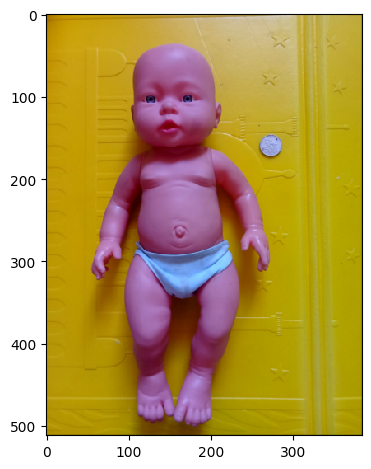

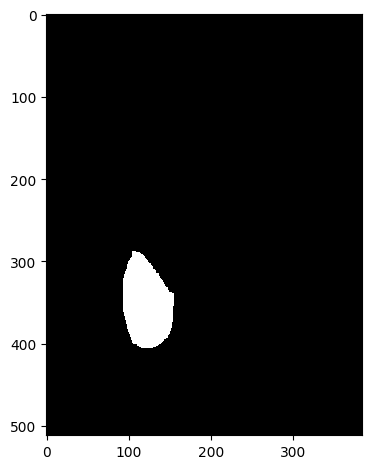

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


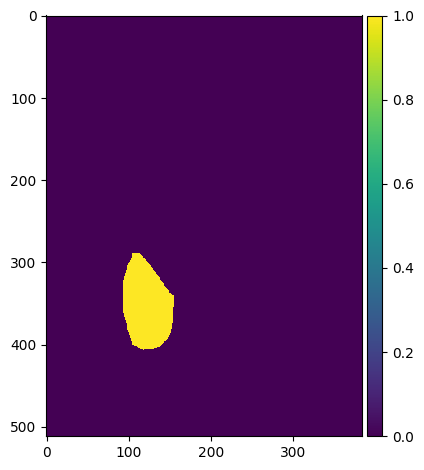

In [111]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples

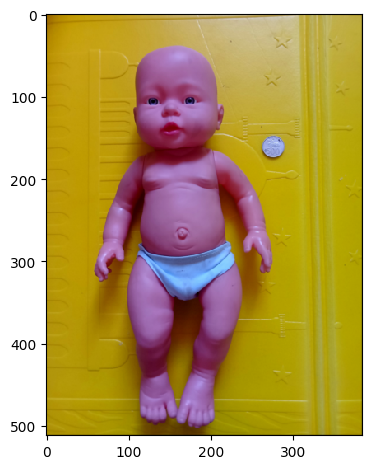

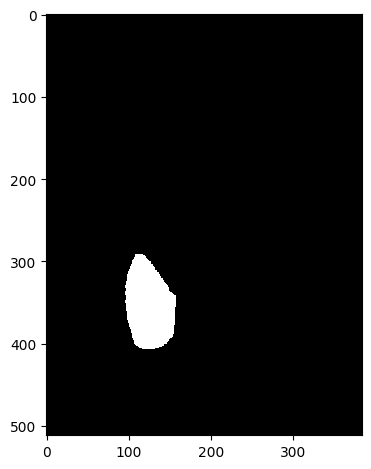

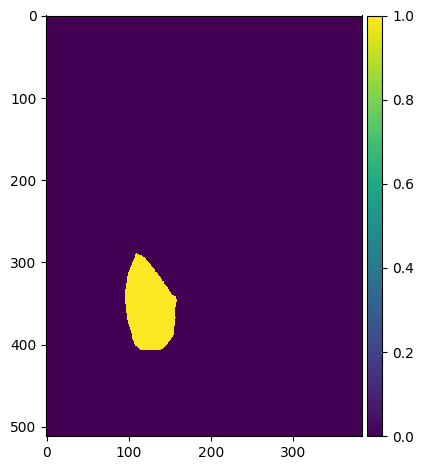

In [113]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Perform Prediction from Image Test

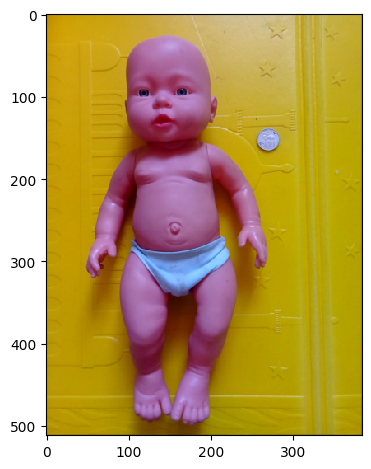

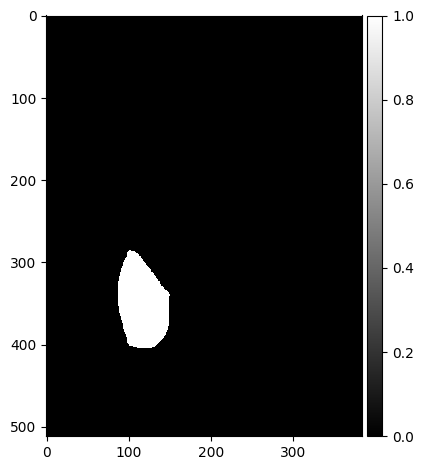

In [114]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()

# Saving Model

In [116]:
model.save('model_thigh.keras')


# ==== Main Code Ends Here ===

In [ ]:
loaded_model = tf.keras.models.load_model('D:\\BANGKIT\\Capstone Project\\GITHUB\\model_head.keras', safe_mode=False)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
preds_test = loaded_model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


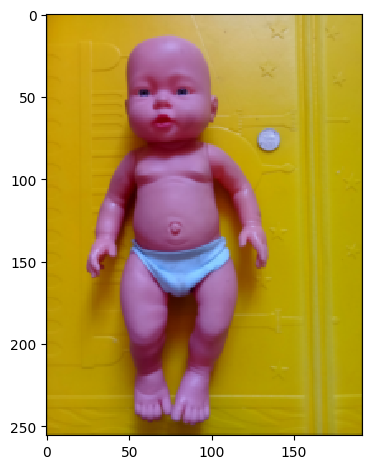

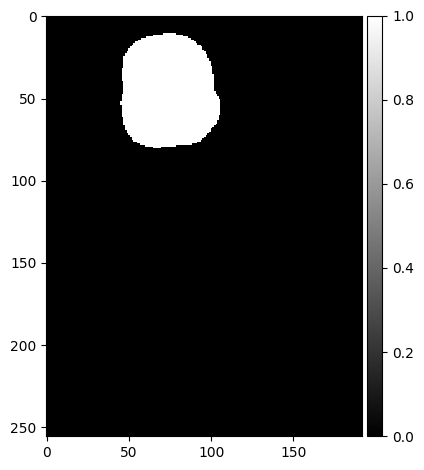

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()